## FFNN on bandgap

In [4]:
# import absl.logging
# absl.logging.set_verbosity(absl.logging.ERROR)

import tensorflow as tf
from tensorflow import keras
#import tensorflow_addons as tfa
import pickle

from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD
from sklearn import metrics
from tensorflow.keras.models import load_model

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
print(tf.__version__)

2.18.0


In [2]:
df= pd.read_excel("Results_Eg/withDescriptors_DFT_D3_ACS_AMI_348_hetero_Ef_Eg.xlsx")

In [5]:
df_NN = df[['avg_vdw_radius', 'delta_a1a2_vdw_radius', 'delta_bx_vdw_radius', 'max_diff_vdw_radius', 'std_vdw_radius', 
           'avg_covalent_radius', 'delta_a1a2_covalent_radius', 'delta_bx_covalent_radius', 'max_diff_covalent_radius', 
           'std_covalent_radius', 'avg_atomic_radius', 'delta_a1a2_atomic_radius', 'delta_bx_atomic_radius', 'max_diff_atomic_radius', 
           'std_atomic_radius', 'avg_atomic_volume', 'delta_a1a2_atomic_volume', 'delta_bx_atomic_volume', 'max_diff_atomic_volume', 
           'std_atomic_volume', 'avg_dipole_polarizability', 'delta_a1a2_dipole_polarizability', 'delta_bx_dipole_polarizability', 
           'max_diff_dipole_polarizability', 'std_dipole_polarizability', 'avg_val_electrons', 'delta_a1a2_val_electrons', 
           'delta_bx_val_electrons', 'max_diff_val_electrons', 'std_val_electrons', 'avg_unp_electrons', 'delta_a1a2_unp_electrons',
           'delta_bx_unp_electrons', 'max_diff_unp_electrons', 'std_unp_electrons', 'avg_ion_energies', 'delta_a1a2_ion_energies', 
           'delta_bx_ion_energies', 'max_diff_ion_energies', 'std_ion_energies', 'avg_no_electrons', 'delta_a1a2_no_electrons', 
           'delta_bx_no_electrons', 'max_diff_no_electrons', 'std_no_electrons', 'avg_electronegativity', 'delta_a1a2_electronegativity',
           'delta_bx_electronegativity', 'max_diff_electronegativity', 'std_electronegativity', 'avg_electron_affinity', 
           'delta_a1a2_electron_affinity', 'delta_bx_electron_affinity', 'max_diff_electron_affinity', 'std_electron_affinity', 
            'Ef_per_cell', 'Mu_per_cell','bandgap']]

In [6]:
train_val_dataset = df_NN.sample(frac = 0.8, random_state = 153)
train_dataset = train_val_dataset.sample(frac = 0.75, random_state = 153)
val_dataset = train_val_dataset.drop(train_dataset.index)
test_dataset = df_NN.drop(train_val_dataset.index)

train_data = np.copy(train_dataset)
val_data = np.copy(val_dataset)
test_data = np.copy(test_dataset)

train_data = pd.DataFrame(train_data)
val_data = pd.DataFrame(val_data)
test_data = pd.DataFrame(test_data)

X_train = train_data.drop([55,56,57],axis='columns')
X_val = val_data.drop([55,56,57],axis='columns')
X_test = test_data.drop([55,56,57],axis='columns')

y_train = train_data.drop([i for i in range(55)],axis='columns')
y_val = val_data.drop([i for i in range(55)],axis='columns')
y_test = test_data.drop([i for i in range(55)],axis='columns')

X_eg_train = np.copy(X_train)
X_eg_val = np.copy(X_val)
X_eg_test = np.copy(X_test)

y_eg_train = y_train.drop([55,56],axis='columns')
y_eg_val = y_val.drop([55,56],axis='columns')
y_eg_test = y_test.drop([55,56],axis='columns')

X_train.to_csv('Results_Eg/X_train_ffnn.csv',index=False)
X_val.to_csv('Results_Eg/X_val_ffnn.csv',index=False)
X_test.to_csv('Results_Eg/X_test_ffnn.csv',index=False)
y_train.to_csv('Results_Eg/y_train_ffnn.csv',index=False)
y_val.to_csv('Results_Eg/y_val_ffnn.csv',index=False)
y_test.to_csv('Results_Eg/y_test_ffnn.csv',index=False)

In [2]:
## Using Optuna to tune the hyperparameters in FFNN

In [3]:
X_eg_train = pd.read_csv('Results_Eg/X_train_ffnn.csv')
X_eg_val = pd.read_csv('Results_Eg/X_val_ffnn.csv')
X_eg_test = pd.read_csv('Results_Eg/X_test_ffnn.csv')

y_eg_train = pd.read_csv('Results_Eg/y_train_ffnn.csv')
y_eg_val = pd.read_csv('Results_Eg/y_val_ffnn.csv')
y_eg_test = pd.read_csv('Results_Eg/y_test_ffnn.csv')

In [4]:
# !pip install optuna

In [49]:
import tensorflow as tf
import optuna
import numpy as np
from tensorflow.keras import layers, regularizers
from sklearn.metrics import r2_score
import random

def objective(trial):

    hidden_layer_1  = trial.suggest_categorical('hidden_1', [55, 64])
    hidden_layer_2 = trial.suggest_categorical('hidden_2', [128, 32, 30])
    hidden_layer_3 = trial.suggest_categorical('hidden_3', [64, 20, 16])
    dropout_rate = trial.suggest_categorical('dropout_rate', [0.0, 0.1, 0.2])
    reg_type = trial.suggest_categorical('reg_type', ['None', 'L1', 'L2'])
    reg_strength = trial.suggest_categorical('reg_strength', [1e-5, 1e-4, 1e-3, 1e-2]) if reg_type != 'None' else 0.0
    learning_rate = trial.suggest_categorical('learning_rate', [1e-4, 1e-3, 5e-3, 1e-2])
    activation_type = trial.suggest_categorical('activation', ['relu', 'elu', 'selu'])

    SEED = 42
    tf.random.set_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)
    
    normalizer = tf.keras.layers.Normalization(axis=-1)
    normalizer.adapt(np.array(X_eg_train))
    
    if reg_type == 'L1':
        reg = regularizers.l1(reg_strength)
    elif reg_type == 'L2':
        reg = regularizers.l2(reg_strength)
    else:
        reg = None  # No regularization  

    model = tf.keras.Sequential([normalizer])

    model.add(layers.Dense(hidden_layer_1, activation=activation_type, kernel_regularizer=reg))
    model.add(layers.Dropout(dropout_rate, seed=SEED))
    model.add(layers.Dense(hidden_layer_2, activation=activation_type, kernel_regularizer=reg))
    model.add(layers.Dropout(dropout_rate, seed=SEED))
    model.add(layers.Dense(hidden_layer_3, activation=activation_type, kernel_regularizer=reg))
    model.add(layers.Dropout(dropout_rate, seed=SEED))
    model.add(layers.Dense(1))  

    # Compile model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='mean_absolute_error')

    # Train model
    history = model.fit(X_eg_train, y_eg_train['57'], validation_data=(X_eg_val, y_eg_val['57']), epochs=500, verbose=0, shuffle=False)

    # Return best validation loss
    # return min(history.history['val_loss'])

    # Return best R2 scores
    r2_train = r2_score(y_eg_train['57'], model.predict(X_eg_train).flatten())
    r2_val = r2_score(y_eg_val['57'], model.predict(X_eg_val).flatten())
    r2_test = r2_score(y_eg_test['57'], model.predict(X_eg_test).flatten())
    return r2_train,r2_val,r2_test

# Run Optuna optimization
#study = optuna.create_study(direction='minimize') # for minimizing loss
study = optuna.create_study(directions=['maximize','maximize','maximize']) # for maximizing R2
study.optimize(objective, n_trials=600)

# Print best hyperparameters
#print("Best hyperparameters:", study.best_params)
#print("Best R² score:", study.best_value)
print('Best Trials: \n')
study.best_trials

[I 2025-02-26 15:13:29,844] A new study created in memory with name: no-name-972f9e7a-6a3a-48c5-a8d5-67a69b9a20d1


3/3 [==============================] - 0s 5ms/step


[I 2025-02-26 15:13:50,045] Trial 0 finished with values: [0.9401766928246843, 0.01989505651938761, -2.277198714424418] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.0001, 'learning_rate': 0.0001, 'activation': 'relu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 15:14:12,392] Trial 1 finished with values: [0.8629788486790003, 0.8426436860609751, 0.8305151584300186] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'selu'}.


3/3 [==============================] - 0s 6ms/step


[I 2025-02-26 15:14:34,877] Trial 2 finished with values: [-0.16676740238740706, -0.1950726834862413, -0.1432989932380324] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.0001, 'activation': 'relu'}.


3/3 [==============================] - 0s 4ms/step


[I 2025-02-26 15:14:55,721] Trial 3 finished with values: [0.7547646672698898, 0.7309159940214222, 0.6996205600482104] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 1e-05, 'learning_rate': 0.001, 'activation': 'elu'}.


3/3 [==============================] - 0s 5ms/step


[I 2025-02-26 15:15:17,342] Trial 4 finished with values: [0.8905292901918928, 0.8613065946718962, 0.7764818411933933] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.01, 'activation': 'elu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 15:15:38,533] Trial 5 finished with values: [0.7182186990269808, 0.7048917619665699, 0.6245889023742559] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 0.001, 'learning_rate': 0.01, 'activation': 'selu'}.


3/3 [==============================] - 0s 9ms/step


[I 2025-02-26 15:16:01,039] Trial 6 finished with values: [-0.17394598064993705, -0.201981032708904, -0.15437865119404237] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.2, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 8ms/step


[I 2025-02-26 15:16:21,985] Trial 7 finished with values: [0.7993412610088042, 0.8169028374988418, 0.6553870198729161] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.01, 'activation': 'selu'}.


3/3 [==============================] - 0s 4ms/step


[I 2025-02-26 15:16:43,846] Trial 8 finished with values: [0.08712379694083139, 0.09637199430969934, -0.5077573319816744] and parameters: {'hidden_1': 64, 'hidden_2': 30, 'hidden_3': 64, 'dropout_rate': 0.2, 'reg_type': 'L1', 'reg_strength': 0.001, 'learning_rate': 0.0001, 'activation': 'selu'}.


3/3 [==============================] - 0s 8ms/step


[I 2025-02-26 15:17:06,290] Trial 9 finished with values: [0.9679736728377909, 0.8059294607167387, 0.6137938058931739] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 1e-05, 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 15:17:27,272] Trial 10 finished with values: [0.8487773587464104, 0.8489297702343257, 0.7723067617945362] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 0.0001, 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 15:17:49,551] Trial 11 finished with values: [0.8934896556627367, 0.9071711286880818, 0.7208783356773985] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.2, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 5ms/step


[I 2025-02-26 15:18:10,821] Trial 12 finished with values: [0.8297973177057891, 0.7979808493555126, 0.8013546731850993] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.2, 'reg_type': 'L2', 'reg_strength': 0.001, 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 15:18:30,861] Trial 13 finished with values: [0.9530038228737484, 0.8476155522161944, 0.6051242096074845] and parameters: {'hidden_1': 64, 'hidden_2': 30, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'elu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 15:18:52,375] Trial 14 finished with values: [0.711748750511314, 0.6653512671279651, 0.5951900836552624] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 1e-05, 'learning_rate': 0.001, 'activation': 'selu'}.


3/3 [==============================] - 0s 9ms/step


[I 2025-02-26 15:19:13,476] Trial 15 finished with values: [0.8426188758483679, 0.8656998526487952, 0.8013167237341565] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 0.001, 'learning_rate': 0.01, 'activation': 'relu'}.


3/3 [==============================] - 0s 8ms/step


[I 2025-02-26 15:19:34,750] Trial 16 finished with values: [0.40091544463452256, 0.3055298860650537, 0.49635335025643235] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 0.0001, 'learning_rate': 0.001, 'activation': 'selu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 15:19:55,518] Trial 17 finished with values: [0.7160366826740574, 0.6835195671304561, 0.6813721980809866] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'elu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 15:20:15,433] Trial 18 finished with values: [0.9281155010471271, -2.930437464633838, -11.572114664711977] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.0001, 'activation': 'selu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 15:20:35,988] Trial 19 finished with values: [-0.1565207080636064, -0.18516593874271714, -0.12780751977999594] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.001, 'activation': 'selu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 15:20:57,582] Trial 20 finished with values: [0.9081306339631742, 0.8914251959091752, 0.8234751449468284] and parameters: {'hidden_1': 64, 'hidden_2': 30, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'selu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 15:21:18,782] Trial 21 finished with values: [0.8386051420610049, 0.6815899155205708, 0.5345558107319222] and parameters: {'hidden_1': 55, 'hidden_2': 30, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 0.0001, 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 15:21:40,036] Trial 22 finished with values: [0.33216011278881175, 0.28835694712856763, 0.15279288293740445] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.2, 'reg_type': 'None', 'learning_rate': 0.0001, 'activation': 'selu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 15:22:02,309] Trial 23 finished with values: [0.8669612560764809, 0.8872082105156427, 0.8276424995327737] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 1e-05, 'learning_rate': 0.005, 'activation': 'selu'}.


3/3 [==============================] - 0s 6ms/step


[I 2025-02-26 15:22:22,354] Trial 24 finished with values: [-0.17409413363560566, -0.20212332231608587, -0.15460911388263288] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.2, 'reg_type': 'L2', 'reg_strength': 0.01, 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 0s/step


[I 2025-02-26 15:22:44,067] Trial 25 finished with values: [-0.16404541800700478, -0.19244641579185395, -0.13914552409687042] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 15:23:06,403] Trial 26 finished with values: [0.26694592226213887, 0.2730887651777296, 0.36260807320313326] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.2, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.0001, 'activation': 'selu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 15:23:25,175] Trial 27 finished with values: [0.8343334792678966, -3.1350432219171624, -11.845929464756138] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.0001, 'activation': 'selu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 15:23:47,735] Trial 28 finished with values: [0.714150504729459, 0.6762412254668303, 0.720861059701121] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.2, 'reg_type': 'L2', 'reg_strength': 0.01, 'learning_rate': 0.0001, 'activation': 'relu'}.


3/3 [==============================] - 0s 9ms/step


[I 2025-02-26 15:24:09,757] Trial 29 finished with values: [-0.16654376481402244, -0.19486917837423312, -0.14296802637482697] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.2, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.0001, 'activation': 'elu'}.


3/3 [==============================] - 0s 8ms/step


[I 2025-02-26 15:24:30,804] Trial 30 finished with values: [0.9150433997502856, 0.9135880512639791, 0.8833317596263206] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.01, 'activation': 'elu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 15:24:53,016] Trial 31 finished with values: [0.893988298415028, 0.8856880033560213, 0.49598076772512334] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 1e-05, 'learning_rate': 0.01, 'activation': 'relu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 15:25:13,365] Trial 32 finished with values: [0.9316261828541487, -3.073948687200688, -13.986371982943858] and parameters: {'hidden_1': 55, 'hidden_2': 30, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 1e-05, 'learning_rate': 0.0001, 'activation': 'selu'}.


3/3 [==============================] - 0s 9ms/step


[I 2025-02-26 15:25:35,369] Trial 33 finished with values: [-0.16762078016504112, -0.19589527335297263, -0.14460666340975403] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.2, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 9ms/step


[I 2025-02-26 15:25:56,345] Trial 34 finished with values: [0.35079707577445873, 0.3008182250751339, 0.5181555918096037] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.2, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'selu'}.


3/3 [==============================] - 0s 0s/step


[I 2025-02-26 15:26:17,355] Trial 35 finished with values: [0.9501466301666992, -1.6044942745028248, -11.07009324928615] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 1e-05, 'learning_rate': 0.0001, 'activation': 'selu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 15:26:37,826] Trial 36 finished with values: [0.9134242611856311, 0.09913510105687395, -1.4139998647636456] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.0001, 'activation': 'elu'}.


3/3 [==============================] - 0s 5ms/step


[I 2025-02-26 15:26:58,126] Trial 37 finished with values: [0.9424056731919291, 0.9330688229060203, 0.7609215540787576] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 1e-05, 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 5ms/step


[I 2025-02-26 15:27:19,452] Trial 38 finished with values: [0.9892564974802942, 0.9259830164126256, 0.7114661188686554] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 10ms/step


[I 2025-02-26 15:27:40,860] Trial 39 finished with values: [0.6834603335246311, 0.6026064221557228, 0.5041516521940534] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.2, 'reg_type': 'L1', 'reg_strength': 0.001, 'learning_rate': 0.0001, 'activation': 'relu'}.


3/3 [==============================] - 0s 9ms/step


[I 2025-02-26 15:28:00,667] Trial 40 finished with values: [-0.17431804977042775, -0.20233833434843573, -0.15495748648929375] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.001, 'activation': 'selu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 15:28:21,019] Trial 41 finished with values: [0.9176230849403748, 0.8848356544903199, 0.7642617971147184] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'selu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 15:28:43,024] Trial 42 finished with values: [0.33043190969589775, 0.25194354494623095, 0.48632238084364476] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.2, 'reg_type': 'L1', 'reg_strength': 0.0001, 'learning_rate': 0.001, 'activation': 'selu'}.


3/3 [==============================] - 0s 6ms/step


[I 2025-02-26 15:29:03,249] Trial 43 finished with values: [0.7404681833479513, 0.6971622994697999, 0.6584130494701765] and parameters: {'hidden_1': 64, 'hidden_2': 30, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.001, 'learning_rate': 0.005, 'activation': 'selu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 15:29:22,333] Trial 44 finished with values: [0.9982700987875548, 0.8197398362299851, 0.6789016657965228] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 5ms/step


[I 2025-02-26 15:29:44,078] Trial 45 finished with values: [0.3382687055955925, 0.279046864322132, 0.4965235969035362] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.2, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'selu'}.


3/3 [==============================] - 0s 9ms/step


[I 2025-02-26 15:30:04,687] Trial 46 finished with values: [0.9674904997474636, 0.8719817592642083, 0.6047989309020299] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.01, 'activation': 'selu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 15:30:24,395] Trial 47 finished with values: [0.9175481548882275, 0.8254777038030485, 0.7420171572979202] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.0001, 'learning_rate': 0.01, 'activation': 'elu'}.


3/3 [==============================] - 0s 6ms/step


[I 2025-02-26 15:30:45,627] Trial 48 finished with values: [0.4886297994579558, 0.39554570346420237, 0.48642192266903095] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 0.0001, 'learning_rate': 0.0001, 'activation': 'elu'}.


3/3 [==============================] - 0s 5ms/step


[I 2025-02-26 15:31:06,439] Trial 49 finished with values: [0.9105333585810162, 0.884256711788731, 0.7303636365924807] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.01, 'activation': 'relu'}.


3/3 [==============================] - 0s 9ms/step


[I 2025-02-26 15:31:27,535] Trial 50 finished with values: [0.6498294671024735, 0.6230634006409369, 0.5250901145111382] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 1e-05, 'learning_rate': 0.001, 'activation': 'selu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 15:31:48,482] Trial 51 finished with values: [0.9700298937924327, 0.8700759349727496, 0.7892780887176818] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 1e-05, 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 15:32:10,527] Trial 52 finished with values: [0.7153402756781435, 0.6251556736481236, 0.354332499866467] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.2, 'reg_type': 'L2', 'reg_strength': 0.001, 'learning_rate': 0.0001, 'activation': 'relu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 15:32:32,969] Trial 53 finished with values: [0.8915993107000477, -3.108998988575501, -13.185280770719233] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.0001, 'activation': 'selu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 15:32:54,503] Trial 54 finished with values: [0.9081306339631742, 0.8914251959091752, 0.8234751449468284] and parameters: {'hidden_1': 64, 'hidden_2': 30, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'selu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 15:33:17,109] Trial 55 finished with values: [0.9346226626922638, 0.91768370513897, 0.8561120471319116] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.01, 'activation': 'selu'}.


3/3 [==============================] - 0s 8ms/step


[I 2025-02-26 15:33:39,963] Trial 56 finished with values: [0.9776516904989625, 0.8812501848445956, 0.7498625129067791] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 4ms/step


[I 2025-02-26 15:34:01,364] Trial 57 finished with values: [0.7429531110443429, 0.7376878423809781, 0.6969288432504407] and parameters: {'hidden_1': 55, 'hidden_2': 30, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.01, 'learning_rate': 0.005, 'activation': 'selu'}.


3/3 [==============================] - 0s 4ms/step


[I 2025-02-26 15:34:23,904] Trial 58 finished with values: [0.8592810889814936, 0.8232522148965923, 0.8405816936958758] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 1e-05, 'learning_rate': 0.01, 'activation': 'selu'}.


3/3 [==============================] - 0s 8ms/step


[I 2025-02-26 15:34:46,597] Trial 59 finished with values: [0.8463396065770877, 0.8440435618542541, 0.7894488341050288] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 0.01, 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 15:35:07,890] Trial 60 finished with values: [0.901649001175007, 0.9134093510100733, 0.883229598942485] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.0001, 'learning_rate': 0.005, 'activation': 'selu'}.


3/3 [==============================] - 0s 8ms/step


[I 2025-02-26 15:35:29,351] Trial 61 finished with values: [0.945061081988984, 0.8403354105561708, 0.8352259438910886] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'selu'}.


3/3 [==============================] - 0s 8ms/step


[I 2025-02-26 15:35:50,724] Trial 62 finished with values: [0.8783426172492059, 0.6789646984782904, 0.052993235866626076] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.001, 'learning_rate': 0.0001, 'activation': 'elu'}.


3/3 [==============================] - 0s 9ms/step


[I 2025-02-26 15:36:13,148] Trial 63 finished with values: [0.6335657675125459, 0.5249129545939172, 0.5249994006648535] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.2, 'reg_type': 'L2', 'reg_strength': 1e-05, 'learning_rate': 0.0001, 'activation': 'relu'}.


3/3 [==============================] - 0s 8ms/step


[I 2025-02-26 15:36:35,148] Trial 64 finished with values: [-0.15853695054273675, -0.18711975462400643, -0.13082426320539087] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.001, 'activation': 'elu'}.


3/3 [==============================] - 0s 8ms/step


[I 2025-02-26 15:36:58,074] Trial 65 finished with values: [-0.15659762036637015, -0.18524049885233462, -0.12792226239038307] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.01, 'activation': 'relu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 15:37:21,599] Trial 66 finished with values: [0.7921086749866917, 0.7414617492666276, 0.6987909524590102] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 0.0001, 'learning_rate': 0.005, 'activation': 'selu'}.


3/3 [==============================] - 0s 5ms/step


[I 2025-02-26 15:37:44,472] Trial 67 finished with values: [0.3975742591670346, 0.3901526939509192, 0.14968082736588628] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 1e-05, 'learning_rate': 0.0001, 'activation': 'selu'}.


3/3 [==============================] - 0s 9ms/step


[I 2025-02-26 15:38:06,646] Trial 68 finished with values: [0.9238934610333809, 0.6482302851379407, 0.7030450043007058] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.0001, 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 0s/step


[I 2025-02-26 15:38:28,730] Trial 69 finished with values: [0.8481533662427068, 0.8297440238231146, 0.7328648829240606] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.001, 'learning_rate': 0.005, 'activation': 'selu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 15:38:51,821] Trial 70 finished with values: [0.8602045917914, 0.8371086410484352, 0.6471839885546048] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.2, 'reg_type': 'None', 'learning_rate': 0.01, 'activation': 'elu'}.


3/3 [==============================] - 0s 4ms/step


[I 2025-02-26 15:39:14,038] Trial 71 finished with values: [-0.16002999836220466, -0.18856511649338037, -0.13306832040206307] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.001, 'activation': 'selu'}.


3/3 [==============================] - 0s 5ms/step


[I 2025-02-26 15:39:36,985] Trial 72 finished with values: [0.8982794752057677, 0.649590467585855, -0.12541591424692178] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'selu'}.


3/3 [==============================] - 0s 4ms/step


[I 2025-02-26 15:40:00,306] Trial 73 finished with values: [-0.157810873894493, -0.18641639842625835, -0.12973605900591845] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.2, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.005, 'activation': 'selu'}.


3/3 [==============================] - 0s 9ms/step


[I 2025-02-26 15:40:23,811] Trial 74 finished with values: [0.9986920058348013, 0.8854810895585191, 0.6612238254427518] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 6ms/step


[I 2025-02-26 15:40:49,681] Trial 75 finished with values: [0.41611197127067867, 0.4216450796907524, 0.2649780966662081] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.2, 'reg_type': 'L2', 'reg_strength': 0.01, 'learning_rate': 0.0001, 'activation': 'selu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 15:41:13,122] Trial 76 finished with values: [0.9433269057165239, 0.9172244295345056, 0.7861526350662145] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 0.0001, 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 15:41:36,746] Trial 77 finished with values: [0.9004140312884177, 0.9118688679970255, 0.8278497910429373] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 1e-05, 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 9ms/step


[I 2025-02-26 15:41:59,948] Trial 78 finished with values: [0.895666991915248, 0.8220413235620997, 0.779791353591681] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.2, 'reg_type': 'None', 'learning_rate': 0.01, 'activation': 'elu'}.


3/3 [==============================] - 0s 8ms/step


[I 2025-02-26 15:42:24,320] Trial 79 finished with values: [0.9275148287581069, 0.50435643613393, -1.3901963315468229] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.0001, 'activation': 'elu'}.


3/3 [==============================] - 0s 6ms/step


[I 2025-02-26 15:42:47,097] Trial 80 finished with values: [0.3982739434333453, 0.42207869168303, 0.1030206210931871] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.0001, 'activation': 'selu'}.


3/3 [==============================] - 0s 8ms/step


[I 2025-02-26 15:43:07,127] Trial 81 finished with values: [0.7742957566740819, 0.8020227438203871, 0.6113524363823811] and parameters: {'hidden_1': 55, 'hidden_2': 30, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.0001, 'learning_rate': 0.01, 'activation': 'selu'}.


3/3 [==============================] - 0s 4ms/step


[I 2025-02-26 15:43:26,972] Trial 82 finished with values: [0.7619284089770757, 0.7202137926387222, 0.7355975216097651] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.2, 'reg_type': 'L1', 'reg_strength': 0.0001, 'learning_rate': 0.01, 'activation': 'elu'}.


3/3 [==============================] - 0s 5ms/step


[I 2025-02-26 15:43:48,269] Trial 83 finished with values: [0.7076053441959647, 0.6824504779355612, 0.6665961020670339] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 0.001, 'learning_rate': 0.0001, 'activation': 'relu'}.


3/3 [==============================] - 0s 6ms/step


[I 2025-02-26 15:44:08,495] Trial 84 finished with values: [0.9890032616665684, 0.002992897269277206, -1.9926870683564313] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.001, 'learning_rate': 0.0001, 'activation': 'relu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 15:44:27,603] Trial 85 finished with values: [0.8715924064280174, -2.01862857289425, -13.439803942083662] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.0001, 'activation': 'selu'}.


3/3 [==============================] - 0s 8ms/step


[I 2025-02-26 15:44:49,028] Trial 86 finished with values: [0.07418566439084762, 0.03564594756493944, 0.20053599699162783] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 0.01, 'learning_rate': 0.001, 'activation': 'elu'}.


3/3 [==============================] - 0s 4ms/step


[I 2025-02-26 15:45:09,988] Trial 87 finished with values: [0.8810762589618071, 0.8741281436563932, 0.846734868967887] and parameters: {'hidden_1': 64, 'hidden_2': 30, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'selu'}.


3/3 [==============================] - 0s 5ms/step


[I 2025-02-26 15:45:31,358] Trial 88 finished with values: [0.8750053339600479, 0.8611528721517181, 0.8565200326112603] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 1e-05, 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 0s/step


[I 2025-02-26 15:45:52,000] Trial 89 finished with values: [0.35446275671770544, 0.29780896635825294, 0.5249068895558444] and parameters: {'hidden_1': 55, 'hidden_2': 30, 'hidden_3': 16, 'dropout_rate': 0.2, 'reg_type': 'L2', 'reg_strength': 1e-05, 'learning_rate': 0.001, 'activation': 'selu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 15:46:12,257] Trial 90 finished with values: [0.9097365684644203, -2.6314542279856883, -23.52084879126071] and parameters: {'hidden_1': 55, 'hidden_2': 30, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.0001, 'activation': 'selu'}.


3/3 [==============================] - 0s 5ms/step


[I 2025-02-26 15:46:34,377] Trial 91 finished with values: [0.9892564974802942, 0.9259830164126256, 0.7114661188686554] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 15:46:54,575] Trial 92 finished with values: [-0.17835542079944733, -0.2062121627571163, -0.16127096992163104] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.01, 'activation': 'relu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 15:47:16,261] Trial 93 finished with values: [-0.17784113171005234, -0.2057191346532412, -0.16046379207137895] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 0.01, 'learning_rate': 0.01, 'activation': 'relu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 15:47:36,946] Trial 94 finished with values: [0.9690827305449929, 0.10282984224853431, -2.05174448646536] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 1e-05, 'learning_rate': 0.0001, 'activation': 'relu'}.


3/3 [==============================] - 0s 5ms/step


[I 2025-02-26 15:47:57,512] Trial 95 finished with values: [0.38998709155881683, 0.2549694820320457, 0.45731751129096176] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.2, 'reg_type': 'None', 'learning_rate': 0.0001, 'activation': 'elu'}.


3/3 [==============================] - 0s 4ms/step


[I 2025-02-26 15:48:19,288] Trial 96 finished with values: [0.967554833716826, 0.8483200926089524, 0.6271422282979062] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 0.0001, 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 6ms/step


[I 2025-02-26 15:48:40,737] Trial 97 finished with values: [0.4645268271301416, 0.48682742157164205, 0.04026874739717068] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.0001, 'activation': 'selu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 15:49:01,809] Trial 98 finished with values: [0.9833479033473794, 0.920453561280819, 0.8265206330734058] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 9ms/step


[I 2025-02-26 15:49:20,826] Trial 99 finished with values: [0.9134242611856311, 0.09913510105687395, -1.4139998647636456] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.0001, 'activation': 'elu'}.


3/3 [==============================] - 0s 9ms/step


[I 2025-02-26 15:49:41,568] Trial 100 finished with values: [0.8602725028757428, -0.286641862102365, -4.936258177301083] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.0001, 'learning_rate': 0.0001, 'activation': 'elu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 15:50:03,094] Trial 101 finished with values: [0.9554958401629655, 0.906882103745433, 0.701716521475607] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.01, 'activation': 'elu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 15:50:23,407] Trial 102 finished with values: [0.6660001111031588, 0.6107884916639978, 0.6653840030498914] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.2, 'reg_type': 'L2', 'reg_strength': 0.001, 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 15:50:45,424] Trial 103 finished with values: [0.34040357545719224, 0.3709962498083108, 0.47585588176544147] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 0.001, 'learning_rate': 0.0001, 'activation': 'selu'}.


3/3 [==============================] - 0s 5ms/step


[I 2025-02-26 15:51:06,777] Trial 104 finished with values: [0.889949836508672, 0.8978728875683882, 0.8294361923277952] and parameters: {'hidden_1': 55, 'hidden_2': 30, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.01, 'activation': 'selu'}.


3/3 [==============================] - 0s 4ms/step


[I 2025-02-26 15:51:26,888] Trial 105 finished with values: [0.559630238478541, 0.511395603526414, 0.6519913117265796] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 0.01, 'learning_rate': 0.01, 'activation': 'selu'}.


3/3 [==============================] - 0s 6ms/step


[I 2025-02-26 15:51:48,879] Trial 106 finished with values: [0.90293906713272, 0.8944707824732373, 0.6696080296445395] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 1e-05, 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 15:52:09,912] Trial 107 finished with values: [0.9492180457239269, 0.9241374120854075, 0.7143587306467074] and parameters: {'hidden_1': 64, 'hidden_2': 30, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 15:52:30,869] Trial 108 finished with values: [0.8905775931692663, 0.9160966837603866, 0.8331283674249539] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.2, 'reg_type': 'None', 'learning_rate': 0.01, 'activation': 'elu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 15:52:52,001] Trial 109 finished with values: [0.6130789926488822, 0.5861826788289775, 0.5323297034049914] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.0001, 'activation': 'elu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 15:53:13,561] Trial 110 finished with values: [0.871014511555981, 0.6930970724776249, 0.5927486116874088] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.0001, 'activation': 'relu'}.


3/3 [==============================] - 0s 4ms/step


[I 2025-02-26 15:53:35,069] Trial 111 finished with values: [-0.1437501931784173, -0.17273614599707177, -0.10908579933223828] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.2, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.01, 'activation': 'elu'}.


3/3 [==============================] - 0s 8ms/step


[I 2025-02-26 15:53:55,333] Trial 112 finished with values: [-0.1749029126921846, -0.20290002701725873, -0.1558688855896211] and parameters: {'hidden_1': 64, 'hidden_2': 30, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 0.01, 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 15:54:15,410] Trial 113 finished with values: [0.9908191629087236, -0.0015271384873871696, -4.7722984899460625] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 1e-05, 'learning_rate': 0.0001, 'activation': 'relu'}.


3/3 [==============================] - 0s 6ms/step


[I 2025-02-26 15:54:36,950] Trial 114 finished with values: [0.8303215227737317, 0.8334428168149692, 0.6576868601621677] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'selu'}.


3/3 [==============================] - 0s 4ms/step


[I 2025-02-26 15:54:56,953] Trial 115 finished with values: [0.9217825245040767, -1.6046025070082184, -24.645411220713154] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.0001, 'activation': 'selu'}.


3/3 [==============================] - 0s 5ms/step


[I 2025-02-26 15:55:18,367] Trial 116 finished with values: [0.8719797169574188, 0.8379516107784042, 0.788232123944649] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.01, 'activation': 'selu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 15:55:39,283] Trial 117 finished with values: [0.891131324499717, 0.8830836249688127, 0.8713379506104795] and parameters: {'hidden_1': 64, 'hidden_2': 30, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.01, 'activation': 'selu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 15:56:01,454] Trial 118 finished with values: [0.8073069757291218, 0.8087387384658616, 0.7422780401510218] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.01, 'activation': 'elu'}.


3/3 [==============================] - 0s 9ms/step


[I 2025-02-26 15:56:22,002] Trial 119 finished with values: [0.8443478879781872, 0.8601880646163558, 0.6732076887134426] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'selu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 15:56:43,170] Trial 120 finished with values: [0.2695776368418721, 0.14180504130214155, -0.6120458941648377] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.0001, 'activation': 'selu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 15:57:05,515] Trial 121 finished with values: [-0.16455389484761862, -0.19293730260482977, -0.13991935875103034] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 0.001, 'learning_rate': 0.01, 'activation': 'relu'}.


3/3 [==============================] - 0s 5ms/step


[I 2025-02-26 15:57:23,709] Trial 122 finished with values: [0.9593267214354597, 0.9170002915745947, 0.6855615692389854] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.01, 'activation': 'elu'}.


3/3 [==============================] - 0s 5ms/step


[I 2025-02-26 15:57:45,814] Trial 123 finished with values: [0.8810762589618071, 0.8741281436563932, 0.846734868967887] and parameters: {'hidden_1': 64, 'hidden_2': 30, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'selu'}.


3/3 [==============================] - 0s 4ms/step


[I 2025-02-26 15:58:08,349] Trial 124 finished with values: [0.8389492022443954, 0.8005718180864534, 0.7587655284702192] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 0.0001, 'learning_rate': 0.005, 'activation': 'selu'}.


3/3 [==============================] - 0s 10ms/step


[I 2025-02-26 15:58:27,690] Trial 125 finished with values: [0.9849886025543387, 0.8499729641125582, 0.5870028382865966] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 15:58:48,669] Trial 126 finished with values: [0.2695776368418721, 0.14180504130214155, -0.6120458941648377] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.0001, 'activation': 'selu'}.


3/3 [==============================] - 0s 6ms/step


[I 2025-02-26 15:59:10,232] Trial 127 finished with values: [0.9523453041144865, 0.9101811775041065, 0.665531433681646] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.2, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 15:59:29,463] Trial 128 finished with values: [0.8382185893762111, 0.8568498458489462, 0.801878075114553] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.01, 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 4ms/step


[I 2025-02-26 15:59:49,534] Trial 129 finished with values: [0.8969892082197706, 0.002850141816271412, -3.1762229554073045] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.0001, 'activation': 'elu'}.


3/3 [==============================] - 0s 4ms/step


[I 2025-02-26 16:00:11,047] Trial 130 finished with values: [0.4193479614484976, 0.32102617537078637, 0.3510557329331184] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 0.001, 'learning_rate': 0.005, 'activation': 'selu'}.


3/3 [==============================] - 0s 10ms/step


[I 2025-02-26 16:00:31,686] Trial 131 finished with values: [-0.1507671805362305, -0.17957790395397955, -0.11928812371601549] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.01, 'activation': 'selu'}.


3/3 [==============================] - 0s 9ms/step


[I 2025-02-26 16:00:52,287] Trial 132 finished with values: [0.9700298937924327, 0.8700759349727496, 0.7892780887176818] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 1e-05, 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 16:01:13,257] Trial 133 finished with values: [0.8685662765579286, 0.8827197797408695, 0.8511291303855729] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'selu'}.


3/3 [==============================] - 0s 0s/step


[I 2025-02-26 16:01:34,735] Trial 134 finished with values: [0.8264399378634963, 0.7812167478000374, 0.665933285781666] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 1e-05, 'learning_rate': 0.01, 'activation': 'relu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 16:01:55,306] Trial 135 finished with values: [0.8835451678335011, 0.8624764987598021, 0.8578938966441507] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 1e-05, 'learning_rate': 0.01, 'activation': 'selu'}.


3/3 [==============================] - 0s 10ms/step


[I 2025-02-26 16:02:15,420] Trial 136 finished with values: [0.9451213221204009, 0.9188873859212977, 0.7605233704117736] and parameters: {'hidden_1': 64, 'hidden_2': 30, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.001, 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 9ms/step


[I 2025-02-26 16:02:37,666] Trial 137 finished with values: [0.7361572116124826, 0.6035542120783626, 0.46330414631262784] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.2, 'reg_type': 'L1', 'reg_strength': 1e-05, 'learning_rate': 0.0001, 'activation': 'relu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 16:02:58,741] Trial 138 finished with values: [0.9169574259537129, 0.9266843470705532, 0.8143753302722164] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 0.001, 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 6ms/step


[I 2025-02-26 16:03:19,699] Trial 139 finished with values: [0.8813036682572081, 0.8740499336492825, 0.8104911114431007] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 0.0001, 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 16:03:41,408] Trial 140 finished with values: [0.893988298415028, 0.8856880033560213, 0.49598076772512334] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 1e-05, 'learning_rate': 0.01, 'activation': 'relu'}.


3/3 [==============================] - 0s 4ms/step


[I 2025-02-26 16:04:01,690] Trial 141 finished with values: [0.8915993107000477, -3.108998988575501, -13.185280770719233] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.0001, 'activation': 'selu'}.


3/3 [==============================] - 0s 6ms/step


[I 2025-02-26 16:04:21,589] Trial 142 finished with values: [-0.013124743627935143, -0.0514992353793049, 0.0844763068693456] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 0.001, 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 8ms/step


[I 2025-02-26 16:04:42,581] Trial 143 finished with values: [0.9067318722428914, 0.9266052788601143, 0.8858894809077198] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 1e-05, 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 16:05:04,487] Trial 144 finished with values: [0.9882084004472635, 0.9027247633690997, 0.7555031588968023] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 1e-05, 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 16:05:24,678] Trial 145 finished with values: [0.6940508173445972, 0.6668863088932302, 0.6092976092412826] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 0.0001, 'learning_rate': 0.005, 'activation': 'selu'}.


3/3 [==============================] - 0s 6ms/step


[I 2025-02-26 16:05:45,230] Trial 146 finished with values: [0.8744439847836918, 0.8792646233436672, 0.875011600145662] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.0001, 'learning_rate': 0.005, 'activation': 'selu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 16:06:06,927] Trial 147 finished with values: [0.9135690759606998, 0.8720412733843255, 0.7364083261694678] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.01, 'activation': 'relu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 16:06:26,568] Trial 148 finished with values: [0.9776516904989625, 0.8812501848445956, 0.7498625129067791] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 8ms/step


[I 2025-02-26 16:06:48,891] Trial 149 finished with values: [0.9833479033473794, 0.920453561280819, 0.8265206330734058] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 16:07:08,734] Trial 150 finished with values: [0.9553524856702309, 0.871618413237686, 0.7668752316704186] and parameters: {'hidden_1': 55, 'hidden_2': 30, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'selu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 16:07:28,527] Trial 151 finished with values: [0.9542966361335382, 0.8045635489875034, 0.548651235154343] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 16:07:49,376] Trial 152 finished with values: [-0.16654778790254454, -0.19486079236670162, -0.14296267303617816] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.0001, 'activation': 'elu'}.


3/3 [==============================] - 0s 8ms/step


[I 2025-02-26 16:08:10,302] Trial 153 finished with values: [0.895458616620331, 0.8926953652037405, 0.44917247955484907] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 0.0001, 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 16:08:30,466] Trial 154 finished with values: [-0.14642365091991594, -0.17534640612342556, -0.11294769423916295] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 16:08:49,807] Trial 155 finished with values: [0.9926149547997366, 0.9233196823700526, 0.8156309400950982] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 9ms/step


[I 2025-02-26 16:09:09,414] Trial 156 finished with values: [0.9591722081721977, 0.9224837142548311, 0.7301468137253266] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.001, 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 16:09:30,014] Trial 157 finished with values: [0.8147887708456133, 0.8117190913386785, 0.6899240923299697] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 0.0001, 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 8ms/step


[I 2025-02-26 16:09:50,611] Trial 158 finished with values: [0.9587796317150747, 0.9453066897899317, 0.7325273683996798] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.001, 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 6ms/step


[I 2025-02-26 16:10:11,137] Trial 159 finished with values: [-0.17092791625266002, -0.19907965196765076, -0.14969865280911243] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 4ms/step


[I 2025-02-26 16:10:31,829] Trial 160 finished with values: [0.4193479614484976, 0.32102617537078637, 0.3510557329331184] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 0.001, 'learning_rate': 0.005, 'activation': 'selu'}.


3/3 [==============================] - 0s 8ms/step


[I 2025-02-26 16:10:51,738] Trial 161 finished with values: [-0.14699264495790665, -0.17590136644383048, -0.11377368108060226] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.01, 'activation': 'elu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 16:11:11,537] Trial 162 finished with values: [0.909451592281488, 0.9255504879300127, 0.7499718139923716] and parameters: {'hidden_1': 64, 'hidden_2': 30, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.001, 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 16:11:32,960] Trial 163 finished with values: [0.9892564974802942, 0.9259830164126256, 0.7114661188686554] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 16:11:52,807] Trial 164 finished with values: [0.9488393233310464, 0.9398271648616474, 0.6818199880051796] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.0001, 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 6ms/step


[I 2025-02-26 16:12:12,400] Trial 165 finished with values: [0.9926149547997366, 0.9233196823700526, 0.8156309400950982] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 9ms/step


[I 2025-02-26 16:12:33,797] Trial 166 finished with values: [0.9599487530409552, 0.7856077531388772, 0.6369607489812349] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 9ms/step


[I 2025-02-26 16:12:53,420] Trial 167 finished with values: [0.9176230849403748, 0.8848356544903199, 0.7642617971147184] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'selu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 16:13:13,289] Trial 168 finished with values: [0.7834941485066853, 0.7593558764252486, 0.7281923851978114] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.001, 'learning_rate': 0.005, 'activation': 'selu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 16:13:34,474] Trial 169 finished with values: [0.9679736728377909, 0.8059294607167387, 0.6137938058931739] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 1e-05, 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 16:13:53,781] Trial 170 finished with values: [0.9635192685043931, 0.8605049631935581, 0.7929104194732313] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.0001, 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 16:14:14,669] Trial 171 finished with values: [-0.16769195987891017, -0.19596386843716962, -0.144715852774165] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 0.01, 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 16:14:35,747] Trial 172 finished with values: [-0.1662006007662289, -0.1945261264560647, -0.14243189938941714] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 8ms/step


[I 2025-02-26 16:14:56,476] Trial 173 finished with values: [0.8730222902169681, 0.9080428313931861, 0.8087979718798028] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.2, 'reg_type': 'None', 'learning_rate': 0.01, 'activation': 'elu'}.


3/3 [==============================] - 0s 5ms/step


[I 2025-02-26 16:15:17,401] Trial 174 finished with values: [0.9532502927018824, 0.8525680136310197, 0.7523359149922532] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 16:15:38,642] Trial 175 finished with values: [0.9423913427012425, 0.9312944529189229, 0.8234780610955328] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 0.001, 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 5ms/step


[I 2025-02-26 16:15:58,418] Trial 176 finished with values: [0.7965593465397556, 0.8142103377838191, 0.6509316339481592] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.001, 'learning_rate': 0.01, 'activation': 'elu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 16:16:18,393] Trial 177 finished with values: [0.9176230849403748, 0.8848356544903199, 0.7642617971147184] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'selu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 16:16:39,282] Trial 178 finished with values: [0.8926586253521422, 0.8888069531417335, 0.8028487557050468] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.0001, 'learning_rate': 0.005, 'activation': 'selu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 16:16:59,845] Trial 179 finished with values: [0.9511216164868833, 0.8865640671241921, 0.7193365619097885] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 16:17:19,081] Trial 180 finished with values: [0.9060672630322911, 0.8883824316373783, 0.8155865363033881] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.0001, 'learning_rate': 0.005, 'activation': 'selu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 16:17:39,047] Trial 181 finished with values: [0.9092082447949783, 0.84132631851049, 0.6799807805331256] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.01, 'activation': 'relu'}.


3/3 [==============================] - 0s 0s/step


[I 2025-02-26 16:18:01,729] Trial 182 finished with values: [0.9599487530409552, 0.7856077531388772, 0.6369607489812349] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 4ms/step


[I 2025-02-26 16:18:21,722] Trial 183 finished with values: [0.9192447338248965, 0.8383508202038172, 0.6262835907157795] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 16:18:43,288] Trial 184 finished with values: [0.9192447338248965, 0.8383508202038172, 0.6262835907157795] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 4ms/step


[I 2025-02-26 16:19:04,322] Trial 185 finished with values: [0.8016779905229129, 0.8037859062330913, 0.8934108896219257] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 9ms/step


[I 2025-02-26 16:19:24,551] Trial 186 finished with values: [0.7713609005529982, 0.674445373383527, 0.7363935725831072] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 0.01, 'learning_rate': 0.0001, 'activation': 'relu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 16:19:44,955] Trial 187 finished with values: [0.9960872074778295, 0.7824710612485744, 0.7886123791247094] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 1e-05, 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 16:20:06,376] Trial 188 finished with values: [0.9201865615806556, 0.9227034500390309, 0.6218108543075713] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 9ms/step


[I 2025-02-26 16:20:25,791] Trial 189 finished with values: [0.9438852731852706, 0.8783374499769465, 0.5900045953373411] and parameters: {'hidden_1': 55, 'hidden_2': 30, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 16:20:47,000] Trial 190 finished with values: [0.9192447338248965, 0.8383508202038172, 0.6262835907157795] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 16:21:09,073] Trial 191 finished with values: [0.7459782486661721, 0.7618726183990041, 0.6728902517454325] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 0.0001, 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 6ms/step


[I 2025-02-26 16:21:27,997] Trial 192 finished with values: [0.9530038228737484, 0.8476155522161944, 0.6051242096074845] and parameters: {'hidden_1': 64, 'hidden_2': 30, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'elu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 16:21:48,197] Trial 193 finished with values: [-0.14424031756348898, -0.1732150209671397, -0.10979143341086472] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.01, 'activation': 'relu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 16:22:09,597] Trial 194 finished with values: [0.9346226626922638, 0.91768370513897, 0.8561120471319116] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.01, 'activation': 'selu'}.


3/3 [==============================] - 0s 5ms/step


[I 2025-02-26 16:22:28,812] Trial 195 finished with values: [0.7137869906681078, 0.7148921517883553, 0.6302752678535256] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.01, 'learning_rate': 0.001, 'activation': 'elu'}.


3/3 [==============================] - 0s 8ms/step


[I 2025-02-26 16:22:50,384] Trial 196 finished with values: [0.9684134058127685, 0.8570547715336588, 0.6237976017809481] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 16:23:11,938] Trial 197 finished with values: [0.9679736728377909, 0.8059294607167387, 0.6137938058931739] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 1e-05, 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 16:23:32,392] Trial 198 finished with values: [0.9281024965143552, 0.9239380948625862, 0.7977118072515595] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'selu'}.


3/3 [==============================] - 0s 6ms/step


[I 2025-02-26 16:23:52,929] Trial 199 finished with values: [0.6073125195093902, 0.5605194154528812, 0.6734134065674369] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 0.001, 'learning_rate': 0.005, 'activation': 'selu'}.


3/3 [==============================] - 0s 8ms/step


[I 2025-02-26 16:24:12,691] Trial 200 finished with values: [0.9292010824678992, 0.8987547210932558, 0.7196143029462949] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.001, 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 16:24:33,635] Trial 201 finished with values: [0.9234173071681853, 0.8697820754475236, 0.7558676051802382] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 0.0001, 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 16:24:53,891] Trial 202 finished with values: [0.661374643761788, 0.6044288039952451, 0.5930043038199412] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 0.001, 'learning_rate': 0.01, 'activation': 'elu'}.


3/3 [==============================] - 0s 9ms/step


[I 2025-02-26 16:25:14,110] Trial 203 finished with values: [0.8750194225442863, 0.8903931116474065, 0.7783929718203678] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 1e-05, 'learning_rate': 0.01, 'activation': 'selu'}.


3/3 [==============================] - 0s 6ms/step


[I 2025-02-26 16:25:34,098] Trial 204 finished with values: [0.9960163260999986, 0.910249477361684, 0.6856336858108514] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 10ms/step


[I 2025-02-26 16:25:53,148] Trial 205 finished with values: [0.9915759313611869, 0.8297544763223004, 0.5482093365854058] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 1e-05, 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 5ms/step


[I 2025-02-26 16:26:15,781] Trial 206 finished with values: [0.9892564974802942, 0.9259830164126256, 0.7114661188686554] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 9ms/step


[I 2025-02-26 16:26:36,200] Trial 207 finished with values: [0.9831287698496961, 0.9275099107727913, 0.5700802652009552] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 16:26:56,633] Trial 208 finished with values: [0.8054459346253074, 0.8173466996030165, 0.6070126617098834] and parameters: {'hidden_1': 64, 'hidden_2': 30, 'hidden_3': 16, 'dropout_rate': 0.2, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'selu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 16:27:18,571] Trial 209 finished with values: [0.7961521329096938, 0.8095479390715582, 0.7426880155941936] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'selu'}.


3/3 [==============================] - 0s 6ms/step


[I 2025-02-26 16:27:39,519] Trial 210 finished with values: [0.6700273782676305, 0.6983697399400135, 0.5719943133625862] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.2, 'reg_type': 'L2', 'reg_strength': 1e-05, 'learning_rate': 0.01, 'activation': 'elu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 16:28:00,639] Trial 211 finished with values: [0.8208439034966825, 0.7739043125452338, 0.7757456714428372] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 16:28:21,199] Trial 212 finished with values: [-0.14594812004439994, -0.17488244264223995, -0.11225847277872947] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.2, 'reg_type': 'L2', 'reg_strength': 0.01, 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 6ms/step


[I 2025-02-26 16:28:41,870] Trial 213 finished with values: [0.8143084105203569, 0.8006777394886817, 0.7346860671860826] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.01, 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 16:29:03,999] Trial 214 finished with values: [-0.1506417809965419, -0.1794558927874721, -0.11910395464869006] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 1e-05, 'learning_rate': 0.01, 'activation': 'relu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 16:29:24,488] Trial 215 finished with values: [0.9676709002236707, 0.8916715793121366, 0.7003829012232552] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 6ms/step


[I 2025-02-26 16:29:45,194] Trial 216 finished with values: [0.9754607643619801, 0.8896072024854321, 0.7516696524755293] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.01, 'activation': 'relu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 16:30:07,576] Trial 217 finished with values: [0.901649001175007, 0.9134093510100733, 0.883229598942485] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.0001, 'learning_rate': 0.005, 'activation': 'selu'}.


3/3 [==============================] - 0s 4ms/step


[I 2025-02-26 16:30:28,948] Trial 218 finished with values: [-0.16176933443723485, -0.1902474108406409, -0.1356933395564437] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 9ms/step


[I 2025-02-26 16:30:51,780] Trial 219 finished with values: [0.728398659996833, 0.693414747224596, 0.6995415433080023] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 0.001, 'learning_rate': 0.001, 'activation': 'elu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 16:31:12,524] Trial 220 finished with values: [0.9967153566031308, 0.03452024236235984, -4.4365002458888565] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.0001, 'learning_rate': 0.0001, 'activation': 'relu'}.


3/3 [==============================] - 0s 6ms/step


[I 2025-02-26 16:31:34,208] Trial 221 finished with values: [0.8463396065770877, 0.8440435618542541, 0.7894488341050288] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 0.01, 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 16:31:54,425] Trial 222 finished with values: [0.9063777615925831, 0.9016623855137582, 0.8223577424744231] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.01, 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 8ms/step


[I 2025-02-26 16:32:15,626] Trial 223 finished with values: [0.907004088282705, 0.6636715288740778, 0.17559709059063566] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 1e-05, 'learning_rate': 0.001, 'activation': 'selu'}.


3/3 [==============================] - 0s 4ms/step


[I 2025-02-26 16:32:37,714] Trial 224 finished with values: [-0.152828340956068, -0.18158196258568227, -0.12232464484836769] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.01, 'activation': 'relu'}.


3/3 [==============================] - 0s 5ms/step


[I 2025-02-26 16:32:59,451] Trial 225 finished with values: [0.936572729723163, 0.949315028652228, 0.7980581197816994] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 16:33:21,428] Trial 226 finished with values: [0.9503848073468824, 0.827169601486266, 0.6884727939669867] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 4ms/step


[I 2025-02-26 16:33:42,053] Trial 227 finished with values: [0.9890742436098918, 0.7281268310482548, 0.3124565455865438] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 4ms/step


[I 2025-02-26 16:34:03,888] Trial 228 finished with values: [0.9776516904989625, 0.8812501848445956, 0.7498625129067791] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 8ms/step


[I 2025-02-26 16:34:25,015] Trial 229 finished with values: [0.9955972490922271, -0.36130968065493785, -3.403573612365892] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 1e-05, 'learning_rate': 0.0001, 'activation': 'relu'}.


3/3 [==============================] - 0s 4ms/step


[I 2025-02-26 16:34:47,001] Trial 230 finished with values: [0.9176230849403748, 0.8848356544903199, 0.7642617971147184] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'selu'}.


3/3 [==============================] - 0s 4ms/step


[I 2025-02-26 16:35:09,009] Trial 231 finished with values: [0.889949836508672, 0.8978728875683882, 0.8294361923277952] and parameters: {'hidden_1': 55, 'hidden_2': 30, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.01, 'activation': 'selu'}.


3/3 [==============================] - 0s 9ms/step


[I 2025-02-26 16:35:31,496] Trial 232 finished with values: [0.9404332989013456, 0.935559962060787, 0.7981643163118555] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 0.001, 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 5ms/step


[I 2025-02-26 16:35:54,047] Trial 233 finished with values: [0.9048228402812467, 0.9034720690371788, 0.7904785281652653] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.01, 'activation': 'elu'}.


3/3 [==============================] - 0s 4ms/step


[I 2025-02-26 16:36:16,681] Trial 234 finished with values: [0.9736731152614946, 0.8927224477524682, 0.6772238248780237] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 0.0001, 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 16:36:38,179] Trial 235 finished with values: [0.9982700987875548, 0.8197398362299851, 0.6789016657965228] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 10ms/step


[I 2025-02-26 16:37:00,727] Trial 236 finished with values: [0.9169574259537129, 0.9266843470705532, 0.8143753302722164] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 0.001, 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 16:37:25,450] Trial 237 finished with values: [0.919682728405624, 0.8243840467751464, 0.7642105514260664] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.2, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 16:37:50,774] Trial 238 finished with values: [0.6765040999927252, 0.6156369934819687, 0.50319514573383] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'selu'}.


3/3 [==============================] - 0s 4ms/step


[I 2025-02-26 16:38:12,680] Trial 239 finished with values: [0.6212708397254456, 0.5510676149466665, 0.5781913893075796] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'selu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 16:38:34,765] Trial 240 finished with values: [0.8363805986262964, 0.8329244378807116, 0.7855738530753311] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 8ms/step


[I 2025-02-26 16:38:57,379] Trial 241 finished with values: [0.966029269306125, 0.8455051761528424, 0.6458914116745575] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 6ms/step


[I 2025-02-26 16:39:21,793] Trial 242 finished with values: [0.9886664211262026, 0.8334355654053331, 0.6982499976045049] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.0001, 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 5ms/step


[I 2025-02-26 16:39:46,516] Trial 243 finished with values: [0.7961521329096938, 0.8095479390715582, 0.7426880155941936] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'selu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 16:40:06,949] Trial 244 finished with values: [0.9953585752641004, 0.7532811917440618, 0.23393040014123712] and parameters: {'hidden_1': 64, 'hidden_2': 30, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 16:40:26,540] Trial 245 finished with values: [-0.17092791625266002, -0.19907965196765076, -0.14969865280911243] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 9ms/step


[I 2025-02-26 16:40:47,977] Trial 246 finished with values: [0.941806833355936, 0.9227048685327547, 0.7911508394923417] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 1e-05, 'learning_rate': 0.005, 'activation': 'selu'}.


3/3 [==============================] - 0s 5ms/step


[I 2025-02-26 16:41:09,260] Trial 247 finished with values: [0.8140599086165311, 0.7196518753022279, 0.6980739105169732] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 1e-05, 'learning_rate': 0.01, 'activation': 'selu'}.


3/3 [==============================] - 0s 9ms/step


[I 2025-02-26 16:41:28,084] Trial 248 finished with values: [0.9954326327681086, 0.8368140074826653, 0.7886366285565418] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 1e-05, 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 16:41:50,263] Trial 249 finished with values: [0.889949836508672, 0.8978728875683882, 0.8294361923277952] and parameters: {'hidden_1': 55, 'hidden_2': 30, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.01, 'activation': 'selu'}.


3/3 [==============================] - 0s 8ms/step


[I 2025-02-26 16:42:10,969] Trial 250 finished with values: [0.9982700987875548, 0.8197398362299851, 0.6789016657965228] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 16:42:30,182] Trial 251 finished with values: [-0.1557245044624298, -0.18439375206578879, -0.12662057115275593] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.01, 'activation': 'relu'}.


3/3 [==============================] - 0s 5ms/step


[I 2025-02-26 16:42:51,406] Trial 252 finished with values: [0.9960163260999986, 0.910249477361684, 0.6856336858108514] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 4ms/step


[I 2025-02-26 16:43:13,108] Trial 253 finished with values: [0.9865029489143677, 0.8729331265814719, 0.4887536185826876] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 1e-05, 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 9ms/step


[I 2025-02-26 16:43:33,213] Trial 254 finished with values: [0.9559827354784969, 0.9407581197362538, 0.8240042131420715] and parameters: {'hidden_1': 64, 'hidden_2': 30, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.001, 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 16:43:55,106] Trial 255 finished with values: [0.9833479033473794, 0.920453561280819, 0.8265206330734058] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 5ms/step


[I 2025-02-26 16:44:17,696] Trial 256 finished with values: [0.9892564974802942, 0.9259830164126256, 0.7114661188686554] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 16:44:38,028] Trial 257 finished with values: [0.9448578773479733, 0.9302810529503027, 0.698887906759051] and parameters: {'hidden_1': 64, 'hidden_2': 30, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'selu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 16:44:57,753] Trial 258 finished with values: [-0.15530976083872994, -0.18399138504923807, -0.12600317569716135] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 10ms/step


[I 2025-02-26 16:45:18,460] Trial 259 finished with values: [0.9947674721937955, 0.886534089682053, 0.6917614606401725] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 4ms/step


[I 2025-02-26 16:45:40,452] Trial 260 finished with values: [0.9269624984183469, 0.6957581826193477, 0.6207361703311018] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.01, 'activation': 'relu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 16:46:00,145] Trial 261 finished with values: [0.990010824630745, 0.9303390372092617, 0.8194337458098349] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 16:46:21,379] Trial 262 finished with values: [0.8813036682572081, 0.8740499336492825, 0.8104911114431007] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 0.0001, 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 6ms/step


[I 2025-02-26 16:46:41,491] Trial 263 finished with values: [0.8655786355903337, 0.8298469048430986, 0.8189248011444323] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.001, 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 4ms/step


[I 2025-02-26 16:47:01,410] Trial 264 finished with values: [0.9585875562162988, -0.3151685112825866, -5.065337473671593] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 1e-05, 'learning_rate': 0.0001, 'activation': 'relu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 16:47:24,811] Trial 265 finished with values: [0.8386673078195003, 0.8240892918471883, 0.7269688968340264] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 0.01, 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 5ms/step


[I 2025-02-26 16:47:46,795] Trial 266 finished with values: [0.8431386000244545, 0.797843515935653, 0.67928841850979] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.2, 'reg_type': 'L2', 'reg_strength': 0.0001, 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 8ms/step


[I 2025-02-26 16:48:08,947] Trial 267 finished with values: [0.8498086070340349, 0.8195986372302353, 0.7759126641917616] and parameters: {'hidden_1': 64, 'hidden_2': 30, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 0.01, 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 16:48:27,782] Trial 268 finished with values: [0.9890742436098918, 0.7281268310482548, 0.3124565455865438] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 9ms/step


[I 2025-02-26 16:48:49,613] Trial 269 finished with values: [0.9766998554705223, 0.893821934707913, 0.8081829526407577] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 1e-05, 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 16:49:10,688] Trial 270 finished with values: [0.9776516904989625, 0.8812501848445956, 0.7498625129067791] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 16:49:30,503] Trial 271 finished with values: [0.8311633170374014, 0.826379001440572, 0.8031634514029862] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 0.0001, 'learning_rate': 0.01, 'activation': 'selu'}.


3/3 [==============================] - 0s 8ms/step


[I 2025-02-26 16:49:51,908] Trial 272 finished with values: [0.9945755397060578, 0.8479959948800657, 0.6250803722114815] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 5ms/step


[I 2025-02-26 16:50:12,875] Trial 273 finished with values: [0.7695546933422814, 0.7459540756136132, 0.7708255653463623] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'elu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 16:50:32,103] Trial 274 finished with values: [0.8850383568493178, 0.8406479364615905, 0.7310914333899303] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.001, 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 16:50:53,894] Trial 275 finished with values: [-0.15110105559017528, -0.17990269727124897, -0.1197787857900463] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 5ms/step


[I 2025-02-26 16:51:14,607] Trial 276 finished with values: [0.939793232718203, 0.9437338287565888, 0.7816561843265287] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 16:51:37,240] Trial 277 finished with values: [0.9097784084895718, 0.9157294381267227, 0.8378710375611074] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 16:51:59,806] Trial 278 finished with values: [0.9570077955580593, 0.8437914666472026, 0.6647459578031197] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.2, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 16:52:21,149] Trial 279 finished with values: [0.85937454854628, 0.8419866519884505, 0.832149369732952] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'selu'}.


3/3 [==============================] - 0s 6ms/step


[I 2025-02-26 16:52:41,463] Trial 280 finished with values: [0.933148894959087, 0.8800945143797938, 0.7014315470251499] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'selu'}.


3/3 [==============================] - 0s 4ms/step


[I 2025-02-26 16:53:02,812] Trial 281 finished with values: [0.541179608419103, 0.5098774575795876, 0.36444644322997943] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.2, 'reg_type': 'L2', 'reg_strength': 0.001, 'learning_rate': 0.005, 'activation': 'selu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 16:53:23,135] Trial 282 finished with values: [0.9595569343860061, 0.8453260158351785, 0.7327331364735277] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 1e-05, 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 16:53:44,317] Trial 283 finished with values: [0.9768305742167039, 0.9628403930916749, 0.7591491582128775] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 1e-05, 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 16:54:06,279] Trial 284 finished with values: [0.6488211900862841, 0.595001131187239, 0.5475241982595866] and parameters: {'hidden_1': 55, 'hidden_2': 30, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'selu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 16:54:26,100] Trial 285 finished with values: [0.9945755397060578, 0.8479959948800657, 0.6250803722114815] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 4ms/step


[I 2025-02-26 16:54:47,906] Trial 286 finished with values: [0.9296091313986532, 0.9434357870468519, 0.8493793202441592] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 1e-05, 'learning_rate': 0.01, 'activation': 'elu'}.


3/3 [==============================] - 0s 6ms/step


[I 2025-02-26 16:55:09,865] Trial 287 finished with values: [0.9014589367116745, 0.7043983504851131, 0.6941890481538412] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.0001, 'activation': 'relu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 16:55:30,328] Trial 288 finished with values: [0.8390674628169644, 0.8390500060054298, 0.6247674434371167] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'selu'}.


3/3 [==============================] - 0s 4ms/step


[I 2025-02-26 16:55:53,364] Trial 289 finished with values: [0.9599722373908374, 0.9104144423411273, 0.7439342864279143] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.2, 'reg_type': 'L2', 'reg_strength': 1e-05, 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 16:56:13,561] Trial 290 finished with values: [0.9890742436098918, 0.7281268310482548, 0.3124565455865438] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 6ms/step


[I 2025-02-26 16:56:35,539] Trial 291 finished with values: [0.2524951493782306, 0.2153533420814565, -0.587263297492959] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.0001, 'activation': 'selu'}.


3/3 [==============================] - 0s 5ms/step


[I 2025-02-26 16:56:56,929] Trial 292 finished with values: [0.8682101762762665, 0.8645804388094152, 0.8386962527108066] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 5ms/step


[I 2025-02-26 16:57:17,393] Trial 293 finished with values: [0.9214770748730268, -0.3435230633323707, -5.964226640768259] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.01, 'learning_rate': 0.0001, 'activation': 'selu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 16:57:38,348] Trial 294 finished with values: [0.9192447338248965, 0.8383508202038172, 0.6262835907157795] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 4ms/step


[I 2025-02-26 16:58:01,364] Trial 295 finished with values: [0.9423913427012425, 0.9312944529189229, 0.8234780610955328] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 0.001, 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 16:58:22,812] Trial 296 finished with values: [0.9949376958814035, -0.0014241241065044985, -4.836473929795934] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.0001, 'activation': 'relu'}.


3/3 [==============================] - 0s 9ms/step


[I 2025-02-26 16:58:44,979] Trial 297 finished with values: [0.8926467719353006, 0.7658441957703911, 0.6498180687740744] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.01, 'learning_rate': 0.0001, 'activation': 'relu'}.


3/3 [==============================] - 0s 4ms/step


[I 2025-02-26 16:59:05,713] Trial 298 finished with values: [0.9539191667271845, 0.8862385818312657, 0.7542377193740426] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'selu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 16:59:26,909] Trial 299 finished with values: [0.9982700987875548, 0.8197398362299851, 0.6789016657965228] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 8ms/step


[I 2025-02-26 16:59:48,560] Trial 300 finished with values: [0.9947674721937955, 0.886534089682053, 0.6917614606401725] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 8ms/step


[I 2025-02-26 17:00:09,519] Trial 301 finished with values: [0.7324299004786383, 0.6814616636480577, 0.7666311646707908] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 0.01, 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 9ms/step


[I 2025-02-26 17:00:30,331] Trial 302 finished with values: [0.9013952739133049, 0.9334536809266183, 0.8985790658555246] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.001, 'learning_rate': 0.001, 'activation': 'elu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 17:00:53,883] Trial 303 finished with values: [0.967554833716826, 0.8483200926089524, 0.6271422282979062] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 0.0001, 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 17:01:15,738] Trial 304 finished with values: [0.9532502927018824, 0.8525680136310197, 0.7523359149922532] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 4ms/step


[I 2025-02-26 17:01:36,715] Trial 305 finished with values: [0.9963893584550861, 0.7009296017906128, 0.27284172851542066] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 17:01:59,507] Trial 306 finished with values: [0.9664646104208453, 0.9098543006831078, 0.7703228351315763] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 0.0001, 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 17:02:23,333] Trial 307 finished with values: [0.9230083704940736, 0.8544666018104788, 0.7577946994901413] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.2, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 4ms/step


[I 2025-02-26 17:02:44,352] Trial 308 finished with values: [0.951277788591377, 0.9202613529392334, 0.6435560953200226] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 0s/step


[I 2025-02-26 17:03:07,468] Trial 309 finished with values: [0.9230083704940736, 0.8544666018104788, 0.7577946994901413] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.2, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 5ms/step


[I 2025-02-26 17:03:28,300] Trial 310 finished with values: [0.9754607643619801, 0.8896072024854321, 0.7516696524755293] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.01, 'activation': 'relu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 17:03:48,487] Trial 311 finished with values: [0.9947127714786869, 0.8628033978550873, 0.7100196338196418] and parameters: {'hidden_1': 64, 'hidden_2': 30, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 6ms/step


[I 2025-02-26 17:04:09,509] Trial 312 finished with values: [0.9532743978194274, 0.923878261057511, 0.6948946021044013] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.0001, 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 17:04:30,752] Trial 313 finished with values: [0.8850383568493178, 0.8406479364615905, 0.7310914333899303] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.001, 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 8ms/step


[I 2025-02-26 17:04:52,694] Trial 314 finished with values: [0.9398069665435886, 0.9524390516394574, 0.7445541105613743] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.01, 'activation': 'selu'}.


3/3 [==============================] - 0s 4ms/step


[I 2025-02-26 17:05:16,295] Trial 315 finished with values: [0.9833479033473794, 0.920453561280819, 0.8265206330734058] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 6ms/step


[I 2025-02-26 17:05:39,014] Trial 316 finished with values: [0.7959335398680236, 0.8024583692308951, 0.750745581738397] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.001, 'learning_rate': 0.01, 'activation': 'elu'}.


3/3 [==============================] - 0s 8ms/step


[I 2025-02-26 17:06:03,085] Trial 317 finished with values: [0.07670026580109157, 0.03879158024476259, 0.20830485793241216] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 0.01, 'learning_rate': 0.001, 'activation': 'elu'}.


3/3 [==============================] - 0s 9ms/step


[I 2025-02-26 17:06:27,147] Trial 318 finished with values: [0.9253160057643026, 0.909252219297404, 0.7900367887968276] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.01, 'activation': 'selu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 17:06:51,402] Trial 319 finished with values: [0.9865029489143677, 0.8729331265814719, 0.4887536185826876] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 1e-05, 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 9ms/step


[I 2025-02-26 17:07:13,883] Trial 320 finished with values: [0.6221602916956458, 0.5665056494209977, 0.708529720774348] and parameters: {'hidden_1': 55, 'hidden_2': 30, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 0.01, 'learning_rate': 0.005, 'activation': 'selu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 17:07:36,155] Trial 321 finished with values: [0.8813036682572081, 0.8740499336492825, 0.8104911114431007] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 0.0001, 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 17:08:00,216] Trial 322 finished with values: [0.6934087065223636, 0.6419389818459186, 0.6763025923584614] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 1e-05, 'learning_rate': 0.001, 'activation': 'selu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 17:08:26,403] Trial 323 finished with values: [0.9892564974802942, 0.9259830164126256, 0.7114661188686554] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 6ms/step


[I 2025-02-26 17:08:47,530] Trial 324 finished with values: [-0.16466467525162654, -0.19304423362519874, -0.14008807988338323] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 17:09:08,950] Trial 325 finished with values: [0.9718417884392921, 0.8096976788199174, 0.715998448337982] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 1e-05, 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 17:09:29,889] Trial 326 finished with values: [0.9833479033473794, 0.920453561280819, 0.8265206330734058] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 9ms/step


[I 2025-02-26 17:09:50,497] Trial 327 finished with values: [0.9966862129986143, 0.7551531089491564, 0.44313481660370313] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 9ms/step


[I 2025-02-26 17:10:11,245] Trial 328 finished with values: [0.9735911768329824, 0.8639463298126795, 0.7066424973751663] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 1e-05, 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 8ms/step


[I 2025-02-26 17:10:30,551] Trial 329 finished with values: [0.9849886025543387, 0.8499729641125582, 0.5870028382865966] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 17:10:52,982] Trial 330 finished with values: [-0.1755154776417951, -0.20348809860236838, -0.15682451835788158] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.001, 'activation': 'selu'}.


3/3 [==============================] - 0s 8ms/step


[I 2025-02-26 17:11:13,151] Trial 331 finished with values: [0.986398755109747, 0.8833264785388735, 0.7464863985890817] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.0001, 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 6ms/step


[I 2025-02-26 17:11:33,152] Trial 332 finished with values: [0.936572729723163, 0.949315028652228, 0.7980581197816994] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 17:11:55,647] Trial 333 finished with values: [0.9599487530409552, 0.7856077531388772, 0.6369607489812349] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 10ms/step


[I 2025-02-26 17:12:16,918] Trial 334 finished with values: [0.8208439034966825, 0.7739043125452338, 0.7757456714428372] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 6ms/step


[I 2025-02-26 17:12:37,585] Trial 335 finished with values: [0.9433269057165239, 0.9172244295345056, 0.7861526350662145] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 0.0001, 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 17:12:59,620] Trial 336 finished with values: [0.9503848073468824, 0.827169601486266, 0.6884727939669867] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 8ms/step


[I 2025-02-26 17:13:19,879] Trial 337 finished with values: [0.9799766616332354, 0.7735284974819792, 0.3300371683084097] and parameters: {'hidden_1': 64, 'hidden_2': 30, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 17:13:40,334] Trial 338 finished with values: [0.9978214071690299, 0.7828735370446143, 0.7390552383019621] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 0s/step


[I 2025-02-26 17:14:01,947] Trial 339 finished with values: [0.8382471406484809, 0.845531501318752, 0.7627424951118773] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.01, 'activation': 'selu'}.


3/3 [==============================] - 0s 0s/step


[I 2025-02-26 17:14:24,507] Trial 340 finished with values: [0.6451577052198258, 0.5509714697040374, 0.6736004129310991] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 1e-05, 'learning_rate': 0.001, 'activation': 'selu'}.


3/3 [==============================] - 0s 4ms/step


[I 2025-02-26 17:14:47,176] Trial 341 finished with values: [0.8213433116814366, 0.8078943597149504, 0.8068896815341342] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'elu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 17:15:09,797] Trial 342 finished with values: [0.9833479033473794, 0.920453561280819, 0.8265206330734058] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 4ms/step


[I 2025-02-26 17:15:31,708] Trial 343 finished with values: [0.9269624984183469, 0.6957581826193477, 0.6207361703311018] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.01, 'activation': 'relu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 17:15:52,657] Trial 344 finished with values: [0.9947127714786869, 0.8628033978550873, 0.7100196338196418] and parameters: {'hidden_1': 64, 'hidden_2': 30, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 17:16:14,661] Trial 345 finished with values: [0.9048228402812467, 0.9034720690371788, 0.7904785281652653] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.01, 'activation': 'elu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 17:16:35,306] Trial 346 finished with values: [0.7476674091378273, 0.7371820532840996, 0.6121644857588955] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.01, 'learning_rate': 0.001, 'activation': 'selu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 17:16:57,717] Trial 347 finished with values: [0.7364436542414405, 0.6974119917260375, 0.6099791329043571] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.2, 'reg_type': 'L2', 'reg_strength': 0.0001, 'learning_rate': 0.01, 'activation': 'elu'}.


3/3 [==============================] - 0s 4ms/step


[I 2025-02-26 17:17:18,654] Trial 348 finished with values: [0.9599487530409552, 0.7856077531388772, 0.6369607489812349] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 17:17:37,387] Trial 349 finished with values: [0.9928481365699623, 0.9013500983487299, 0.7116241016675855] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 10ms/step


[I 2025-02-26 17:17:57,140] Trial 350 finished with values: [0.8869941121472409, 0.8764775444113072, 0.753325474557092] and parameters: {'hidden_1': 64, 'hidden_2': 30, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 6ms/step


[I 2025-02-26 17:18:17,583] Trial 351 finished with values: [0.7695546933422814, 0.7459540756136132, 0.7708255653463623] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'elu'}.


3/3 [==============================] - 0s 4ms/step


[I 2025-02-26 17:18:35,872] Trial 352 finished with values: [0.9890742436098918, 0.7281268310482548, 0.3124565455865438] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 9ms/step


[I 2025-02-26 17:18:56,302] Trial 353 finished with values: [0.8860918375403544, 0.8291542325596232, 0.692960238047645] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.01, 'learning_rate': 0.0001, 'activation': 'relu'}.


3/3 [==============================] - 0s 5ms/step


[I 2025-02-26 17:19:17,145] Trial 354 finished with values: [0.9947973154453056, 0.8643661406263846, 0.6552152583399521] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 6ms/step


[I 2025-02-26 17:19:35,531] Trial 355 finished with values: [0.992578053929836, 0.6337547875088234, 0.6244339056840011] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 1e-05, 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 17:19:56,065] Trial 356 finished with values: [0.8016779905229129, 0.8037859062330913, 0.8934108896219257] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 6ms/step


[I 2025-02-26 17:20:16,787] Trial 357 finished with values: [0.9947973154453056, 0.8643661406263846, 0.6552152583399521] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 9ms/step


[I 2025-02-26 17:20:35,342] Trial 358 finished with values: [0.8395475830477747, 0.7801702350910481, 0.33478334081839267] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 0.0001, 'learning_rate': 0.01, 'activation': 'relu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 17:20:55,655] Trial 359 finished with values: [0.8860918375403544, 0.8291542325596232, 0.692960238047645] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.01, 'learning_rate': 0.0001, 'activation': 'relu'}.


3/3 [==============================] - 0s 10ms/step


[I 2025-02-26 17:21:15,230] Trial 360 finished with values: [0.85937454854628, 0.8419866519884505, 0.832149369732952] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'selu'}.


3/3 [==============================] - 0s 9ms/step


[I 2025-02-26 17:21:33,775] Trial 361 finished with values: [-0.16100881733670902, -0.18951202546126167, -0.1345441256345017] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.005, 'activation': 'selu'}.


3/3 [==============================] - 0s 6ms/step


[I 2025-02-26 17:21:53,408] Trial 362 finished with values: [0.9947127714786869, 0.8628033978550873, 0.7100196338196418] and parameters: {'hidden_1': 64, 'hidden_2': 30, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 17:22:13,151] Trial 363 finished with values: [0.9511216164868833, 0.8865640671241921, 0.7193365619097885] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 6ms/step


[I 2025-02-26 17:22:33,684] Trial 364 finished with values: [0.8420106411592354, 0.7514699544593894, 0.5252377990926558] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.01, 'activation': 'relu'}.


3/3 [==============================] - 0s 4ms/step


[I 2025-02-26 17:22:54,606] Trial 365 finished with values: [0.8982794752057677, 0.649590467585855, -0.12541591424692178] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'selu'}.


3/3 [==============================] - 0s 5ms/step


[I 2025-02-26 17:23:13,698] Trial 366 finished with values: [0.913370869542049, 0.9159548921653411, 0.8034329716185626] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.001, 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 9ms/step


[I 2025-02-26 17:23:32,596] Trial 367 finished with values: [0.9928481365699623, 0.9013500983487299, 0.7116241016675855] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 8ms/step


[I 2025-02-26 17:23:54,810] Trial 368 finished with values: [0.6628802603940896, 0.5950071947269415, 0.5779438375779995] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'selu'}.


3/3 [==============================] - 0s 0s/step


[I 2025-02-26 17:24:15,615] Trial 369 finished with values: [-0.17457636082556793, -0.20258644326315456, -0.15536016919551687] and parameters: {'hidden_1': 64, 'hidden_2': 30, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.005, 'activation': 'selu'}.


3/3 [==============================] - 0s 5ms/step


[I 2025-02-26 17:24:37,886] Trial 370 finished with values: [0.9424446362245098, 0.8580863919010393, 0.77258940558636] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 6ms/step


[I 2025-02-26 17:24:59,679] Trial 371 finished with values: [0.936572729723163, 0.949315028652228, 0.7980581197816994] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 17:25:19,884] Trial 372 finished with values: [0.9776516904989625, 0.8812501848445956, 0.7498625129067791] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 8ms/step


[I 2025-02-26 17:25:39,397] Trial 373 finished with values: [0.9754607643619801, 0.8896072024854321, 0.7516696524755293] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.01, 'activation': 'relu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 17:25:59,760] Trial 374 finished with values: [0.9898803635816954, 0.8925517908365597, 0.7994379913409759] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.01, 'activation': 'elu'}.


3/3 [==============================] - 0s 8ms/step


[I 2025-02-26 17:26:18,738] Trial 375 finished with values: [0.9125590205179697, 0.8973204543441726, 0.8223952922444285] and parameters: {'hidden_1': 64, 'hidden_2': 30, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.01, 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 17:26:39,151] Trial 376 finished with values: [0.9603826869705967, 0.8500949717735702, 0.8019630688004608] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.01, 'activation': 'relu'}.


3/3 [==============================] - 0s 5ms/step


[I 2025-02-26 17:27:00,399] Trial 377 finished with values: [0.9982700987875548, 0.8197398362299851, 0.6789016657965228] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 8ms/step


[I 2025-02-26 17:27:22,336] Trial 378 finished with values: [0.7276678144332398, 0.7291116268201889, 0.5748138904731619] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 0.01, 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 9ms/step


[I 2025-02-26 17:27:44,240] Trial 379 finished with values: [0.9327722434895171, 0.806497178970067, 0.5134861281399162] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.2, 'reg_type': 'L2', 'reg_strength': 1e-05, 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 17:28:07,786] Trial 380 finished with values: [0.7062539713481853, 0.7016917048484494, 0.5840463530627648] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.01, 'learning_rate': 0.01, 'activation': 'selu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 17:28:27,443] Trial 381 finished with values: [0.9947127714786869, 0.8628033978550873, 0.7100196338196418] and parameters: {'hidden_1': 64, 'hidden_2': 30, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 17:28:49,106] Trial 382 finished with values: [0.9982700987875548, 0.8197398362299851, 0.6789016657965228] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 17:29:10,029] Trial 383 finished with values: [0.9247739413294013, 0.6854561086134081, 0.4795637983370279] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.2, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 5ms/step


[I 2025-02-26 17:29:30,538] Trial 384 finished with values: [0.936572729723163, 0.949315028652228, 0.7980581197816994] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 17:29:51,339] Trial 385 finished with values: [0.9139354898896593, 0.9155034072350352, 0.7475934032196021] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.01, 'activation': 'selu'}.


3/3 [==============================] - 0s 9ms/step


[I 2025-02-26 17:30:10,702] Trial 386 finished with values: [0.7577715561751573, 0.7423924776385842, 0.5975423322723203] and parameters: {'hidden_1': 64, 'hidden_2': 30, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.001, 'learning_rate': 0.005, 'activation': 'selu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 17:30:30,379] Trial 387 finished with values: [0.9930244339465749, 0.012080562568199338, -2.149711632901798] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.0001, 'activation': 'relu'}.


3/3 [==============================] - 0s 6ms/step


[I 2025-02-26 17:30:51,075] Trial 388 finished with values: [0.9978214071690299, 0.7828735370446143, 0.7390552383019621] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 8ms/step


[I 2025-02-26 17:31:14,221] Trial 389 finished with values: [0.9833479033473794, 0.920453561280819, 0.8265206330734058] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 17:31:33,840] Trial 390 finished with values: [0.9037884899243227, 0.9022370643510479, 0.7888850125670954] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.01, 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 6ms/step


[I 2025-02-26 17:31:56,757] Trial 391 finished with values: [0.9833479033473794, 0.920453561280819, 0.8265206330734058] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 9ms/step


[I 2025-02-26 17:32:16,863] Trial 392 finished with values: [0.9982700987875548, 0.8197398362299851, 0.6789016657965228] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 8ms/step


[I 2025-02-26 17:32:39,008] Trial 393 finished with values: [0.9223347145369198, 0.8789649958458052, 0.4317905523713045] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'elu'}.


3/3 [==============================] - 0s 8ms/step


[I 2025-02-26 17:33:02,151] Trial 394 finished with values: [0.7767559848675022, 0.781245079407942, 0.6038895019557529] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 0.0001, 'learning_rate': 0.01, 'activation': 'elu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 17:33:23,936] Trial 395 finished with values: [-0.14611519992178712, -0.1750454239040613, -0.11250075207563714] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.01, 'activation': 'selu'}.


3/3 [==============================] - 0s 5ms/step


[I 2025-02-26 17:33:44,469] Trial 396 finished with values: [0.9747101939995241, 0.948975406085455, 0.6049826509537226] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.001, 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 17:34:06,903] Trial 397 finished with values: [0.9599487530409552, 0.7856077531388772, 0.6369607489812349] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 9ms/step


[I 2025-02-26 17:34:26,560] Trial 398 finished with values: [0.9310031782781797, 0.8897195579456787, 0.6801245145470025] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.001, 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 17:34:49,853] Trial 399 finished with values: [-0.17528300920956186, -0.20326494275366547, -0.15646168762010304] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 6ms/step


[I 2025-02-26 17:35:10,715] Trial 400 finished with values: [0.9776516904989625, 0.8812501848445956, 0.7498625129067791] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 5ms/step


[I 2025-02-26 17:35:32,032] Trial 401 finished with values: [0.9982700987875548, 0.8197398362299851, 0.6789016657965228] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 17:35:53,726] Trial 402 finished with values: [0.9008332858596833, 0.8979154899306178, 0.695457642735415] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 0.001, 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 4ms/step


[I 2025-02-26 17:36:15,355] Trial 403 finished with values: [0.936572729723163, 0.949315028652228, 0.7980581197816994] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 4ms/step


[I 2025-02-26 17:36:36,128] Trial 404 finished with values: [0.9948221238494271, 0.8638820698252303, 0.5287221191173764] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 6ms/step


[I 2025-02-26 17:36:57,266] Trial 405 finished with values: [0.7912964572722198, 0.7936606588225485, 0.6771764845377668] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.001, 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 5ms/step


[I 2025-02-26 17:37:17,553] Trial 406 finished with values: [0.9956715672008923, 0.9324862907709108, 0.7574880209601551] and parameters: {'hidden_1': 64, 'hidden_2': 30, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 5ms/step


[I 2025-02-26 17:37:38,436] Trial 407 finished with values: [0.9982700987875548, 0.8197398362299851, 0.6789016657965228] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 17:37:58,116] Trial 408 finished with values: [0.990010824630745, 0.9303390372092617, 0.8194337458098349] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 17:38:18,920] Trial 409 finished with values: [0.9960163260999986, 0.910249477361684, 0.6856336858108514] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 5ms/step


[I 2025-02-26 17:38:39,650] Trial 410 finished with values: [0.9982700987875548, 0.8197398362299851, 0.6789016657965228] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 17:39:00,431] Trial 411 finished with values: [0.9776516904989625, 0.8812501848445956, 0.7498625129067791] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 17:39:22,258] Trial 412 finished with values: [0.9555968961290328, 0.794611770441757, 0.5995960058200511] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 17:39:42,935] Trial 413 finished with values: [0.9966862129986143, 0.7551531089491564, 0.44313481660370313] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 6ms/step


[I 2025-02-26 17:40:02,960] Trial 414 finished with values: [0.9301554864183601, 0.9218681465583315, 0.8297639871584526] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.01, 'activation': 'selu'}.


3/3 [==============================] - 0s 5ms/step


[I 2025-02-26 17:40:22,834] Trial 415 finished with values: [0.8275700345383731, 0.8288501705370486, 0.7952707878741544] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 0.0001, 'learning_rate': 0.01, 'activation': 'elu'}.


3/3 [==============================] - 0s 9ms/step


[I 2025-02-26 17:40:43,688] Trial 416 finished with values: [0.9980503232693629, 0.852213096513607, 0.7362131970670884] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 1e-05, 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 17:41:03,032] Trial 417 finished with values: [0.9296019645601576, 0.8443757812031324, 0.6014196810769059] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 1e-05, 'learning_rate': 0.001, 'activation': 'elu'}.


3/3 [==============================] - 0s 4ms/step


[I 2025-02-26 17:41:22,009] Trial 418 finished with values: [0.9957564421874027, -0.3650696676052714, -3.2589912167415367] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.0001, 'activation': 'relu'}.


3/3 [==============================] - 0s 5ms/step


[I 2025-02-26 17:41:41,020] Trial 419 finished with values: [0.9124484981981937, 0.8905460198896032, 0.6605879688223673] and parameters: {'hidden_1': 64, 'hidden_2': 30, 'hidden_3': 16, 'dropout_rate': 0.2, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 8ms/step


[I 2025-02-26 17:42:01,585] Trial 420 finished with values: [0.7993412610088042, 0.8169028374988418, 0.6553870198729161] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.01, 'activation': 'selu'}.


3/3 [==============================] - 0s 5ms/step


[I 2025-02-26 17:42:21,601] Trial 421 finished with values: [0.9833479033473794, 0.920453561280819, 0.8265206330734058] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 5ms/step


[I 2025-02-26 17:42:40,518] Trial 422 finished with values: [0.8016779905229129, 0.8037859062330913, 0.8934108896219257] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 17:43:00,988] Trial 423 finished with values: [0.6476627186233083, 0.5637198874924841, 0.6183004427461019] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'selu'}.


3/3 [==============================] - 0s 6ms/step


[I 2025-02-26 17:43:19,168] Trial 424 finished with values: [0.9448578773479733, 0.9302810529503027, 0.698887906759051] and parameters: {'hidden_1': 64, 'hidden_2': 30, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'selu'}.


3/3 [==============================] - 0s 5ms/step


[I 2025-02-26 17:43:39,183] Trial 425 finished with values: [0.895458616620331, 0.8926953652037405, 0.44917247955484907] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 0.0001, 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 17:43:58,423] Trial 426 finished with values: [0.6346092131317764, 0.6429288126668001, 0.6331971670072531] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.2, 'reg_type': 'L2', 'reg_strength': 0.01, 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 4ms/step


[I 2025-02-26 17:44:17,580] Trial 427 finished with values: [0.9346226626922638, 0.91768370513897, 0.8561120471319116] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.01, 'activation': 'selu'}.


3/3 [==============================] - 0s 8ms/step


[I 2025-02-26 17:44:35,605] Trial 428 finished with values: [0.8992730566060245, 0.5737795018580987, -1.0282092302234211] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'selu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 17:44:56,858] Trial 429 finished with values: [0.9424446362245098, 0.8580863919010393, 0.77258940558636] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 6ms/step


[I 2025-02-26 17:45:17,264] Trial 430 finished with values: [0.9833479033473794, 0.920453561280819, 0.8265206330734058] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 9ms/step


[I 2025-02-26 17:45:35,679] Trial 431 finished with values: [0.9195755310170041, 0.8963865570022251, 0.8676722753755811] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.01, 'activation': 'elu'}.


3/3 [==============================] - 0s 8ms/step


[I 2025-02-26 17:45:55,576] Trial 432 finished with values: [0.9947674721937955, 0.886534089682053, 0.6917614606401725] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 8ms/step


[I 2025-02-26 17:46:14,875] Trial 433 finished with values: [0.8016779905229129, 0.8037859062330913, 0.8934108896219257] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 0s/step


[I 2025-02-26 17:46:32,527] Trial 434 finished with values: [0.9953504648821614, 0.8281954227279649, 0.30648681369427433] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.0001, 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 4ms/step


[I 2025-02-26 17:46:52,508] Trial 435 finished with values: [0.9525314227743393, 0.948949009725407, 0.8399358137678756] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 17:47:11,248] Trial 436 finished with values: [0.9982700987875548, 0.8197398362299851, 0.6789016657965228] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 17:47:30,562] Trial 437 finished with values: [0.8781978834503026, 0.8931280159576795, 0.8384496153111156] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 17:47:52,597] Trial 438 finished with values: [0.9549856388265532, 0.8394577641155396, 0.49582106333829956] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 1e-05, 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 6ms/step


[I 2025-02-26 17:48:12,037] Trial 439 finished with values: [0.9982700987875548, 0.8197398362299851, 0.6789016657965228] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 17:48:30,353] Trial 440 finished with values: [0.9949376958814035, -0.0014241241065044985, -4.836473929795934] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.0001, 'activation': 'relu'}.


3/3 [==============================] - 0s 6ms/step


[I 2025-02-26 17:48:49,868] Trial 441 finished with values: [0.9603826869705967, 0.8500949717735702, 0.8019630688004608] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.01, 'activation': 'relu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 17:49:08,425] Trial 442 finished with values: [0.7137869906681078, 0.7148921517883553, 0.6302752678535256] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.01, 'learning_rate': 0.001, 'activation': 'elu'}.


3/3 [==============================] - 0s 0s/step


[I 2025-02-26 17:49:26,500] Trial 443 finished with values: [0.9349356426613148, 0.8988770553859455, 0.5534664391079515] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 17:49:46,278] Trial 444 finished with values: [0.9458953311778117, 0.8779886829113867, 0.7453789072571317] and parameters: {'hidden_1': 64, 'hidden_2': 30, 'hidden_3': 20, 'dropout_rate': 0.2, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 17:50:06,541] Trial 445 finished with values: [0.9478295758237559, 0.8316127511129306, 0.7378128316961068] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 1e-05, 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 4ms/step


[I 2025-02-26 17:50:25,141] Trial 446 finished with values: [0.6356137459620443, 0.5348808152681916, 0.6003743307098756] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'selu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 17:50:44,074] Trial 447 finished with values: [0.9415713627590602, 0.9499549398677716, 0.8759018493813748] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 1e-05, 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 4ms/step


[I 2025-02-26 17:51:02,575] Trial 448 finished with values: [0.9115817566637331, 0.9221932088959833, 0.880196028616196] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 4ms/step


[I 2025-02-26 17:51:21,842] Trial 449 finished with values: [0.9970196300012121, 0.8442757161800206, 0.5581525808010661] and parameters: {'hidden_1': 55, 'hidden_2': 30, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 17:51:42,921] Trial 450 finished with values: [0.8781978834503026, 0.8931280159576795, 0.8384496153111156] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 4ms/step


[I 2025-02-26 17:52:02,256] Trial 451 finished with values: [0.9966862129986143, 0.7551531089491564, 0.44313481660370313] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 8ms/step


[I 2025-02-26 17:52:21,955] Trial 452 finished with values: [0.9982700987875548, 0.8197398362299851, 0.6789016657965228] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 5ms/step


[I 2025-02-26 17:52:41,440] Trial 453 finished with values: [0.8842254292612967, 0.8645280482825723, 0.8491144081129767] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 4ms/step


[I 2025-02-26 17:53:01,448] Trial 454 finished with values: [0.9966539794632792, 0.7621972653880398, 0.6227746662693789] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 1e-05, 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 17:53:21,260] Trial 455 finished with values: [0.9743138921613512, 0.8781973166203003, 0.6772535806516554] and parameters: {'hidden_1': 64, 'hidden_2': 30, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 9ms/step


[I 2025-02-26 17:53:40,465] Trial 456 finished with values: [-0.16255616594631905, -0.19100790528005773, -0.1368845646060055] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 10ms/step


[I 2025-02-26 17:54:00,999] Trial 457 finished with values: [0.9511216164868833, 0.8865640671241921, 0.7193365619097885] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 6ms/step


[I 2025-02-26 17:54:20,415] Trial 458 finished with values: [0.9886664211262026, 0.8334355654053331, 0.6982499976045049] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.0001, 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 5ms/step


[I 2025-02-26 17:54:38,386] Trial 459 finished with values: [0.9863153672813438, 0.9179651301038431, 0.6343390981579513] and parameters: {'hidden_1': 55, 'hidden_2': 30, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.01, 'activation': 'relu'}.


3/3 [==============================] - 0s 8ms/step


[I 2025-02-26 17:54:58,303] Trial 460 finished with values: [-0.1600677859901296, -0.18860168813670075, -0.13312524562916472] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 6ms/step


[I 2025-02-26 17:55:17,879] Trial 461 finished with values: [0.9982700987875548, 0.8197398362299851, 0.6789016657965228] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 8ms/step


[I 2025-02-26 17:55:37,590] Trial 462 finished with values: [0.9532502927018824, 0.8525680136310197, 0.7523359149922532] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 5ms/step


[I 2025-02-26 17:55:59,733] Trial 463 finished with values: [0.9833479033473794, 0.920453561280819, 0.8265206330734058] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 4ms/step


[I 2025-02-26 17:56:19,680] Trial 464 finished with values: [0.8817733135967954, 0.5593621829209374, -0.5635024587205755] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'selu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 17:56:40,162] Trial 465 finished with values: [0.9833479033473794, 0.920453561280819, 0.8265206330734058] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 4ms/step


[I 2025-02-26 17:56:58,347] Trial 466 finished with values: [0.9591984478332681, 0.9492049210659957, 0.8247024005394814] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.001, 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 17:57:18,227] Trial 467 finished with values: [0.9776516904989625, 0.8812501848445956, 0.7498625129067791] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 8ms/step


[I 2025-02-26 17:57:38,496] Trial 468 finished with values: [0.9892564974802942, 0.9259830164126256, 0.7114661188686554] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 17:57:56,924] Trial 469 finished with values: [0.9960163260999986, 0.910249477361684, 0.6856336858108514] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 10ms/step


[I 2025-02-26 17:58:19,040] Trial 470 finished with values: [0.9833479033473794, 0.920453561280819, 0.8265206330734058] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 5ms/step


[I 2025-02-26 17:58:39,488] Trial 471 finished with values: [-0.17927002653142088, -0.20708865837151547, -0.16270856243046716] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 17:58:59,592] Trial 472 finished with values: [0.990010824630745, 0.9303390372092617, 0.8194337458098349] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 4ms/step


[I 2025-02-26 17:59:19,894] Trial 473 finished with values: [0.9982700987875548, 0.8197398362299851, 0.6789016657965228] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 17:59:39,674] Trial 474 finished with values: [0.9982700987875548, 0.8197398362299851, 0.6789016657965228] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 18:00:01,247] Trial 475 finished with values: [0.9570077955580593, 0.8437914666472026, 0.6647459578031197] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.2, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 18:00:21,921] Trial 476 finished with values: [0.9136538144328433, 0.8426715519467186, 0.4584439492805602] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'elu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 18:00:44,005] Trial 477 finished with values: [0.8905292901918928, 0.8613065946718962, 0.7764818411933933] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.01, 'activation': 'elu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 18:01:04,720] Trial 478 finished with values: [0.939793232718203, 0.9437338287565888, 0.7816561843265287] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 0s/step


[I 2025-02-26 18:01:27,231] Trial 479 finished with values: [0.9892564974802942, 0.9259830164126256, 0.7114661188686554] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 4ms/step


[I 2025-02-26 18:01:48,863] Trial 480 finished with values: [0.9503848073468824, 0.827169601486266, 0.6884727939669867] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 6ms/step


[I 2025-02-26 18:02:08,035] Trial 481 finished with values: [0.9956715672008923, 0.9324862907709108, 0.7574880209601551] and parameters: {'hidden_1': 64, 'hidden_2': 30, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 18:02:30,076] Trial 482 finished with values: [0.6476627186233083, 0.5637198874924841, 0.6183004427461019] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'selu'}.


3/3 [==============================] - 0s 6ms/step


[I 2025-02-26 18:02:49,317] Trial 483 finished with values: [0.9890742436098918, 0.7281268310482548, 0.3124565455865438] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 5ms/step


[I 2025-02-26 18:03:09,587] Trial 484 finished with values: [0.8502464597731144, 0.885923640189865, 0.7828856600081024] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.2, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 4ms/step


[I 2025-02-26 18:03:29,501] Trial 485 finished with values: [0.8817733135967954, 0.5593621829209374, -0.5635024587205755] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'selu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 18:03:51,340] Trial 486 finished with values: [0.9833479033473794, 0.920453561280819, 0.8265206330734058] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 18:04:11,746] Trial 487 finished with values: [0.9253150543808975, 0.8010654975401393, 0.6726156452840228] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.2, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 5ms/step


[I 2025-02-26 18:04:33,650] Trial 488 finished with values: [0.5455688098944975, 0.44291014528514583, 0.4161824687228217] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.0001, 'activation': 'elu'}.


3/3 [==============================] - 0s 6ms/step


[I 2025-02-26 18:04:55,327] Trial 489 finished with values: [0.9684134058127685, 0.8570547715336588, 0.6237976017809481] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 4ms/step


[I 2025-02-26 18:05:17,249] Trial 490 finished with values: [0.9039160628062421, 0.9080773461945096, 0.8584682336224302] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 4ms/step


[I 2025-02-26 18:05:38,072] Trial 491 finished with values: [0.06688016794910934, 0.02766074740115565, 0.19896429726497544] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 0.01, 'learning_rate': 0.001, 'activation': 'elu'}.


3/3 [==============================] - 0s 4ms/step


[I 2025-02-26 18:05:57,797] Trial 492 finished with values: [0.9967924895741418, 0.8509173053561668, 0.7148925313825993] and parameters: {'hidden_1': 64, 'hidden_2': 30, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.0001, 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 18:06:18,419] Trial 493 finished with values: [0.9982700987875548, 0.8197398362299851, 0.6789016657965228] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 18:06:38,292] Trial 494 finished with values: [0.9397893465136529, 0.9315936325096175, 0.7759976924785335] and parameters: {'hidden_1': 64, 'hidden_2': 30, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.01, 'activation': 'selu'}.


3/3 [==============================] - 0s 8ms/step


[I 2025-02-26 18:06:59,797] Trial 495 finished with values: [0.7904875909001938, 0.7726316364721244, 0.7886479408894941] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'elu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 18:07:19,975] Trial 496 finished with values: [0.812019958561739, 0.8392848892799203, 0.7841587804331274] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.001, 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 9ms/step


[I 2025-02-26 18:07:39,763] Trial 497 finished with values: [0.9953585752641004, 0.7532811917440618, 0.23393040014123712] and parameters: {'hidden_1': 64, 'hidden_2': 30, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 18:08:00,681] Trial 498 finished with values: [0.9830839944639123, 0.8388698206273624, 0.7751751952462239] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 4ms/step


[I 2025-02-26 18:08:21,285] Trial 499 finished with values: [0.9849886025543387, 0.8499729641125582, 0.5870028382865966] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 5ms/step


[I 2025-02-26 18:08:41,762] Trial 500 finished with values: [0.9978214071690299, 0.7828735370446143, 0.7390552383019621] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 18:09:04,014] Trial 501 finished with values: [0.9947674721937955, 0.886534089682053, 0.6917614606401725] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 9ms/step


[I 2025-02-26 18:09:25,634] Trial 502 finished with values: [0.9982700987875548, 0.8197398362299851, 0.6789016657965228] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 18:09:49,537] Trial 503 finished with values: [0.7421435458316633, 0.7403994111487189, 0.6870568911294483] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 0.001, 'learning_rate': 0.001, 'activation': 'elu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 18:10:11,910] Trial 504 finished with values: [0.9833479033473794, 0.920453561280819, 0.8265206330734058] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 18:10:33,086] Trial 505 finished with values: [0.9982700987875548, 0.8197398362299851, 0.6789016657965228] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 10ms/step


[I 2025-02-26 18:10:53,768] Trial 506 finished with values: [0.986398755109747, 0.8833264785388735, 0.7464863985890817] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.0001, 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 6ms/step


[I 2025-02-26 18:11:13,865] Trial 507 finished with values: [0.9978214071690299, 0.7828735370446143, 0.7390552383019621] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 9ms/step


[I 2025-02-26 18:11:35,330] Trial 508 finished with values: [0.9982700987875548, 0.8197398362299851, 0.6789016657965228] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 9ms/step


[I 2025-02-26 18:11:56,294] Trial 509 finished with values: [0.990010824630745, 0.9303390372092617, 0.8194337458098349] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 18:12:17,056] Trial 510 finished with values: [0.9296830669669012, 0.918679272965184, 0.5825232212857282] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'elu'}.


3/3 [==============================] - 0s 6ms/step


[I 2025-02-26 18:12:38,097] Trial 511 finished with values: [0.9192447338248965, 0.8383508202038172, 0.6262835907157795] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 18:13:00,984] Trial 512 finished with values: [0.9570077955580593, 0.8437914666472026, 0.6647459578031197] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.2, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 18:13:22,345] Trial 513 finished with values: [0.8929535952623344, 0.8574360035394497, 0.7852283206433793] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.001, 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 18:13:42,518] Trial 514 finished with values: [0.9115817566637331, 0.9221932088959833, 0.880196028616196] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 18:14:03,766] Trial 515 finished with values: [0.9947674721937955, 0.886534089682053, 0.6917614606401725] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 0s/step


[I 2025-02-26 18:14:25,035] Trial 516 finished with values: [0.9281024965143552, 0.9239380948625862, 0.7977118072515595] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'selu'}.


3/3 [==============================] - 0s 8ms/step


[I 2025-02-26 18:14:45,164] Trial 517 finished with values: [0.9947674721937955, 0.886534089682053, 0.6917614606401725] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 6ms/step


[I 2025-02-26 18:15:06,551] Trial 518 finished with values: [0.9980944993837895, 0.786721397510469, 0.7946741452901658] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 18:15:27,225] Trial 519 finished with values: [0.9974376877454695, 0.7544300996560915, 0.5866116473837413] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 1e-05, 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 6ms/step


[I 2025-02-26 18:15:47,459] Trial 520 finished with values: [0.9978214071690299, 0.7828735370446143, 0.7390552383019621] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 18:16:08,932] Trial 521 finished with values: [0.950439944067652, 0.9464232463376396, 0.8255683788428405] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 4ms/step


[I 2025-02-26 18:16:31,485] Trial 522 finished with values: [0.9833479033473794, 0.920453561280819, 0.8265206330734058] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 18:16:52,517] Trial 523 finished with values: [0.9296830669669012, 0.918679272965184, 0.5825232212857282] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'elu'}.


3/3 [==============================] - 0s 8ms/step


[I 2025-02-26 18:17:11,825] Trial 524 finished with values: [0.8965883372535056, 0.924461667498522, 0.8582102156809204] and parameters: {'hidden_1': 64, 'hidden_2': 30, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.001, 'learning_rate': 0.001, 'activation': 'elu'}.


3/3 [==============================] - 0s 8ms/step


[I 2025-02-26 18:17:32,465] Trial 525 finished with values: [0.9947674721937955, 0.886534089682053, 0.6917614606401725] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 5ms/step


[I 2025-02-26 18:17:56,526] Trial 526 finished with values: [0.9570077955580593, 0.8437914666472026, 0.6647459578031197] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.2, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 8ms/step


[I 2025-02-26 18:18:16,774] Trial 527 finished with values: [0.8643274549242725, 0.8842967779270734, 0.6467932070990436] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.01, 'activation': 'relu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 18:18:40,922] Trial 528 finished with values: [0.9833479033473794, 0.920453561280819, 0.8265206330734058] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 18:19:03,246] Trial 529 finished with values: [0.7485823168581194, 0.734134154991669, 0.7755420934436421] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 0.01, 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 18:19:24,145] Trial 530 finished with values: [0.9947674721937955, 0.886534089682053, 0.6917614606401725] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 6ms/step


[I 2025-02-26 18:19:45,999] Trial 531 finished with values: [0.9833479033473794, 0.920453561280819, 0.8265206330734058] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 6ms/step


[I 2025-02-26 18:20:07,198] Trial 532 finished with values: [0.9676709002236707, 0.8916715793121366, 0.7003829012232552] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 18:20:27,816] Trial 533 finished with values: [0.9532502927018824, 0.8525680136310197, 0.7523359149922532] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 18:20:49,051] Trial 534 finished with values: [0.9555968961290328, 0.794611770441757, 0.5995960058200511] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 18:21:09,324] Trial 535 finished with values: [0.9082842639365549, 0.8696184983321444, 0.7249204568271073] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.001, 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 0s/step


[I 2025-02-26 18:21:29,649] Trial 536 finished with values: [0.9960163260999986, 0.910249477361684, 0.6856336858108514] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 18:21:49,747] Trial 537 finished with values: [0.8894101956532686, 0.8036895475414423, 0.6353947564203599] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.0001, 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 18:22:08,852] Trial 538 finished with values: [0.9946537956186039, 0.9047875501434899, 0.7960113764159882] and parameters: {'hidden_1': 64, 'hidden_2': 30, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 18:22:29,667] Trial 539 finished with values: [0.8825577443148935, 0.8830281730981449, 0.8750052778175957] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.001, 'learning_rate': 0.005, 'activation': 'selu'}.


3/3 [==============================] - 0s 4ms/step


[I 2025-02-26 18:22:51,733] Trial 540 finished with values: [0.9947674721937955, 0.886534089682053, 0.6917614606401725] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 10ms/step


[I 2025-02-26 18:23:11,535] Trial 541 finished with values: [0.9969998175924829, 0.8521247374967023, 0.6852788850818414] and parameters: {'hidden_1': 64, 'hidden_2': 30, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 1e-05, 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 8ms/step


[I 2025-02-26 18:23:32,605] Trial 542 finished with values: [0.8643274549242725, 0.8842967779270734, 0.6467932070990436] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.01, 'activation': 'relu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 18:23:52,620] Trial 543 finished with values: [0.8970530507669473, 0.8837373880959316, 0.7410404626844217] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.001, 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 10ms/step


[I 2025-02-26 18:24:15,273] Trial 544 finished with values: [0.9833479033473794, 0.920453561280819, 0.8265206330734058] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 10ms/step


[I 2025-02-26 18:24:35,290] Trial 545 finished with values: [0.939736020329317, 0.7933543711929019, 0.3464358870507186] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'elu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 18:24:56,491] Trial 546 finished with values: [0.9980944993837895, 0.786721397510469, 0.7946741452901658] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 18:25:17,302] Trial 547 finished with values: [0.9982700987875548, 0.8197398362299851, 0.6789016657965228] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 18:25:38,967] Trial 548 finished with values: [0.9986920058348013, 0.8854810895585191, 0.6612238254427518] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 18:26:02,166] Trial 549 finished with values: [0.9570077955580593, 0.8437914666472026, 0.6647459578031197] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.2, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 0s/step


[I 2025-02-26 18:26:23,929] Trial 550 finished with values: [0.9555968961290328, 0.794611770441757, 0.5995960058200511] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 18:26:43,979] Trial 551 finished with values: [0.9982700987875548, 0.8197398362299851, 0.6789016657965228] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 18:27:07,368] Trial 552 finished with values: [0.9982700987875548, 0.8197398362299851, 0.6789016657965228] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 9ms/step


[I 2025-02-26 18:27:30,825] Trial 553 finished with values: [0.9833479033473794, 0.920453561280819, 0.8265206330734058] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 18:27:50,703] Trial 554 finished with values: [0.990010824630745, 0.9303390372092617, 0.8194337458098349] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 18:28:11,664] Trial 555 finished with values: [0.9415713627590602, 0.9499549398677716, 0.8759018493813748] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 1e-05, 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 18:28:31,599] Trial 556 finished with values: [0.9956715672008923, 0.9324862907709108, 0.7574880209601551] and parameters: {'hidden_1': 64, 'hidden_2': 30, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 8ms/step


[I 2025-02-26 18:28:52,872] Trial 557 finished with values: [0.9700688362265093, 0.9024584384200589, 0.6953964580235508] and parameters: {'hidden_1': 64, 'hidden_2': 30, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 9ms/step


[I 2025-02-26 18:29:14,330] Trial 558 finished with values: [0.9511216164868833, 0.8865640671241921, 0.7193365619097885] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 18:29:34,882] Trial 559 finished with values: [0.9980944993837895, 0.786721397510469, 0.7946741452901658] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 9ms/step


[I 2025-02-26 18:29:58,061] Trial 560 finished with values: [0.9833479033473794, 0.920453561280819, 0.8265206330734058] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 8ms/step


[I 2025-02-26 18:30:17,176] Trial 561 finished with values: [0.8452543693671176, 0.8476605183044499, 0.7926118800672501] and parameters: {'hidden_1': 64, 'hidden_2': 30, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.01, 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 1ms/step


[I 2025-02-26 18:30:38,922] Trial 562 finished with values: [0.9371072034155066, 0.9152932089224262, 0.6767989930663774] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 0.0001, 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 18:31:01,062] Trial 563 finished with values: [0.9856461957487277, 0.9070559926018826, 0.799100531679479] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 18:31:21,904] Trial 564 finished with values: [0.9743138921613512, 0.8781973166203003, 0.6772535806516554] and parameters: {'hidden_1': 64, 'hidden_2': 30, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 18:31:44,145] Trial 565 finished with values: [-0.16831364546787464, -0.19656287145822016, -0.14567028059753162] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 18:32:08,252] Trial 566 finished with values: [0.9833479033473794, 0.920453561280819, 0.8265206330734058] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 4ms/step


[I 2025-02-26 18:32:30,246] Trial 567 finished with values: [0.9599487530409552, 0.7856077531388772, 0.6369607489812349] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 18:32:53,867] Trial 568 finished with values: [0.9833479033473794, 0.920453561280819, 0.8265206330734058] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 8ms/step


[I 2025-02-26 18:33:14,354] Trial 569 finished with values: [0.9869950256903924, 0.879996980764777, 0.9150680127675326] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 18:33:37,485] Trial 570 finished with values: [0.8420106411592354, 0.7514699544593894, 0.5252377990926558] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.01, 'activation': 'relu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 18:34:00,290] Trial 571 finished with values: [0.9820412925304596, 0.8520824343849551, 0.7751585106348584] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 18:34:21,384] Trial 572 finished with values: [0.9982700987875548, 0.8197398362299851, 0.6789016657965228] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 18:34:41,697] Trial 573 finished with values: [0.9960163260999986, 0.910249477361684, 0.6856336858108514] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 8ms/step


[I 2025-02-26 18:35:04,909] Trial 574 finished with values: [0.9833479033473794, 0.920453561280819, 0.8265206330734058] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 5ms/step


[I 2025-02-26 18:35:25,360] Trial 575 finished with values: [0.9433340437309878, 0.945737661231019, 0.6849522228242582] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 18:35:45,510] Trial 576 finished with values: [0.9664646104208453, 0.9098543006831078, 0.7703228351315763] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 0.0001, 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 18:36:10,184] Trial 577 finished with values: [0.8974127007917884, 0.8886042245066729, 0.7800250717244106] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.01, 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 10ms/step


[I 2025-02-26 18:36:32,160] Trial 578 finished with values: [0.9238934610333809, 0.6482302851379407, 0.7030450043007058] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.0001, 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 18:36:55,306] Trial 579 finished with values: [0.9960163260999986, 0.910249477361684, 0.6856336858108514] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 18:37:14,935] Trial 580 finished with values: [0.908027335915064, 0.8827452519534517, 0.5303533003471593] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 1e-05, 'learning_rate': 0.001, 'activation': 'elu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 18:37:37,502] Trial 581 finished with values: [0.9325143253253974, 0.9297150030378567, 0.6759400912713451] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 18:38:00,891] Trial 582 finished with values: [0.9982700987875548, 0.8197398362299851, 0.6789016657965228] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 5ms/step


[I 2025-02-26 18:38:25,478] Trial 583 finished with values: [0.8053270728071392, 0.8443010141076681, 0.8001273494532324] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 0.0001, 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 18:38:48,740] Trial 584 finished with values: [0.8690776333140576, 0.6909644404449804, 0.5941645854588333] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 1e-05, 'learning_rate': 0.0001, 'activation': 'relu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 18:39:09,130] Trial 585 finished with values: [0.8343334792678966, -3.1350432219171624, -11.845929464756138] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.0001, 'activation': 'selu'}.


3/3 [==============================] - 0s 10ms/step


[I 2025-02-26 18:39:30,629] Trial 586 finished with values: [0.9201865615806556, 0.9227034500390309, 0.6218108543075713] and parameters: {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 5ms/step


[I 2025-02-26 18:39:53,069] Trial 587 finished with values: [0.9833479033473794, 0.920453561280819, 0.8265206330734058] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 18:40:13,255] Trial 588 finished with values: [0.9169993426640716, 0.8668465877190781, 0.5738436732455521] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'elu'}.


3/3 [==============================] - 0s 9ms/step


[I 2025-02-26 18:40:33,891] Trial 589 finished with values: [0.9939920824712145, 0.9293028208992153, 0.7870236176327992] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 2ms/step


[I 2025-02-26 18:40:55,934] Trial 590 finished with values: [0.9532502927018824, 0.8525680136310197, 0.7523359149922532] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 8ms/step


[I 2025-02-26 18:41:16,527] Trial 591 finished with values: [0.9869950256903924, 0.879996980764777, 0.9150680127675326] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 18:41:40,645] Trial 592 finished with values: [0.9833479033473794, 0.920453561280819, 0.8265206330734058] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 6ms/step


[I 2025-02-26 18:42:04,726] Trial 593 finished with values: [-0.16828032935866188, -0.19653077582771084, -0.14561909810312423] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.2, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 18:42:25,900] Trial 594 finished with values: [-0.15709584451166547, -0.1857234850768712, -0.12866639177734895] and parameters: {'hidden_1': 55, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 7ms/step


[I 2025-02-26 18:42:47,375] Trial 595 finished with values: [0.9511216164868833, 0.8865640671241921, 0.7193365619097885] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'relu'}.


3/3 [==============================] - 0s 8ms/step


[I 2025-02-26 18:43:10,642] Trial 596 finished with values: [0.9833479033473794, 0.920453561280819, 0.8265206330734058] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 3ms/step


[I 2025-02-26 18:43:32,766] Trial 597 finished with values: [0.9982700987875548, 0.8197398362299851, 0.6789016657965228] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


3/3 [==============================] - 0s 717us/step


[I 2025-02-26 18:43:54,947] Trial 598 finished with values: [0.9097784084895718, 0.9157294381267227, 0.8378710375611074] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'elu'}.


3/3 [==============================] - 0s 5ms/step


[I 2025-02-26 18:44:16,243] Trial 599 finished with values: [0.9833479033473794, 0.920453561280819, 0.8265206330734058] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


Best Trials: 



[FrozenTrial(number=30, state=TrialState.COMPLETE, values=[0.9150433997502856, 0.9135880512639791, 0.8833317596263206], datetime_start=datetime.datetime(2025, 2, 26, 15, 24, 9, 757296), datetime_complete=datetime.datetime(2025, 2, 26, 15, 24, 30, 804698), params={'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.01, 'activation': 'elu'}, user_attrs={}, system_attrs={'nsga2:generation': 0}, intermediate_values={}, distributions={'hidden_1': CategoricalDistribution(choices=(55, 64)), 'hidden_2': CategoricalDistribution(choices=(128, 32, 30)), 'hidden_3': CategoricalDistribution(choices=(64, 20, 16)), 'dropout_rate': CategoricalDistribution(choices=(0.0, 0.1, 0.2)), 'reg_type': CategoricalDistribution(choices=('None', 'L1', 'L2')), 'learning_rate': CategoricalDistribution(choices=(0.0001, 0.001, 0.005, 0.01)), 'activation': CategoricalDistribution(choices=('relu', 'elu', 'selu'))}, trial_id=30, value=None),
 FrozenTrial(number=44, 

In [50]:
best_models = study.best_trials
#PRINT('Trial number',
for i in range(len(best_models)):
    print('Model No:',i,'\n=======', '\nTrial No:',best_models[i].number, '\nTrain R2:',best_models[i].values[0],'\nValid R2:',best_models[i].values[1],
         '\nTest  R2:',best_models[i].values[2],'\nParams  :',best_models[i].params,'\n=======')

Model No: 0 
Trial No: 30 
Train R2: 0.9150433997502856 
Valid R2: 0.9135880512639791 
Test  R2: 0.8833317596263206 
Params  : {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.01, 'activation': 'elu'} 
Model No: 1 
Trial No: 44 
Train R2: 0.9982700987875548 
Valid R2: 0.8197398362299851 
Test  R2: 0.6789016657965228 
Params  : {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'} 
Model No: 2 
Trial No: 74 
Train R2: 0.9986920058348013 
Valid R2: 0.8854810895585191 
Test  R2: 0.6612238254427518 
Params  : {'hidden_1': 55, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'} 
Model No: 3 
Trial No: 98 
Train R2: 0.9833479033473794 
Valid R2: 0.920453561280819 
Test  R2: 0.8265206330734058 
Params  : {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type':

In [105]:
# Trial No: 30 -> Train R2: 0.9150433997502856 Valid R2: 0.9135880512639791 Test  R2: 0.8833317596263206
# Trial No: 98 -> Train R2: 0.9833479033473794 Valid R2: 0.920453561280819 Test  R2: 0.8265206330734058 (149,225,315,326,342,389,391,421,430,463,465,470,486,504,522,528,531,544,553,560,566,568,574,587,592,596,599)
# Trial No: 143 -> Train R2: 0.9067318722428914 Valid R2: 0.9266052788601143 Test  R2: 0.8858894809077198 
# Trial No: 261 -> Train R2: 0.990010824630745 Valid R2: 0.9303390372092617 Test  R2: 0.8194337458098349  (408,472,509,554)
# Trial No: 302 -> Train R2: 0.9013952739133049 Valid R2: 0.9334536809266183 Test  R2: 0.8985790658555246 
# Trial No: 435 -> Train R2: 0.9525314227743393 Valid R2: 0.948949009725407 Test  R2: 0.8399358137678756 
# Trial No: 447 -> Train R2: 0.9415713627590602 Valid R2: 0.9499549398677716 Test  R2: 0.8759018493813748 (555)
# Trial No: 448 -> Train R2: 0.9115817566637331 Valid R2: 0.9221932088959833 Test  R2: 0.880196028616196 (514)
# Trial No: 466 -> Train R2: 0.9591984478332681 Valid R2: 0.9492049210659957 Test  R2: 0.8247024005394814 
# Trial No: 569 -> Train R2: 0.9869950256903924 Valid R2: 0.879996980764777 Test  R2: 0.9150680127675326 

In [51]:
best_models

[FrozenTrial(number=30, state=TrialState.COMPLETE, values=[0.9150433997502856, 0.9135880512639791, 0.8833317596263206], datetime_start=datetime.datetime(2025, 2, 26, 15, 24, 9, 757296), datetime_complete=datetime.datetime(2025, 2, 26, 15, 24, 30, 804698), params={'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.01, 'activation': 'elu'}, user_attrs={}, system_attrs={'nsga2:generation': 0}, intermediate_values={}, distributions={'hidden_1': CategoricalDistribution(choices=(55, 64)), 'hidden_2': CategoricalDistribution(choices=(128, 32, 30)), 'hidden_3': CategoricalDistribution(choices=(64, 20, 16)), 'dropout_rate': CategoricalDistribution(choices=(0.0, 0.1, 0.2)), 'reg_type': CategoricalDistribution(choices=('None', 'L1', 'L2')), 'learning_rate': CategoricalDistribution(choices=(0.0001, 0.001, 0.005, 0.01)), 'activation': CategoricalDistribution(choices=('relu', 'elu', 'selu'))}, trial_id=30, value=None),
 FrozenTrial(number=44, 

In [112]:
with open('Results_Eg/all_sampler.pkl', 'wb') as fout:
    pickle.dump(study.sampler,fout)

# later if I wanted to reuse the sampler
# restored_sampler = pickle.load(open("sampler.pkl", "rb"))
# study = optuna.create_study(
#     study_name=study_name, storage=storage_name, load_if_exists=True, sampler=restored_sampler
# )
# study.optimize(objective, n_trials=XXX)

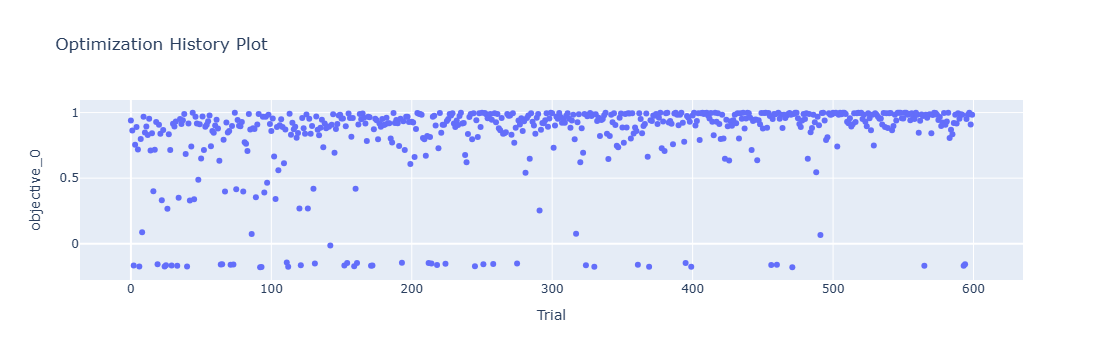

In [122]:
optuna.visualization.plot_optimization_history(study,target=lambda t: t.values[0], target_name='objective_0')

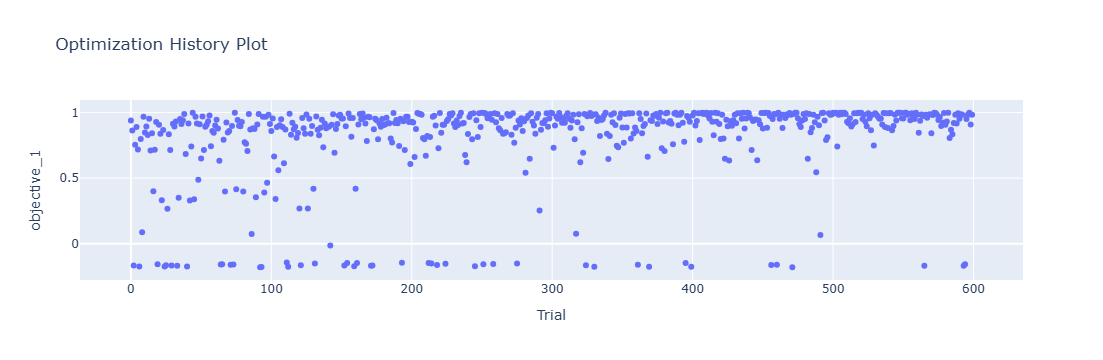

In [123]:
optuna.visualization.plot_optimization_history(study,target=lambda t: t.values[0], target_name='objective_1')

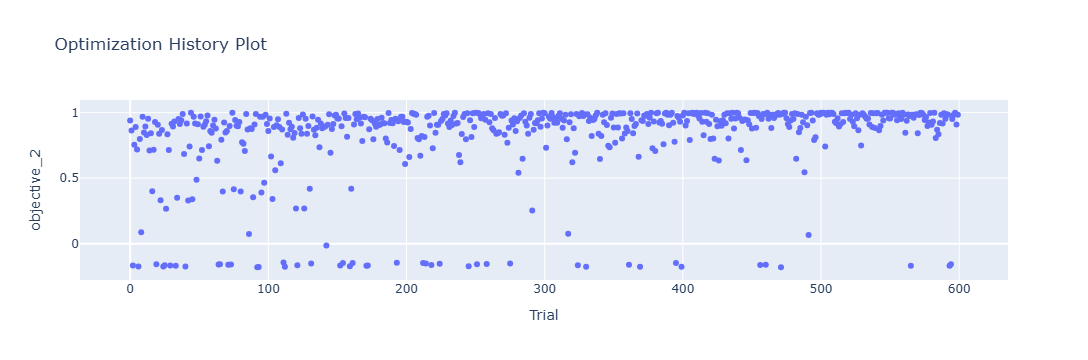

In [124]:
optuna.visualization.plot_optimization_history(study,target=lambda t: t.values[0], target_name='objective_2')

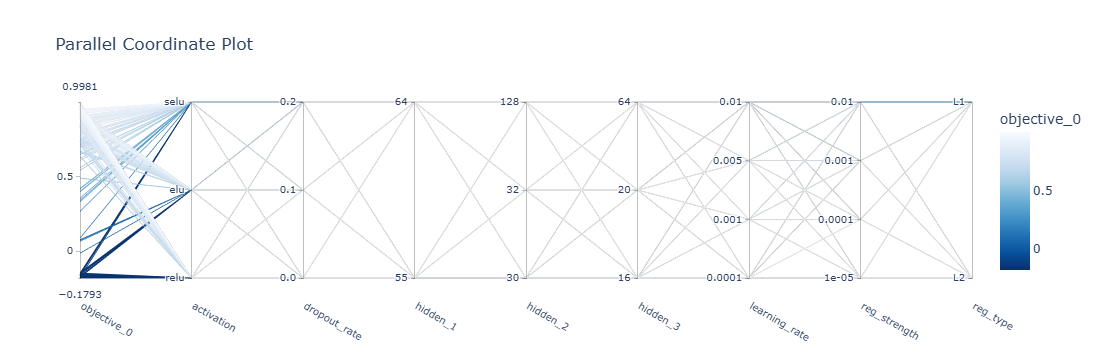

In [125]:
optuna.visualization.plot_parallel_coordinate(study,target=lambda t: t.values[0], target_name='objective_0')

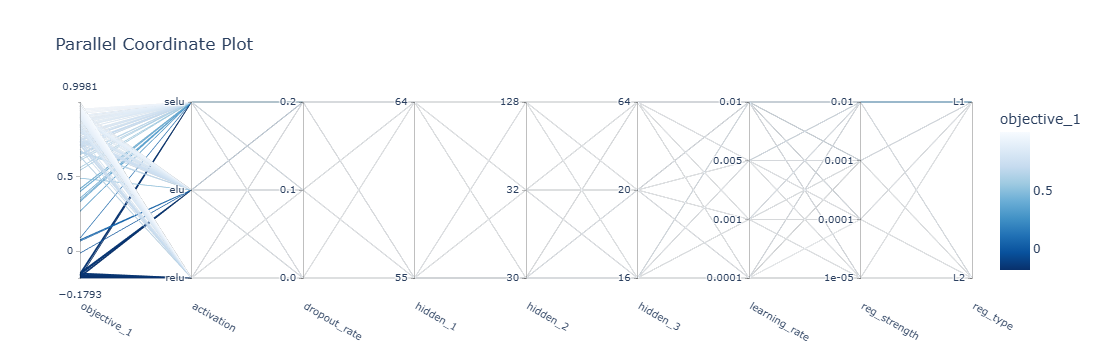

In [126]:
optuna.visualization.plot_parallel_coordinate(study,target=lambda t: t.values[1], target_name='objective_1')

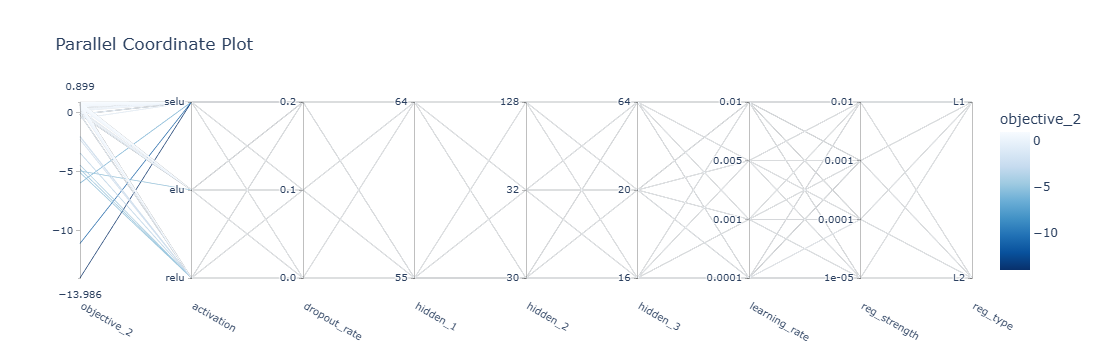

In [132]:
optuna.visualization.plot_parallel_coordinate(study,target=lambda t: t.values[2], target_name='objective_2')

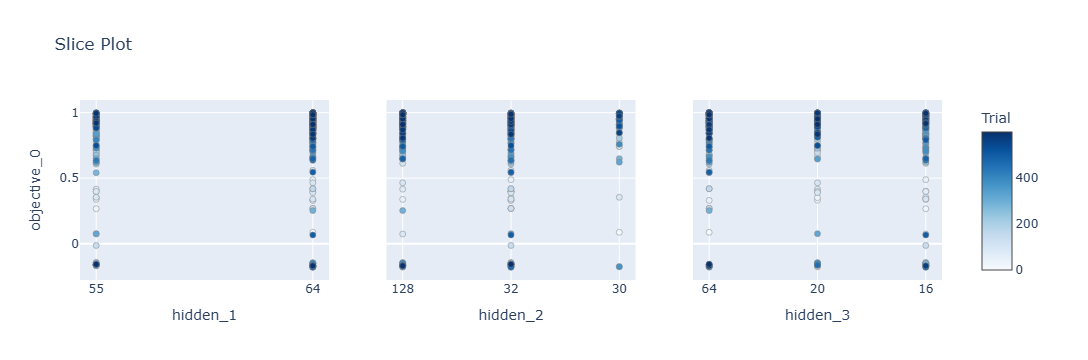

In [134]:
optuna.visualization.plot_slice(study,target=lambda t: t.values[0], target_name='objective_0', params=['hidden_1','hidden_2','hidden_3'])

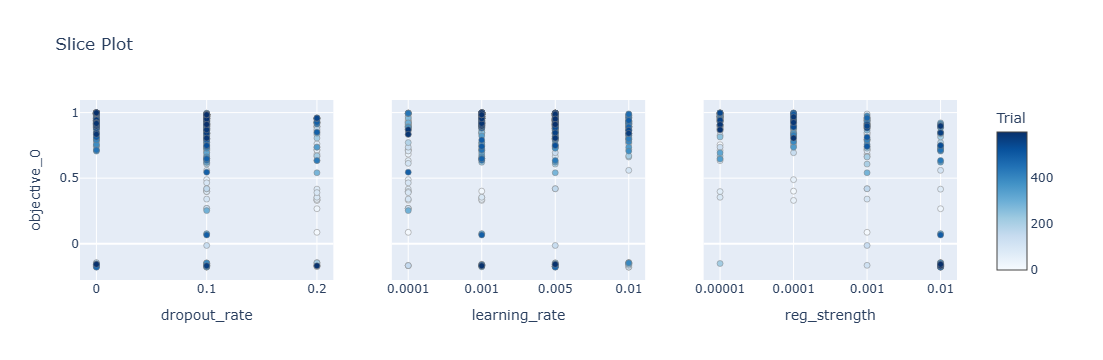

In [135]:
optuna.visualization.plot_slice(study,target=lambda t: t.values[0], target_name='objective_0', params=['dropout_rate','reg_strength','learning_rate'])

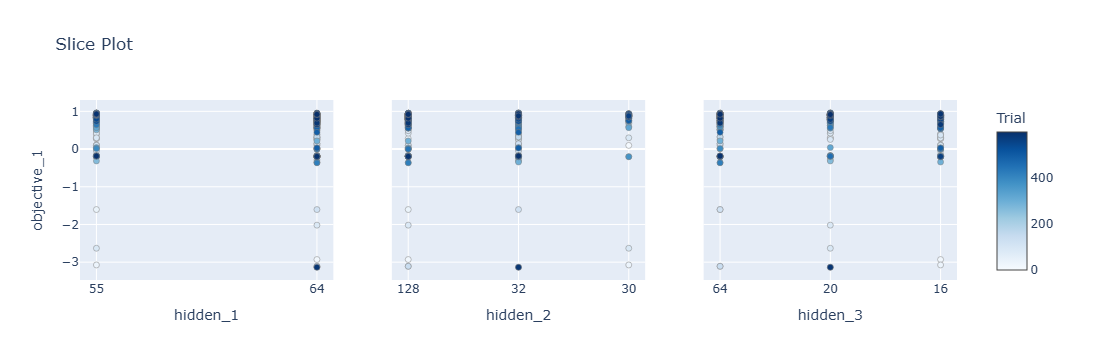

In [137]:
optuna.visualization.plot_slice(study,target=lambda t: t.values[1], target_name='objective_1', params=['hidden_1','hidden_2','hidden_3'])

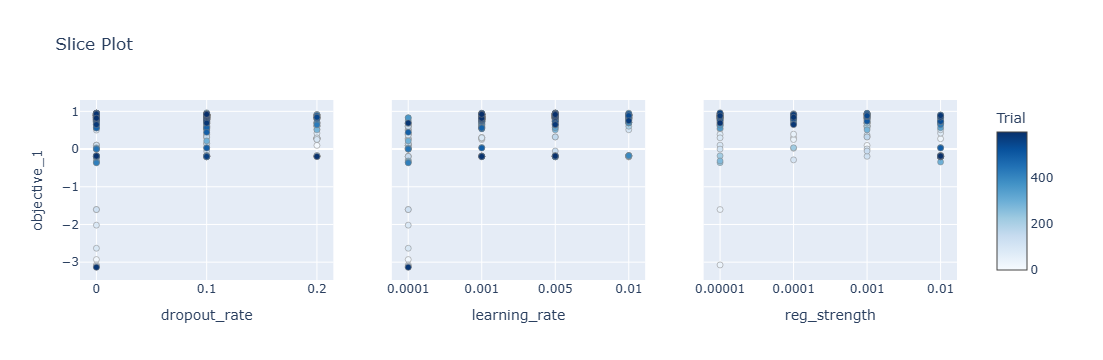

In [138]:
optuna.visualization.plot_slice(study,target=lambda t: t.values[1], target_name='objective_1', params=['dropout_rate','reg_strength','learning_rate'])

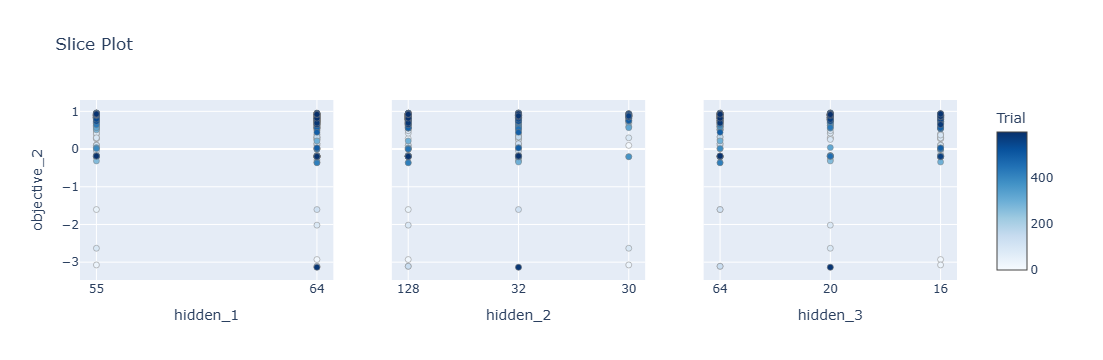

In [139]:
optuna.visualization.plot_slice(study,target=lambda t: t.values[1], target_name='objective_2', params=['hidden_1','hidden_2','hidden_3'])

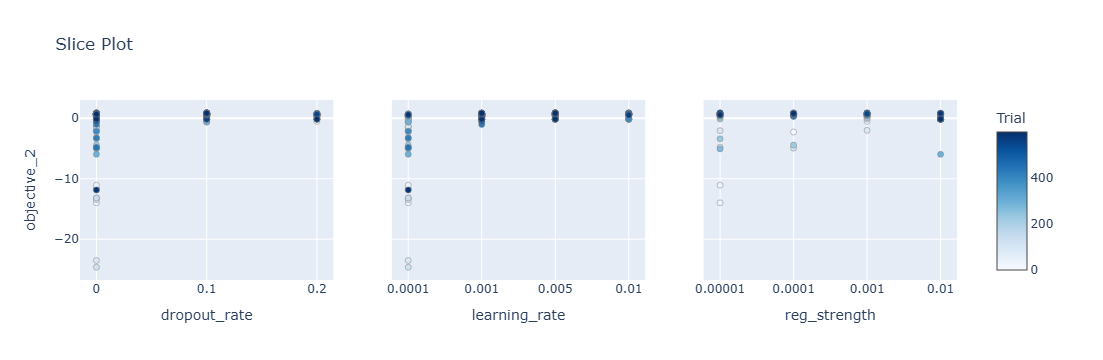

In [140]:
optuna.visualization.plot_slice(study,target=lambda t: t.values[2], target_name='objective_2', params=['dropout_rate','reg_strength','learning_rate'])

3/3 [==============================] - 0s 4ms/step
R2 scores:

Training set:  0.9150433997502856
Validation set:  0.9135880512639791
Test set:  0.8833317596263206

MAE (eV):

Training set:  0.010140237241775672
Validation set:  0.014214633466218183
Test set:  0.008597145802378683
3/3 [==============================] - 0s 5ms/step


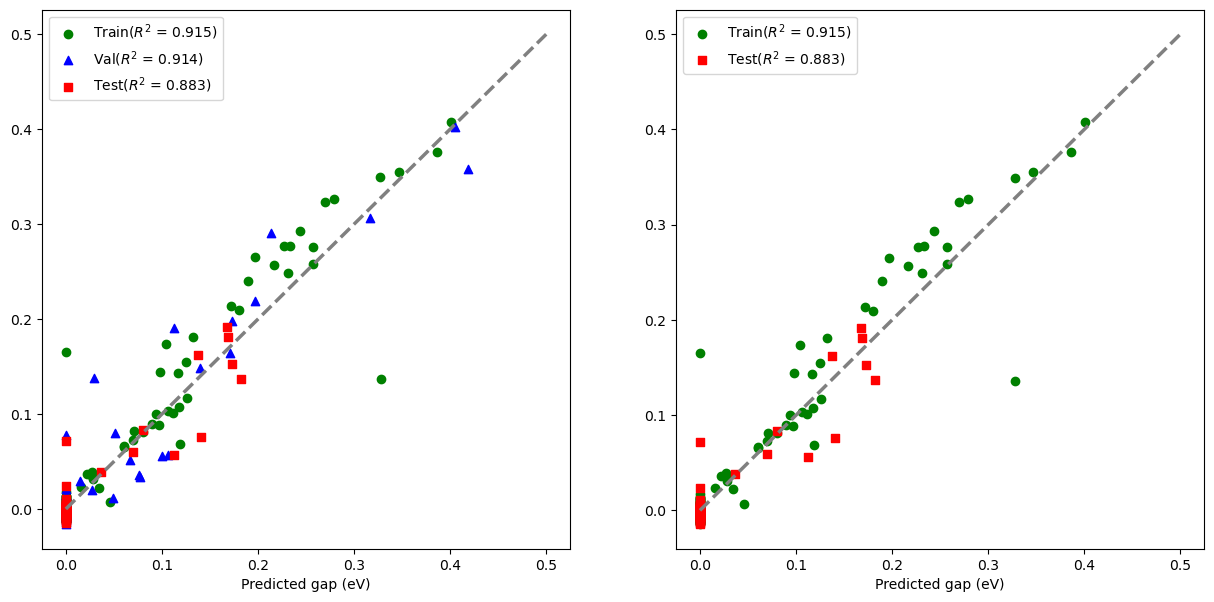

In [57]:
# Trial number: 30

import os
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Normalization layer
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_eg_train))

# Model definition
model_30 = tf.keras.Sequential([normalizer])
model_30.add(layers.Dense(64, activation='elu', kernel_regularizer=None))#regularizers.l2(0.0001)))
model_30.add(layers.Dropout(0.1, seed=SEED))
model_30.add(layers.Dense(32, activation='elu', kernel_regularizer=None))#regularizers.l2(0.0001)))
model_30.add(layers.Dropout(0.1, seed=SEED))
model_30.add(layers.Dense(64, activation='elu', kernel_regularizer=None))#regularizers.l2(0.0001)))
model_30.add(layers.Dropout(0.1, seed=SEED))
model_30.add(layers.Dense(1))

# Compile the model
model_30.compile(optimizer=tf.keras.optimizers.Adam(0.01), loss='mean_absolute_error')

# Train the model
history_30 = model_30.fit(X_eg_train, y_eg_train['57'], validation_data=(X_eg_val, y_eg_val['57']), epochs=500, verbose=0, shuffle=False)

# Evaluate the model
r2_train_30 = metrics.r2_score(y_eg_train['57'], model_30.predict(X_eg_train).flatten())
r2_val_30 = metrics.r2_score(y_eg_val['57'], model_30.predict(X_eg_val).flatten())
r2_test_30 = metrics.r2_score(y_eg_test['57'], model_30.predict(X_eg_test).flatten())

mae_train_30 = metrics.mean_absolute_error(y_eg_train['57'], model_30.predict(X_eg_train).flatten())
mae_val_30 = metrics.mean_absolute_error(y_eg_val['57'], model_30.predict(X_eg_val).flatten())
mae_test_30 = metrics.mean_absolute_error(y_eg_test['57'], model_30.predict(X_eg_test).flatten())

print('R2 scores:\n')
print('Training set: ',r2_train_30)
print('Validation set: ',r2_val_30)
print('Test set: ',r2_test_30)

print('\nMAE (eV):\n')
print('Training set: ',mae_train_30)
print('Validation set: ',mae_val_30)
print('Test set: ',mae_test_30)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,7))
ax1.scatter(y_eg_train['57'], model_30.predict(X_eg_train).flatten(),label='Train($R^2$ = '+str(f'{r2_train_30:.3f}')+')',marker='o',color='green')
ax1.scatter(y_eg_val['57'], model_30.predict(X_eg_val).flatten(),label='Val($R^2$ = '+str(f'{r2_val_30:.3f}')+')',marker='^',color='blue')
ax1.scatter(y_eg_test['57'], model_30.predict(X_eg_test).flatten(),label='Test($R^2$ = '+str(f'{r2_test_30:.3f}')+')',marker='s',color='red')
ax1.set_xlabel('Calculated gap (eV)')
ax1.set_xlabel('Predicted gap (eV)')
ax1.plot([0,0.5], [0,0.5],linewidth=2.5, color='gray', linestyle='dashed')
ax1.legend()

ax2.scatter(y_eg_train['57'], model_30.predict(X_eg_train).flatten(),label='Train($R^2$ = '+str(f'{r2_train_30:.3f}')+')',marker='o',color='green')
#ax2.scatter(y_eg_val['57'], model_30.predict(X_eg_val).flatten(),label='Val($R^2$ = '+str(f'{r2_val_30:.3f}')+')',marker='^',color='blue')
ax2.scatter(y_eg_test['57'], model_30.predict(X_eg_test).flatten(),label='Test($R^2$ = '+str(f'{r2_test_30:.3f}')+')',marker='s',color='red')
ax2.set_xlabel('Calculated gap (eV)')
ax2.set_xlabel('Predicted gap (eV)')
ax2.plot([0,0.5], [0,0.5],linewidth=2.5, color='gray', linestyle='dashed')
ax2.legend()
plt.show()

3/3 [==============================] - 0s 2ms/step
R2 scores:

Training set:  0.9226144124819204
Validation set:  0.9108792081360172
Test set:  0.5581102747371061

MAE (eV):

Training set:  0.017627675169792287
Validation set:  0.02019804321667976
Test set:  0.02316125577828711
3/3 [==============================] - 0s 0s/step


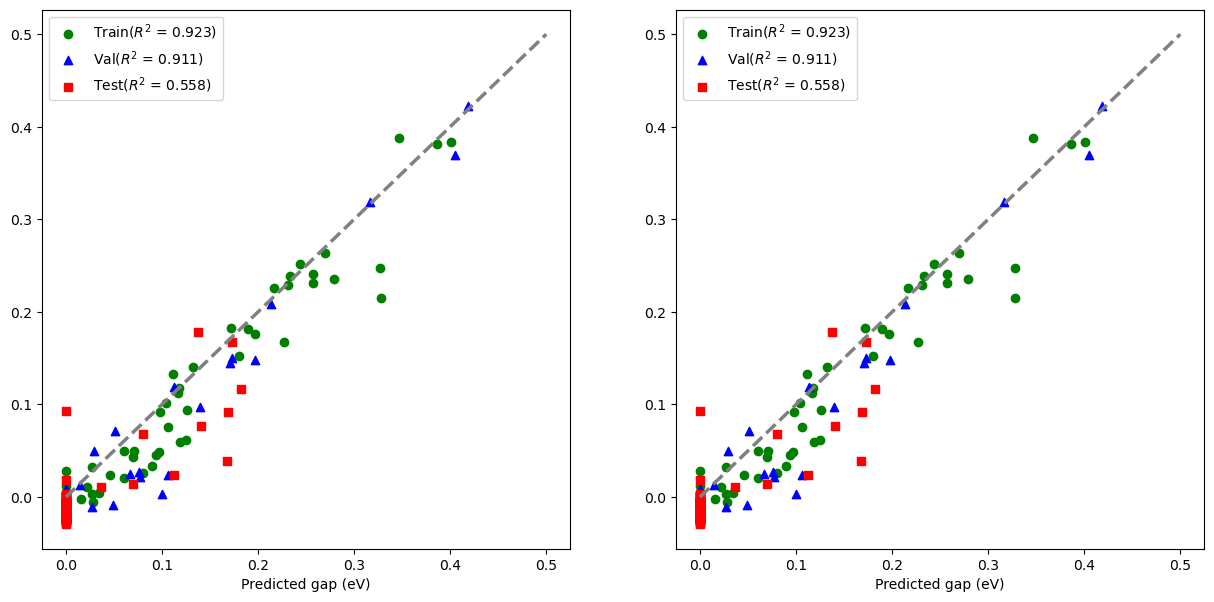

In [59]:
# Trial number: 30 for 1000 epochs

import os
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Normalization layer
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_eg_train))

# Model definition
model_30 = tf.keras.Sequential([normalizer])
model_30.add(layers.Dense(64, activation='elu', kernel_regularizer=None))#regularizers.l2(0.0001)))
model_30.add(layers.Dropout(0.1, seed=SEED))
model_30.add(layers.Dense(32, activation='elu', kernel_regularizer=None))#regularizers.l2(0.0001)))
model_30.add(layers.Dropout(0.1, seed=SEED))
model_30.add(layers.Dense(64, activation='elu', kernel_regularizer=None))#regularizers.l2(0.0001)))
model_30.add(layers.Dropout(0.1, seed=SEED))
model_30.add(layers.Dense(1))

# Compile the model
model_30.compile(optimizer=tf.keras.optimizers.Adam(0.01), loss='mean_absolute_error')

# Train the model
history_30 = model_30.fit(X_eg_train, y_eg_train['57'], validation_data=(X_eg_val, y_eg_val['57']), epochs=1000, verbose=0, shuffle=False)

# Evaluate the model
r2_train_30 = metrics.r2_score(y_eg_train['57'], model_30.predict(X_eg_train).flatten())
r2_val_30 = metrics.r2_score(y_eg_val['57'], model_30.predict(X_eg_val).flatten())
r2_test_30 = metrics.r2_score(y_eg_test['57'], model_30.predict(X_eg_test).flatten())

mae_train_30 = metrics.mean_absolute_error(y_eg_train['57'], model_30.predict(X_eg_train).flatten())
mae_val_30 = metrics.mean_absolute_error(y_eg_val['57'], model_30.predict(X_eg_val).flatten())
mae_test_30 = metrics.mean_absolute_error(y_eg_test['57'], model_30.predict(X_eg_test).flatten())

print('R2 scores:\n')
print('Training set: ',r2_train_30)
print('Validation set: ',r2_val_30)
print('Test set: ',r2_test_30)

print('\nMAE (eV):\n')
print('Training set: ',mae_train_30)
print('Validation set: ',mae_val_30)
print('Test set: ',mae_test_30)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,7))
ax1.scatter(y_eg_train['57'], model_30.predict(X_eg_train).flatten(),label='Train($R^2$ = '+str(f'{r2_train_30:.3f}')+')',marker='o',color='green')
ax1.scatter(y_eg_val['57'], model_30.predict(X_eg_val).flatten(),label='Val($R^2$ = '+str(f'{r2_val_30:.3f}')+')',marker='^',color='blue')
ax1.scatter(y_eg_test['57'], model_30.predict(X_eg_test).flatten(),label='Test($R^2$ = '+str(f'{r2_test_30:.3f}')+')',marker='s',color='red')
ax1.set_xlabel('Calculated gap (eV)')
ax1.set_xlabel('Predicted gap (eV)')
ax1.plot([0,0.5], [0,0.5],linewidth=2.5, color='gray', linestyle='dashed')
ax1.legend()

ax2.scatter(y_eg_train['57'], model_30.predict(X_eg_train).flatten(),label='Train($R^2$ = '+str(f'{r2_train_30:.3f}')+')',marker='o',color='green')
ax2.scatter(y_eg_val['57'], model_30.predict(X_eg_val).flatten(),label='Val($R^2$ = '+str(f'{r2_val_30:.3f}')+')',marker='^',color='blue')
ax2.scatter(y_eg_test['57'], model_30.predict(X_eg_test).flatten(),label='Test($R^2$ = '+str(f'{r2_test_30:.3f}')+')',marker='s',color='red')
ax2.set_xlabel('Calculated gap (eV)')
ax2.set_xlabel('Predicted gap (eV)')
ax2.plot([0,0.5], [0,0.5],linewidth=2.5, color='gray', linestyle='dashed')
ax2.legend()
plt.show()

3/3 [==============================] - 0s 2ms/step
R2 scores:

Training set:  0.9833479033473794
Validation set:  0.920453561280819
Test set:  0.8265206330734058

MAE (eV):

Training set:  0.0035702065267981305
Validation set:  0.009950347046038123
Test set:  0.006163621262640226
3/3 [==============================] - 0s 3ms/step


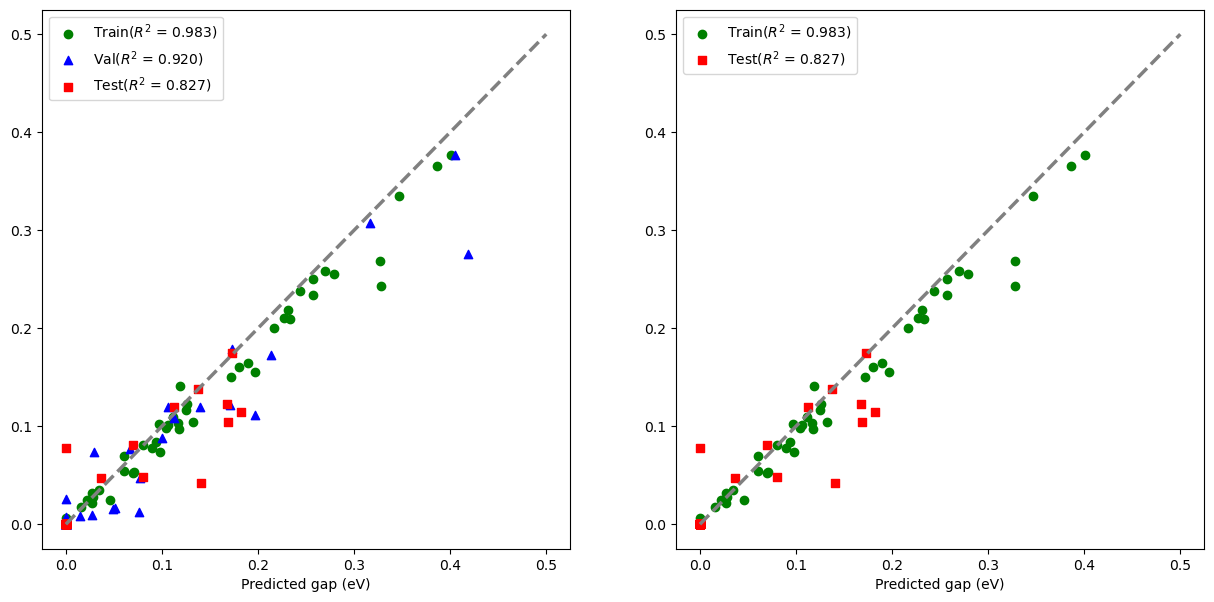

In [101]:
# Trial number: 98

import os
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Normalization layer
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_eg_train))

# Model definition
model_98 = tf.keras.Sequential([normalizer])
model_98.add(layers.Dense(64, activation='relu', kernel_regularizer=None))#regularizers.l2(0.0001)))
model_98.add(layers.Dropout(0.1, seed=SEED))
model_98.add(layers.Dense(128, activation='relu', kernel_regularizer=None))#regularizers.l2(0.0001)))
model_98.add(layers.Dropout(0.1, seed=SEED))
model_98.add(layers.Dense(64, activation='relu', kernel_regularizer=None))#regularizers.l2(0.0001)))
model_98.add(layers.Dropout(0.1, seed=SEED))
model_98.add(layers.Dense(1))

# Compile the model
model_98.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='mean_absolute_error')

# Train the model
history_98 = model_98.fit(X_eg_train, y_eg_train['57'], validation_data=(X_eg_val, y_eg_val['57']), epochs=500, verbose=0, shuffle=False)

# Evaluate the model
r2_train_98 = metrics.r2_score(y_eg_train['57'], model_98.predict(X_eg_train).flatten())
r2_val_98 = metrics.r2_score(y_eg_val['57'], model_98.predict(X_eg_val).flatten())
r2_test_98 = metrics.r2_score(y_eg_test['57'], model_98.predict(X_eg_test).flatten())

mae_train_98 = metrics.mean_absolute_error(y_eg_train['57'], model_98.predict(X_eg_train).flatten())
mae_val_98 = metrics.mean_absolute_error(y_eg_val['57'], model_98.predict(X_eg_val).flatten())
mae_test_98 = metrics.mean_absolute_error(y_eg_test['57'], model_98.predict(X_eg_test).flatten())

print('R2 scores:\n')
print('Training set: ',r2_train_98)
print('Validation set: ',r2_val_98)
print('Test set: ',r2_test_98)

print('\nMAE (eV):\n')
print('Training set: ',mae_train_98)
print('Validation set: ',mae_val_98)
print('Test set: ',mae_test_98)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,7))
ax1.scatter(y_eg_train['57'], model_98.predict(X_eg_train).flatten(),label='Train($R^2$ = '+str(f'{r2_train_98:.3f}')+')',marker='o',color='green')
ax1.scatter(y_eg_val['57'], model_98.predict(X_eg_val).flatten(),label='Val($R^2$ = '+str(f'{r2_val_98:.3f}')+')',marker='^',color='blue')
ax1.scatter(y_eg_test['57'], model_98.predict(X_eg_test).flatten(),label='Test($R^2$ = '+str(f'{r2_test_98:.3f}')+')',marker='s',color='red')
ax1.set_xlabel('Calculated gap (eV)')
ax1.set_xlabel('Predicted gap (eV)')
ax1.plot([0,0.5], [0,0.5],linewidth=2.5, color='gray', linestyle='dashed')
ax1.legend()

ax2.scatter(y_eg_train['57'], model_98.predict(X_eg_train).flatten(),label='Train($R^2$ = '+str(f'{r2_train_98:.3f}')+')',marker='o',color='green')
ax2.scatter(y_eg_test['57'], model_98.predict(X_eg_test).flatten(),label='Test($R^2$ = '+str(f'{r2_test_98:.3f}')+')',marker='s',color='red')
ax2.set_xlabel('Calculated gap (eV)')
ax2.set_xlabel('Predicted gap (eV)')
ax2.plot([0,0.5], [0,0.5],linewidth=2.5, color='gray', linestyle='dashed')
ax2.legend()
plt.show()

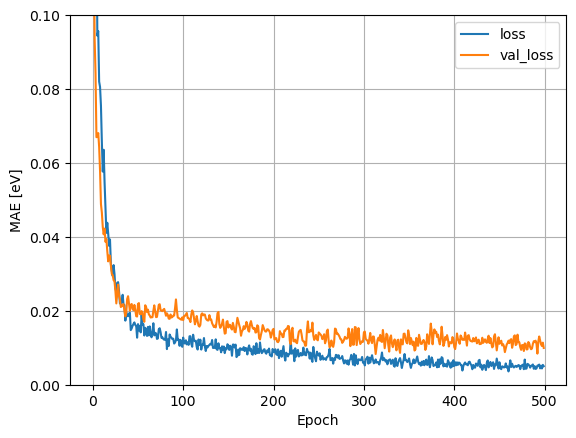

In [102]:
plt.plot(history_98.history['loss'], label='loss')
plt.plot(history_98.history['val_loss'], label='val_loss')
plt.ylim([0, 0.1])
plt.xlabel('Epoch')
plt.ylabel('MAE [eV]')
plt.legend()
plt.grid(True)

In [103]:
model_98.save(f'Results_Eg/model_98_optuna')

with open(f'Results_Eg/model_98_optuna.pkl', 'wb') as f:
    pickle.dump(history_98.history, f)

INFO:tensorflow:Assets written to: Results_Eg/Optuna/model_98_optuna\assets


INFO:tensorflow:Assets written to: Results_Eg/Optuna/model_98_optuna\assets


In [104]:
y_pred_98_train = model_98.predict(X_eg_train)
y_pred_98_val = model_98.predict(X_eg_val)
y_pred_98_test = model_98.predict(X_eg_test)

pd.DataFrame(y_pred_98_train).to_csv('Results_Eg/y_pred_98_train.csv',index=False)
pd.DataFrame(y_pred_98_val).to_csv('Results_Eg/y_pred_98_val.csv',index=False)
pd.DataFrame(y_pred_98_test).to_csv('Results_Eg/y_pred_98_test.csv',index=False)

3/3 [==============================] - 0s 8ms/step


3/3 [==============================] - 0s 0s/step
R2 scores:

Training set:  0.9861945927692579
Validation set:  0.9285645545021745
Test set:  0.7502771574622101

MAE (eV):

Training set:  0.0031012372105366716
Validation set:  0.009992479835043755
Test set:  0.007763923398085144
3/3 [==============================] - 0s 0s/step


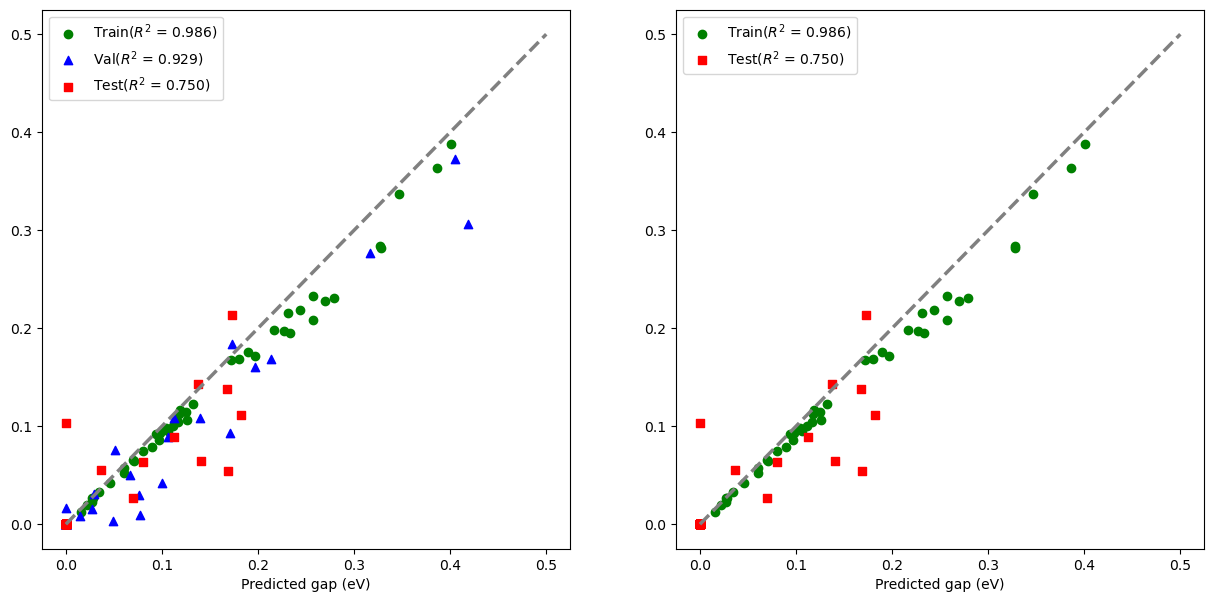

In [60]:
# Trial number: 98 for 1000 epochs

import os
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Normalization layer
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_eg_train))

# Model definition
model_98 = tf.keras.Sequential([normalizer])
model_98.add(layers.Dense(64, activation='relu', kernel_regularizer=None))#regularizers.l2(0.0001)))
model_98.add(layers.Dropout(0.1, seed=SEED))
model_98.add(layers.Dense(128, activation='relu', kernel_regularizer=None))#regularizers.l2(0.0001)))
model_98.add(layers.Dropout(0.1, seed=SEED))
model_98.add(layers.Dense(64, activation='relu', kernel_regularizer=None))#regularizers.l2(0.0001)))
model_98.add(layers.Dropout(0.1, seed=SEED))
model_98.add(layers.Dense(1))

# Compile the model
model_98.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='mean_absolute_error')

# Train the model
history_98 = model_98.fit(X_eg_train, y_eg_train['57'], validation_data=(X_eg_val, y_eg_val['57']), epochs=1000, verbose=0, shuffle=False)

# Evaluate the model
r2_train_98 = metrics.r2_score(y_eg_train['57'], model_98.predict(X_eg_train).flatten())
r2_val_98 = metrics.r2_score(y_eg_val['57'], model_98.predict(X_eg_val).flatten())
r2_test_98 = metrics.r2_score(y_eg_test['57'], model_98.predict(X_eg_test).flatten())

mae_train_98 = metrics.mean_absolute_error(y_eg_train['57'], model_98.predict(X_eg_train).flatten())
mae_val_98 = metrics.mean_absolute_error(y_eg_val['57'], model_98.predict(X_eg_val).flatten())
mae_test_98 = metrics.mean_absolute_error(y_eg_test['57'], model_98.predict(X_eg_test).flatten())

print('R2 scores:\n')
print('Training set: ',r2_train_98)
print('Validation set: ',r2_val_98)
print('Test set: ',r2_test_98)

print('\nMAE (eV):\n')
print('Training set: ',mae_train_98)
print('Validation set: ',mae_val_98)
print('Test set: ',mae_test_98)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,7))
ax1.scatter(y_eg_train['57'], model_98.predict(X_eg_train).flatten(),label='Train($R^2$ = '+str(f'{r2_train_98:.3f}')+')',marker='o',color='green')
ax1.scatter(y_eg_val['57'], model_98.predict(X_eg_val).flatten(),label='Val($R^2$ = '+str(f'{r2_val_98:.3f}')+')',marker='^',color='blue')
ax1.scatter(y_eg_test['57'], model_98.predict(X_eg_test).flatten(),label='Test($R^2$ = '+str(f'{r2_test_98:.3f}')+')',marker='s',color='red')
ax1.set_xlabel('Calculated gap (eV)')
ax1.set_xlabel('Predicted gap (eV)')
ax1.plot([0,0.5], [0,0.5],linewidth=2.5, color='gray', linestyle='dashed')
ax1.legend()

ax2.scatter(y_eg_train['57'], model_98.predict(X_eg_train).flatten(),label='Train($R^2$ = '+str(f'{r2_train_98:.3f}')+')',marker='o',color='green')
ax2.scatter(y_eg_test['57'], model_98.predict(X_eg_test).flatten(),label='Test($R^2$ = '+str(f'{r2_test_98:.3f}')+')',marker='s',color='red')
ax2.set_xlabel('Calculated gap (eV)')
ax2.set_xlabel('Predicted gap (eV)')
ax2.plot([0,0.5], [0,0.5],linewidth=2.5, color='gray', linestyle='dashed')
ax2.legend()
plt.show()

3/3 [==============================] - 0s 0s/step
R2 scores:

Training set:  0.9067318722428914
Validation set:  0.9266052788601143
Test set:  0.8858894809077198

MAE (eV):

Training set:  0.011753428274299918
Validation set:  0.013932566427375542
Test set:  0.010609350138498204
3/3 [==============================] - 0s 0s/step


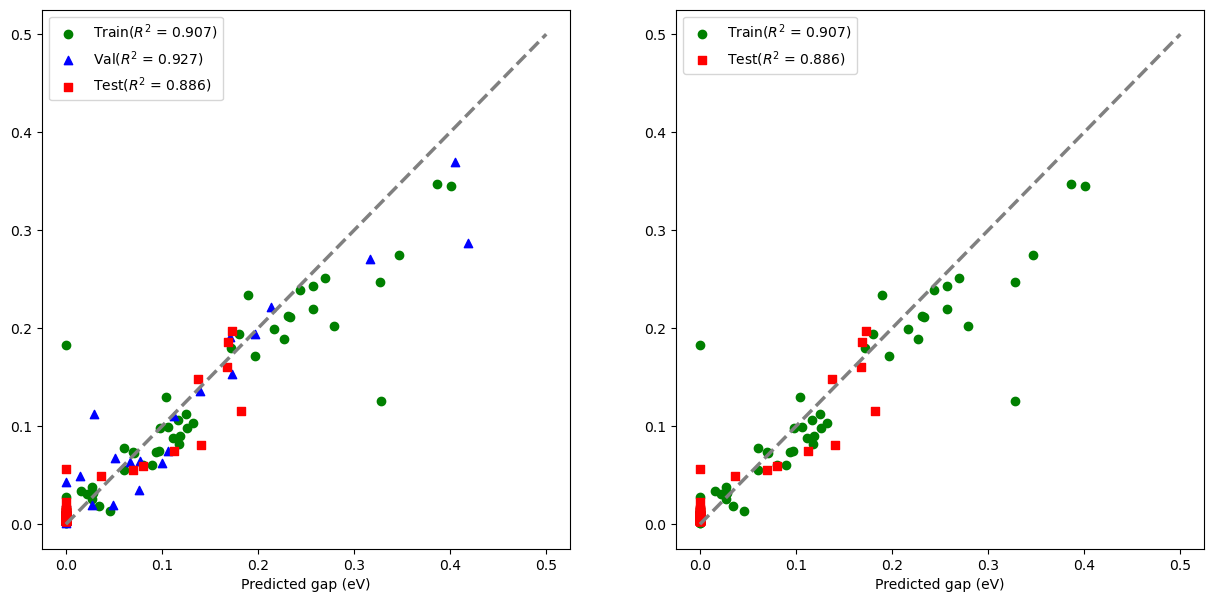

In [61]:
# Trial number: 143

import os
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Normalization layer
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_eg_train))

# Model definition
model_143 = tf.keras.Sequential([normalizer])
model_143.add(layers.Dense(64, activation='elu', kernel_regularizer=regularizers.l2(0.00001)))
model_143.add(layers.Dropout(0.1, seed=SEED))
model_143.add(layers.Dense(32, activation='elu', kernel_regularizer=regularizers.l2(0.00001)))
model_143.add(layers.Dropout(0.1, seed=SEED))
model_143.add(layers.Dense(20, activation= 'elu', kernel_regularizer=regularizers.l2(0.00001)))
model_143.add(layers.Dropout(0.1, seed=SEED))
model_143.add(layers.Dense(1))

# Compile the model
model_143.compile(optimizer=tf.keras.optimizers.Adam(0.005), loss='mean_absolute_error')

# Train the model
history_143 = model_143.fit(X_eg_train, y_eg_train['57'], validation_data=(X_eg_val, y_eg_val['57']), epochs=500, verbose=0, shuffle=False)

# Evaluate the model
r2_train_143 = metrics.r2_score(y_eg_train['57'], model_143.predict(X_eg_train).flatten())
r2_val_143 = metrics.r2_score(y_eg_val['57'], model_143.predict(X_eg_val).flatten())
r2_test_143 = metrics.r2_score(y_eg_test['57'], model_143.predict(X_eg_test).flatten())

mae_train_143 = metrics.mean_absolute_error(y_eg_train['57'], model_143.predict(X_eg_train).flatten())
mae_val_143 = metrics.mean_absolute_error(y_eg_val['57'], model_143.predict(X_eg_val).flatten())
mae_test_143 = metrics.mean_absolute_error(y_eg_test['57'], model_143.predict(X_eg_test).flatten())

print('R2 scores:\n')
print('Training set: ',r2_train_143)
print('Validation set: ',r2_val_143)
print('Test set: ',r2_test_143)

print('\nMAE (eV):\n')
print('Training set: ',mae_train_143)
print('Validation set: ',mae_val_143)
print('Test set: ',mae_test_143)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,7))
ax1.scatter(y_eg_train['57'], model_143.predict(X_eg_train).flatten(),label='Train($R^2$ = '+str(f'{r2_train_143:.3f}')+')',marker='o',color='green')
ax1.scatter(y_eg_val['57'], model_143.predict(X_eg_val).flatten(),label='Val($R^2$ = '+str(f'{r2_val_143:.3f}')+')',marker='^',color='blue')
ax1.scatter(y_eg_test['57'], model_143.predict(X_eg_test).flatten(),label='Test($R^2$ = '+str(f'{r2_test_143:.3f}')+')',marker='s',color='red')
ax1.set_xlabel('Calculated gap (eV)')
ax1.set_xlabel('Predicted gap (eV)')
ax1.plot([0,0.5], [0,0.5],linewidth=2.5, color='gray', linestyle='dashed')
ax1.legend()

ax2.scatter(y_eg_train['57'], model_143.predict(X_eg_train).flatten(),label='Train($R^2$ = '+str(f'{r2_train_143:.3f}')+')',marker='o',color='green')
ax2.scatter(y_eg_test['57'], model_143.predict(X_eg_test).flatten(),label='Test($R^2$ = '+str(f'{r2_test_143:.3f}')+')',marker='s',color='red')
ax2.set_xlabel('Calculated gap (eV)')
ax2.set_xlabel('Predicted gap (eV)')
ax2.plot([0,0.5], [0,0.5],linewidth=2.5, color='gray', linestyle='dashed')
ax2.legend()
plt.show()

3/3 [==============================] - 0s 0s/step
R2 scores:

Training set:  0.9250782082813807
Validation set:  0.9304156216544086
Test set:  0.8012230208109814

MAE (eV):

Training set:  0.011508217215398318
Validation set:  0.015772458431805865
Test set:  0.014578837477405156
3/3 [==============================] - 0s 3ms/step


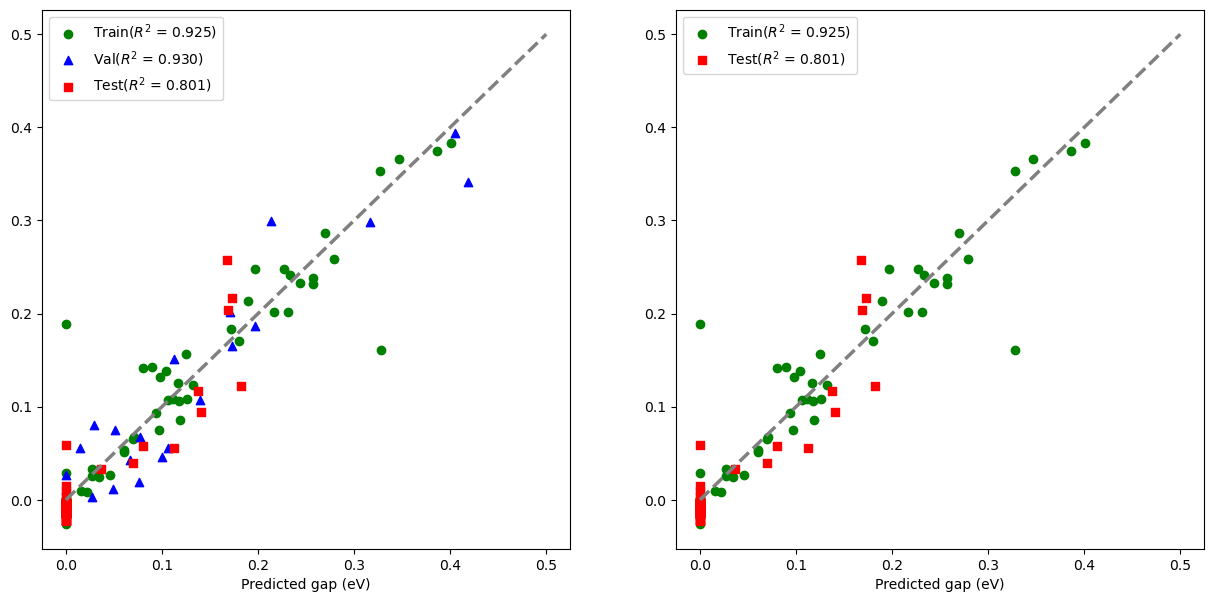

In [62]:
# Trial number: 143 for 1000 epochs

import os
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Normalization layer
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_eg_train))

# Model definition
model_143 = tf.keras.Sequential([normalizer])
model_143.add(layers.Dense(64, activation='elu', kernel_regularizer=regularizers.l2(0.00001)))
model_143.add(layers.Dropout(0.1, seed=SEED))
model_143.add(layers.Dense(32, activation='elu', kernel_regularizer=regularizers.l2(0.00001)))
model_143.add(layers.Dropout(0.1, seed=SEED))
model_143.add(layers.Dense(20, activation= 'elu', kernel_regularizer=regularizers.l2(0.00001)))
model_143.add(layers.Dropout(0.1, seed=SEED))
model_143.add(layers.Dense(1))

# Compile the model
model_143.compile(optimizer=tf.keras.optimizers.Adam(0.005), loss='mean_absolute_error')

# Train the model
history_143 = model_143.fit(X_eg_train, y_eg_train['57'], validation_data=(X_eg_val, y_eg_val['57']), epochs=1000, verbose=0, shuffle=False)

# Evaluate the model
r2_train_143 = metrics.r2_score(y_eg_train['57'], model_143.predict(X_eg_train).flatten())
r2_val_143 = metrics.r2_score(y_eg_val['57'], model_143.predict(X_eg_val).flatten())
r2_test_143 = metrics.r2_score(y_eg_test['57'], model_143.predict(X_eg_test).flatten())

mae_train_143 = metrics.mean_absolute_error(y_eg_train['57'], model_143.predict(X_eg_train).flatten())
mae_val_143 = metrics.mean_absolute_error(y_eg_val['57'], model_143.predict(X_eg_val).flatten())
mae_test_143 = metrics.mean_absolute_error(y_eg_test['57'], model_143.predict(X_eg_test).flatten())

print('R2 scores:\n')
print('Training set: ',r2_train_143)
print('Validation set: ',r2_val_143)
print('Test set: ',r2_test_143)

print('\nMAE (eV):\n')
print('Training set: ',mae_train_143)
print('Validation set: ',mae_val_143)
print('Test set: ',mae_test_143)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,7))
ax1.scatter(y_eg_train['57'], model_143.predict(X_eg_train).flatten(),label='Train($R^2$ = '+str(f'{r2_train_143:.3f}')+')',marker='o',color='green')
ax1.scatter(y_eg_val['57'], model_143.predict(X_eg_val).flatten(),label='Val($R^2$ = '+str(f'{r2_val_143:.3f}')+')',marker='^',color='blue')
ax1.scatter(y_eg_test['57'], model_143.predict(X_eg_test).flatten(),label='Test($R^2$ = '+str(f'{r2_test_143:.3f}')+')',marker='s',color='red')
ax1.set_xlabel('Calculated gap (eV)')
ax1.set_xlabel('Predicted gap (eV)')
ax1.plot([0,0.5], [0,0.5],linewidth=2.5, color='gray', linestyle='dashed')
ax1.legend()

ax2.scatter(y_eg_train['57'], model_143.predict(X_eg_train).flatten(),label='Train($R^2$ = '+str(f'{r2_train_143:.3f}')+')',marker='o',color='green')
ax2.scatter(y_eg_test['57'], model_143.predict(X_eg_test).flatten(),label='Test($R^2$ = '+str(f'{r2_test_143:.3f}')+')',marker='s',color='red')
ax2.set_xlabel('Calculated gap (eV)')
ax2.set_xlabel('Predicted gap (eV)')
ax2.plot([0,0.5], [0,0.5],linewidth=2.5, color='gray', linestyle='dashed')
ax2.legend()
plt.show()

3/3 [==============================] - 0s 8ms/step
R2 scores:

Training set:  0.990010824630745
Validation set:  0.9303390372092617
Test set:  0.8194337458098349

MAE (eV):

Training set:  0.002442677298761802
Validation set:  0.010607556308050195
Test set:  0.007306041449730789
3/3 [==============================] - 0s 0s/step


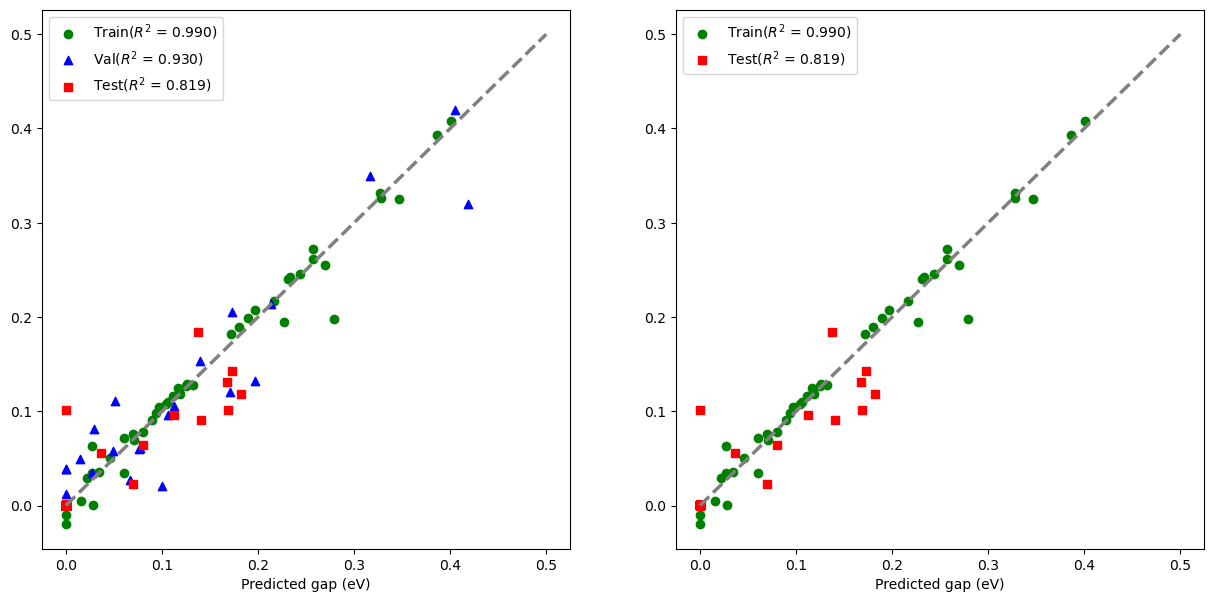

In [63]:
# Trial number: 261

import os
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Normalization layer
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_eg_train))

# Model definition
model_261 = tf.keras.Sequential([normalizer])
model_261.add(layers.Dense(64, activation='relu', kernel_regularizer=None))#regularizers.l2(0.00001)))
model_261.add(layers.Dropout(0.0, seed=SEED))
model_261.add(layers.Dense(32, activation='relu', kernel_regularizer=None))#regularizers.l2(0.00001)))
model_261.add(layers.Dropout(0.0, seed=SEED))
model_261.add(layers.Dense(20, activation= 'relu', kernel_regularizer=None))#regularizers.l2(0.00001)))
model_261.add(layers.Dropout(0.0, seed=SEED))
model_261.add(layers.Dense(1))

# Compile the model
model_261.compile(optimizer=tf.keras.optimizers.Adam(0.005), loss='mean_absolute_error')

# Train the model
history_261 = model_261.fit(X_eg_train, y_eg_train['57'], validation_data=(X_eg_val, y_eg_val['57']), epochs=500, verbose=0, shuffle=False)

# Evaluate the model
r2_train_261 = metrics.r2_score(y_eg_train['57'], model_261.predict(X_eg_train).flatten())
r2_val_261 = metrics.r2_score(y_eg_val['57'], model_261.predict(X_eg_val).flatten())
r2_test_261 = metrics.r2_score(y_eg_test['57'], model_261.predict(X_eg_test).flatten())

mae_train_261 = metrics.mean_absolute_error(y_eg_train['57'], model_261.predict(X_eg_train).flatten())
mae_val_261 = metrics.mean_absolute_error(y_eg_val['57'], model_261.predict(X_eg_val).flatten())
mae_test_261 = metrics.mean_absolute_error(y_eg_test['57'], model_261.predict(X_eg_test).flatten())

print('R2 scores:\n')
print('Training set: ',r2_train_261)
print('Validation set: ',r2_val_261)
print('Test set: ',r2_test_261)

print('\nMAE (eV):\n')
print('Training set: ',mae_train_261)
print('Validation set: ',mae_val_261)
print('Test set: ',mae_test_261)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,7))
ax1.scatter(y_eg_train['57'], model_261.predict(X_eg_train).flatten(),label='Train($R^2$ = '+str(f'{r2_train_261:.3f}')+')',marker='o',color='green')
ax1.scatter(y_eg_val['57'], model_261.predict(X_eg_val).flatten(),label='Val($R^2$ = '+str(f'{r2_val_261:.3f}')+')',marker='^',color='blue')
ax1.scatter(y_eg_test['57'], model_261.predict(X_eg_test).flatten(),label='Test($R^2$ = '+str(f'{r2_test_261:.3f}')+')',marker='s',color='red')
ax1.set_xlabel('Calculated gap (eV)')
ax1.set_xlabel('Predicted gap (eV)')
ax1.plot([0,0.5], [0,0.5],linewidth=2.5, color='gray', linestyle='dashed')
ax1.legend()

ax2.scatter(y_eg_train['57'], model_261.predict(X_eg_train).flatten(),label='Train($R^2$ = '+str(f'{r2_train_261:.3f}')+')',marker='o',color='green')
ax2.scatter(y_eg_test['57'], model_261.predict(X_eg_test).flatten(),label='Test($R^2$ = '+str(f'{r2_test_261:.3f}')+')',marker='s',color='red')
ax2.set_xlabel('Calculated gap (eV)')
ax2.set_xlabel('Predicted gap (eV)')
ax2.plot([0,0.5], [0,0.5],linewidth=2.5, color='gray', linestyle='dashed')
ax2.legend()
plt.show()

3/3 [==============================] - 0s 0s/step
R2 scores:

Training set:  0.9955979691636665
Validation set:  0.8875942031771583
Test set:  0.850871925620365

MAE (eV):

Training set:  0.0033950104400802187
Validation set:  0.013512352650703096
Test set:  0.00812692902481979
3/3 [==============================] - 0s 2ms/step


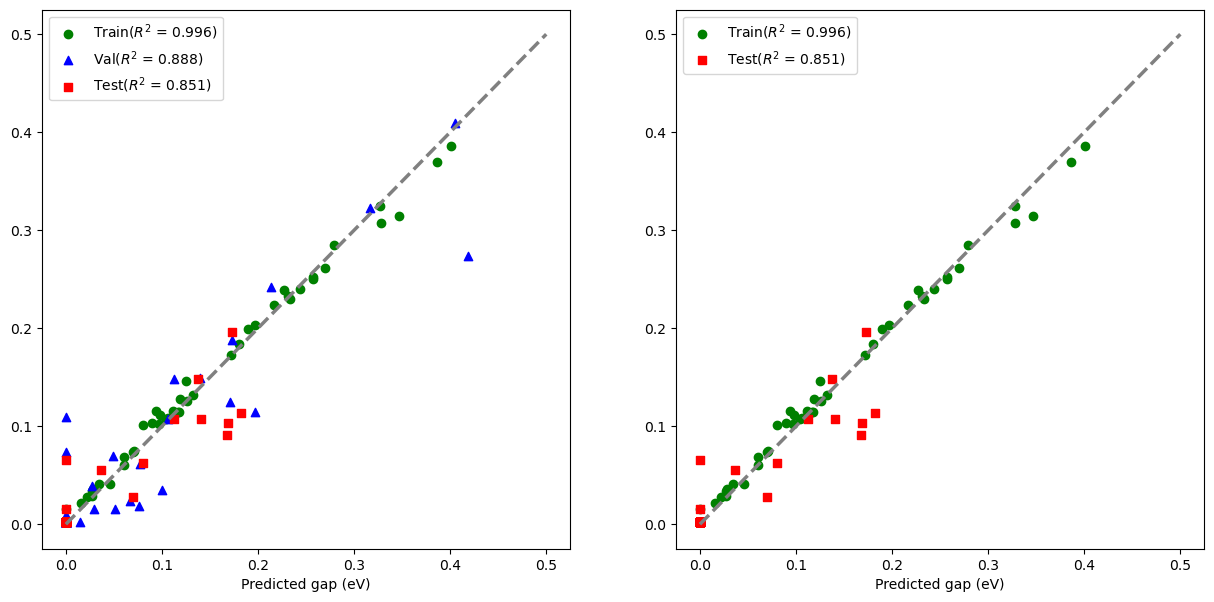

In [64]:
# Trial number: 261 for 1000 epochs

import os
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Normalization layer
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_eg_train))

# Model definition
model_261 = tf.keras.Sequential([normalizer])
model_261.add(layers.Dense(64, activation='relu', kernel_regularizer=None))#regularizers.l2(0.00001)))
model_261.add(layers.Dropout(0.0, seed=SEED))
model_261.add(layers.Dense(32, activation='relu', kernel_regularizer=None))#regularizers.l2(0.00001)))
model_261.add(layers.Dropout(0.0, seed=SEED))
model_261.add(layers.Dense(20, activation= 'relu', kernel_regularizer=None))#regularizers.l2(0.00001)))
model_261.add(layers.Dropout(0.0, seed=SEED))
model_261.add(layers.Dense(1))

# Compile the model
model_261.compile(optimizer=tf.keras.optimizers.Adam(0.005), loss='mean_absolute_error')

# Train the model
history_261 = model_261.fit(X_eg_train, y_eg_train['57'], validation_data=(X_eg_val, y_eg_val['57']), epochs=1000, verbose=0, shuffle=False)

# Evaluate the model
r2_train_261 = metrics.r2_score(y_eg_train['57'], model_261.predict(X_eg_train).flatten())
r2_val_261 = metrics.r2_score(y_eg_val['57'], model_261.predict(X_eg_val).flatten())
r2_test_261 = metrics.r2_score(y_eg_test['57'], model_261.predict(X_eg_test).flatten())

mae_train_261 = metrics.mean_absolute_error(y_eg_train['57'], model_261.predict(X_eg_train).flatten())
mae_val_261 = metrics.mean_absolute_error(y_eg_val['57'], model_261.predict(X_eg_val).flatten())
mae_test_261 = metrics.mean_absolute_error(y_eg_test['57'], model_261.predict(X_eg_test).flatten())

print('R2 scores:\n')
print('Training set: ',r2_train_261)
print('Validation set: ',r2_val_261)
print('Test set: ',r2_test_261)

print('\nMAE (eV):\n')
print('Training set: ',mae_train_261)
print('Validation set: ',mae_val_261)
print('Test set: ',mae_test_261)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,7))
ax1.scatter(y_eg_train['57'], model_261.predict(X_eg_train).flatten(),label='Train($R^2$ = '+str(f'{r2_train_261:.3f}')+')',marker='o',color='green')
ax1.scatter(y_eg_val['57'], model_261.predict(X_eg_val).flatten(),label='Val($R^2$ = '+str(f'{r2_val_261:.3f}')+')',marker='^',color='blue')
ax1.scatter(y_eg_test['57'], model_261.predict(X_eg_test).flatten(),label='Test($R^2$ = '+str(f'{r2_test_261:.3f}')+')',marker='s',color='red')
ax1.set_xlabel('Calculated gap (eV)')
ax1.set_xlabel('Predicted gap (eV)')
ax1.plot([0,0.5], [0,0.5],linewidth=2.5, color='gray', linestyle='dashed')
ax1.legend()

ax2.scatter(y_eg_train['57'], model_261.predict(X_eg_train).flatten(),label='Train($R^2$ = '+str(f'{r2_train_261:.3f}')+')',marker='o',color='green')
ax2.scatter(y_eg_test['57'], model_261.predict(X_eg_test).flatten(),label='Test($R^2$ = '+str(f'{r2_test_261:.3f}')+')',marker='s',color='red')
ax2.set_xlabel('Calculated gap (eV)')
ax2.set_xlabel('Predicted gap (eV)')
ax2.plot([0,0.5], [0,0.5],linewidth=2.5, color='gray', linestyle='dashed')
ax2.legend()
plt.show()

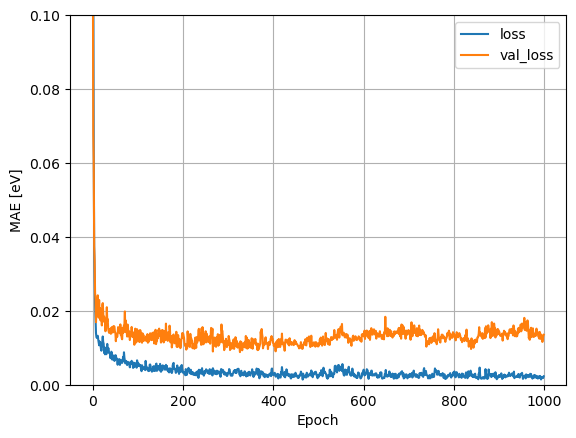

In [98]:
plt.plot(history_261.history['loss'], label='loss')
plt.plot(history_261.history['val_loss'], label='val_loss')
plt.ylim([0, 0.1])
plt.xlabel('Epoch')
plt.ylabel('MAE [eV]')
plt.legend()
plt.grid(True)

In [97]:
model_261.save(f'Results_Eg/model_261_optuna')

with open(f'Results_Eg/model_261_optuna.pkl', 'wb') as f:
    pickle.dump(history_261.history, f)

INFO:tensorflow:Assets written to: Results_Eg/Optuna/model_261_optuna\assets


INFO:tensorflow:Assets written to: Results_Eg/Optuna/model_261_optuna\assets


In [99]:
y_pred_261_train = model_261.predict(X_eg_train)
y_pred_261_val = model_261.predict(X_eg_val)
y_pred_261_test = model_261.predict(X_eg_test)

pd.DataFrame(y_pred_261_train).to_csv('Results_Eg/y_pred_261_train.csv',index=False)
pd.DataFrame(y_pred_261_val).to_csv('Results_Eg/y_pred_261_val.csv',index=False)
pd.DataFrame(y_pred_261_test).to_csv('Results_Eg/y_pred_261_test.csv',index=False)

3/3 [==============================] - 0s 2ms/step


3/3 [==============================] - 0s 2ms/step
R2 scores:

Training set:  0.9013952739133049
Validation set:  0.9334536809266183
Test set:  0.8985790658555246

MAE (eV):

Training set:  0.010806940510271966
Validation set:  0.015917351936146434
Test set:  0.009720999961005125
3/3 [==============================] - 0s 2ms/step


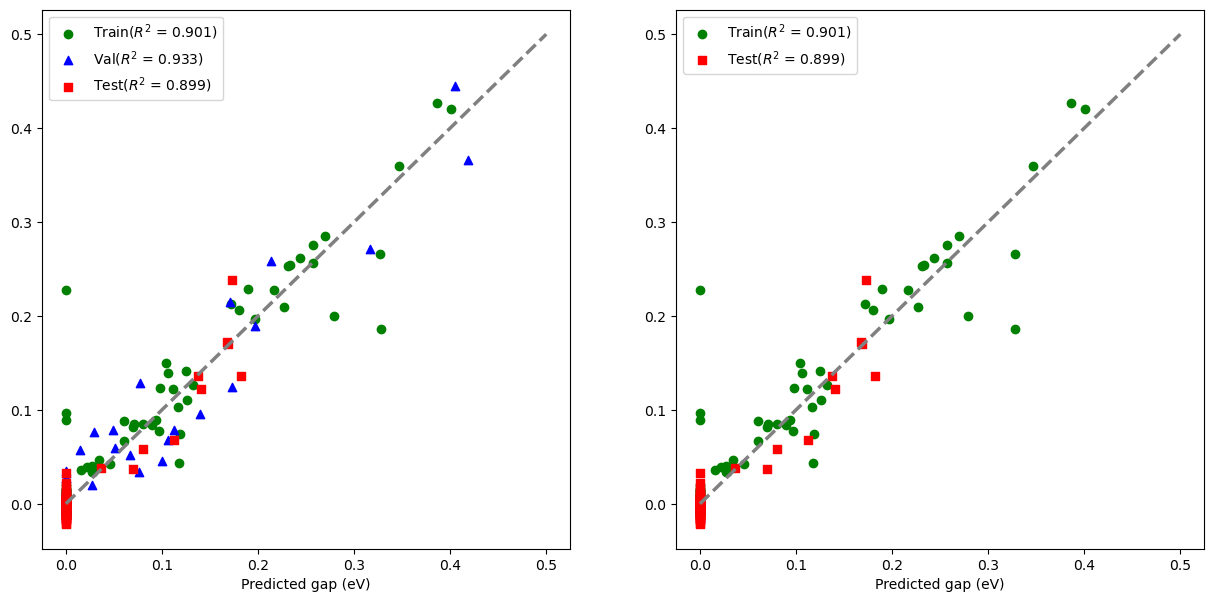

In [65]:
# Trial number: 302 

import os
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Normalization layer
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_eg_train))

# Model definition
model_302 = tf.keras.Sequential([normalizer])
model_302.add(layers.Dense(55, activation='elu', kernel_regularizer=regularizers.l2(0.001)))
model_302.add(layers.Dropout(0.0, seed=SEED))
model_302.add(layers.Dense(32, activation='elu', kernel_regularizer=regularizers.l2(0.001)))
model_302.add(layers.Dropout(0.0, seed=SEED))
model_302.add(layers.Dense(64, activation= 'elu', kernel_regularizer=regularizers.l2(0.001)))
model_302.add(layers.Dropout(0.0, seed=SEED))
model_302.add(layers.Dense(1))

# Compile the model
model_302.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='mean_absolute_error')

# Train the model
history_302 = model_302.fit(X_eg_train, y_eg_train['57'], validation_data=(X_eg_val, y_eg_val['57']), epochs=500, verbose=0, shuffle=False)

# Evaluate the model
r2_train_302 = metrics.r2_score(y_eg_train['57'], model_302.predict(X_eg_train).flatten())
r2_val_302 = metrics.r2_score(y_eg_val['57'], model_302.predict(X_eg_val).flatten())
r2_test_302 = metrics.r2_score(y_eg_test['57'], model_302.predict(X_eg_test).flatten())

mae_train_302 = metrics.mean_absolute_error(y_eg_train['57'], model_302.predict(X_eg_train).flatten())
mae_val_302 = metrics.mean_absolute_error(y_eg_val['57'], model_302.predict(X_eg_val).flatten())
mae_test_302 = metrics.mean_absolute_error(y_eg_test['57'], model_302.predict(X_eg_test).flatten())

print('R2 scores:\n')
print('Training set: ',r2_train_302)
print('Validation set: ',r2_val_302)
print('Test set: ',r2_test_302)

print('\nMAE (eV):\n')
print('Training set: ',mae_train_302)
print('Validation set: ',mae_val_302)
print('Test set: ',mae_test_302)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,7))
ax1.scatter(y_eg_train['57'], model_302.predict(X_eg_train).flatten(),label='Train($R^2$ = '+str(f'{r2_train_302:.3f}')+')',marker='o',color='green')
ax1.scatter(y_eg_val['57'], model_302.predict(X_eg_val).flatten(),label='Val($R^2$ = '+str(f'{r2_val_302:.3f}')+')',marker='^',color='blue')
ax1.scatter(y_eg_test['57'], model_302.predict(X_eg_test).flatten(),label='Test($R^2$ = '+str(f'{r2_test_302:.3f}')+')',marker='s',color='red')
ax1.set_xlabel('Calculated gap (eV)')
ax1.set_xlabel('Predicted gap (eV)')
ax1.plot([0,0.5], [0,0.5],linewidth=2.5, color='gray', linestyle='dashed')
ax1.legend()

ax2.scatter(y_eg_train['57'], model_302.predict(X_eg_train).flatten(),label='Train($R^2$ = '+str(f'{r2_train_302:.3f}')+')',marker='o',color='green')
ax2.scatter(y_eg_test['57'], model_302.predict(X_eg_test).flatten(),label='Test($R^2$ = '+str(f'{r2_test_302:.3f}')+')',marker='s',color='red')
ax2.set_xlabel('Calculated gap (eV)')
ax2.set_xlabel('Predicted gap (eV)')
ax2.plot([0,0.5], [0,0.5],linewidth=2.5, color='gray', linestyle='dashed')
ax2.legend()
plt.show()

3/3 [==============================] - 0s 2ms/step
R2 scores:

Training set:  0.8961047443269046
Validation set:  0.9129191411819776
Test set:  0.7900947589541536

MAE (eV):

Training set:  0.009031970150342515
Validation set:  0.013722362352811872
Test set:  0.010090718847766016
3/3 [==============================] - 0s 8ms/step


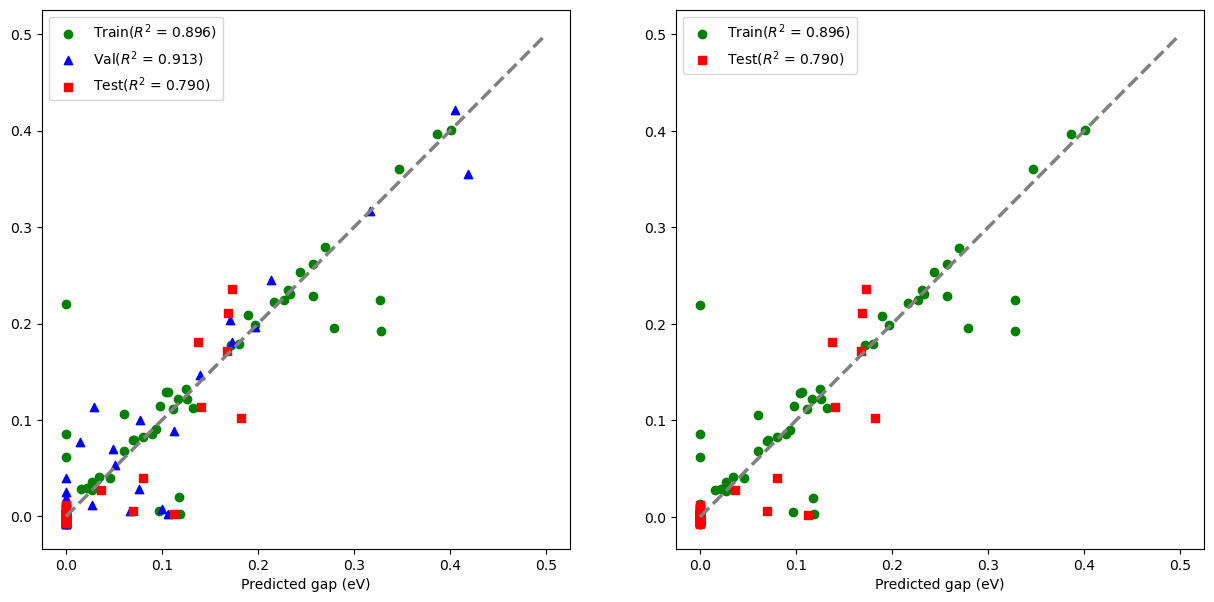

In [66]:
# Trial number: 302 for 1000 epochs

import os
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Normalization layer
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_eg_train))

# Model definition
model_302 = tf.keras.Sequential([normalizer])
model_302.add(layers.Dense(55, activation='elu', kernel_regularizer=regularizers.l2(0.001)))
model_302.add(layers.Dropout(0.0, seed=SEED))
model_302.add(layers.Dense(32, activation='elu', kernel_regularizer=regularizers.l2(0.001)))
model_302.add(layers.Dropout(0.0, seed=SEED))
model_302.add(layers.Dense(64, activation= 'elu', kernel_regularizer=regularizers.l2(0.001)))
model_302.add(layers.Dropout(0.0, seed=SEED))
model_302.add(layers.Dense(1))

# Compile the model
model_302.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='mean_absolute_error')

# Train the model
history_302 = model_302.fit(X_eg_train, y_eg_train['57'], validation_data=(X_eg_val, y_eg_val['57']), epochs=1000, verbose=0, shuffle=False)

# Evaluate the model
r2_train_302 = metrics.r2_score(y_eg_train['57'], model_302.predict(X_eg_train).flatten())
r2_val_302 = metrics.r2_score(y_eg_val['57'], model_302.predict(X_eg_val).flatten())
r2_test_302 = metrics.r2_score(y_eg_test['57'], model_302.predict(X_eg_test).flatten())

mae_train_302 = metrics.mean_absolute_error(y_eg_train['57'], model_302.predict(X_eg_train).flatten())
mae_val_302 = metrics.mean_absolute_error(y_eg_val['57'], model_302.predict(X_eg_val).flatten())
mae_test_302 = metrics.mean_absolute_error(y_eg_test['57'], model_302.predict(X_eg_test).flatten())

print('R2 scores:\n')
print('Training set: ',r2_train_302)
print('Validation set: ',r2_val_302)
print('Test set: ',r2_test_302)

print('\nMAE (eV):\n')
print('Training set: ',mae_train_302)
print('Validation set: ',mae_val_302)
print('Test set: ',mae_test_302)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,7))
ax1.scatter(y_eg_train['57'], model_302.predict(X_eg_train).flatten(),label='Train($R^2$ = '+str(f'{r2_train_302:.3f}')+')',marker='o',color='green')
ax1.scatter(y_eg_val['57'], model_302.predict(X_eg_val).flatten(),label='Val($R^2$ = '+str(f'{r2_val_302:.3f}')+')',marker='^',color='blue')
ax1.scatter(y_eg_test['57'], model_302.predict(X_eg_test).flatten(),label='Test($R^2$ = '+str(f'{r2_test_302:.3f}')+')',marker='s',color='red')
ax1.set_xlabel('Calculated gap (eV)')
ax1.set_xlabel('Predicted gap (eV)')
ax1.plot([0,0.5], [0,0.5],linewidth=2.5, color='gray', linestyle='dashed')
ax1.legend()

ax2.scatter(y_eg_train['57'], model_302.predict(X_eg_train).flatten(),label='Train($R^2$ = '+str(f'{r2_train_302:.3f}')+')',marker='o',color='green')
ax2.scatter(y_eg_test['57'], model_302.predict(X_eg_test).flatten(),label='Test($R^2$ = '+str(f'{r2_test_302:.3f}')+')',marker='s',color='red')
ax2.set_xlabel('Calculated gap (eV)')
ax2.set_xlabel('Predicted gap (eV)')
ax2.plot([0,0.5], [0,0.5],linewidth=2.5, color='gray', linestyle='dashed')
ax2.legend()
plt.show()

3/3 [==============================] - 0s 0s/step
R2 scores:

Training set:  0.9525314227743393
Validation set:  0.948949009725407
Test set:  0.8399358137678756

MAE (eV):

Training set:  0.006377649883116366
Validation set:  0.011694186168887736
Test set:  0.00912334608031168
3/3 [==============================] - 0s 2ms/step


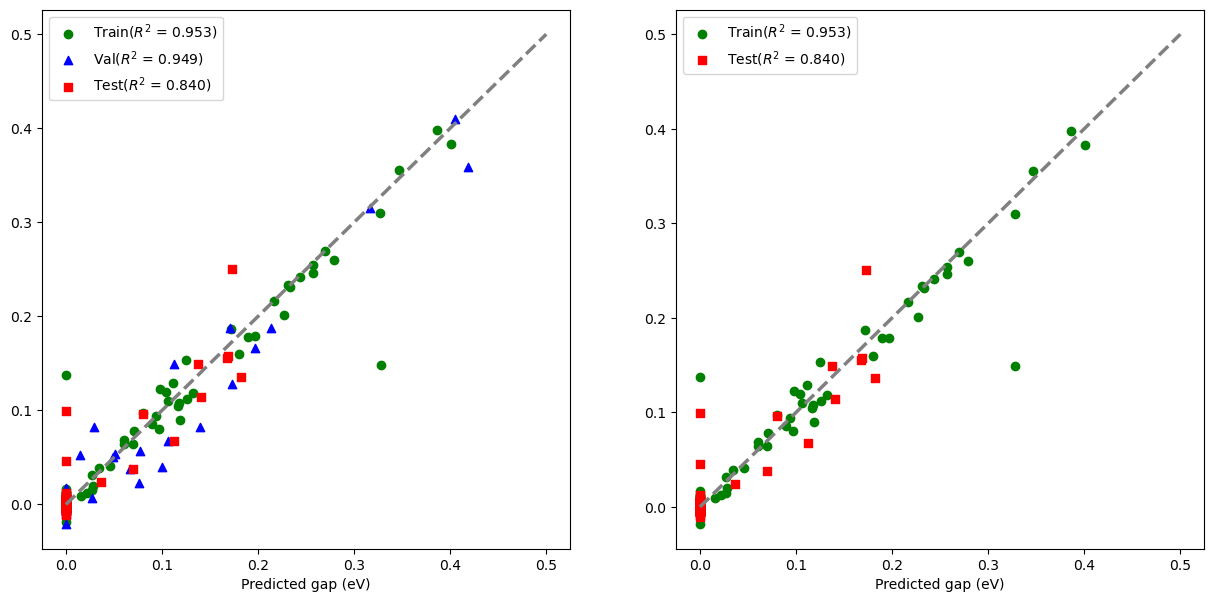

In [67]:
# Trial number: 435

import os
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Normalization layer
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_eg_train))

# Model definition
model_435 = tf.keras.Sequential([normalizer])
model_435.add(layers.Dense(55, activation='elu', kernel_regularizer=None))#regularizers.l2(0.00001)))
model_435.add(layers.Dropout(0.0, seed=SEED))
model_435.add(layers.Dense(32, activation='elu', kernel_regularizer=None))#regularizers.l2(0.00001)))
model_435.add(layers.Dropout(0.0, seed=SEED))
model_435.add(layers.Dense(64, activation= 'elu', kernel_regularizer=None))#regularizers.l2(0.00001)))
model_435.add(layers.Dropout(0.0, seed=SEED))
model_435.add(layers.Dense(1))

# Compile the model
model_435.compile(optimizer=tf.keras.optimizers.Adam(0.005), loss='mean_absolute_error')

# Train the model
history_435 = model_435.fit(X_eg_train, y_eg_train['57'], validation_data=(X_eg_val, y_eg_val['57']), epochs=500, verbose=0, shuffle=False)

# Evaluate the model
r2_train_435 = metrics.r2_score(y_eg_train['57'], model_435.predict(X_eg_train).flatten())
r2_val_435 = metrics.r2_score(y_eg_val['57'], model_435.predict(X_eg_val).flatten())
r2_test_435 = metrics.r2_score(y_eg_test['57'], model_435.predict(X_eg_test).flatten())

mae_train_435 = metrics.mean_absolute_error(y_eg_train['57'], model_435.predict(X_eg_train).flatten())
mae_val_435 = metrics.mean_absolute_error(y_eg_val['57'], model_435.predict(X_eg_val).flatten())
mae_test_435 = metrics.mean_absolute_error(y_eg_test['57'], model_435.predict(X_eg_test).flatten())

print('R2 scores:\n')
print('Training set: ',r2_train_435)
print('Validation set: ',r2_val_435)
print('Test set: ',r2_test_435)

print('\nMAE (eV):\n')
print('Training set: ',mae_train_435)
print('Validation set: ',mae_val_435)
print('Test set: ',mae_test_435)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,7))
ax1.scatter(y_eg_train['57'], model_435.predict(X_eg_train).flatten(),label='Train($R^2$ = '+str(f'{r2_train_435:.3f}')+')',marker='o',color='green')
ax1.scatter(y_eg_val['57'], model_435.predict(X_eg_val).flatten(),label='Val($R^2$ = '+str(f'{r2_val_435:.3f}')+')',marker='^',color='blue')
ax1.scatter(y_eg_test['57'], model_435.predict(X_eg_test).flatten(),label='Test($R^2$ = '+str(f'{r2_test_435:.3f}')+')',marker='s',color='red')
ax1.set_xlabel('Calculated gap (eV)')
ax1.set_xlabel('Predicted gap (eV)')
ax1.plot([0,0.5], [0,0.5],linewidth=2.5, color='gray', linestyle='dashed')
ax1.legend()

ax2.scatter(y_eg_train['57'], model_435.predict(X_eg_train).flatten(),label='Train($R^2$ = '+str(f'{r2_train_435:.3f}')+')',marker='o',color='green')
ax2.scatter(y_eg_test['57'], model_435.predict(X_eg_test).flatten(),label='Test($R^2$ = '+str(f'{r2_test_435:.3f}')+')',marker='s',color='red')
ax2.set_xlabel('Calculated gap (eV)')
ax2.set_xlabel('Predicted gap (eV)')
ax2.plot([0,0.5], [0,0.5],linewidth=2.5, color='gray', linestyle='dashed')
ax2.legend()
plt.show()

3/3 [==============================] - 0s 0s/step
R2 scores:

Training set:  0.9928948703330672
Validation set:  0.9287329518096723
Test set:  0.8243298451513281

MAE (eV):

Training set:  0.004722129678797862
Validation set:  0.012749992395128536
Test set:  0.009691334748182923
3/3 [==============================] - 0s 0s/step


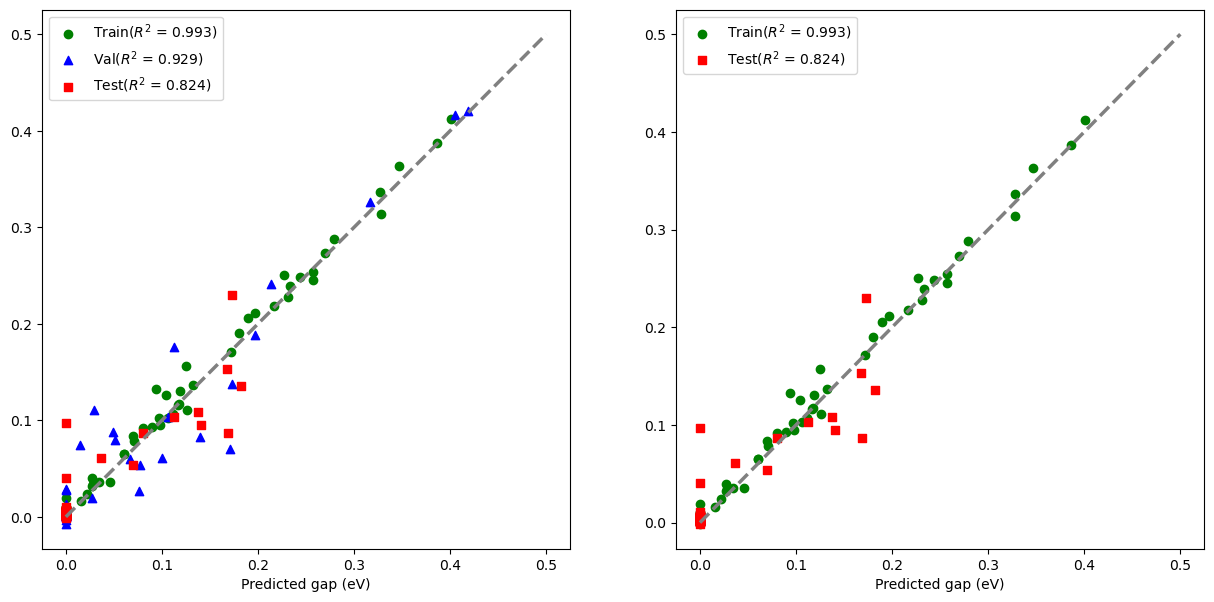

In [68]:
# Trial number: 435 for 1000 epochs

import os
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Normalization layer
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_eg_train))

# Model definition
model_435 = tf.keras.Sequential([normalizer])
model_435.add(layers.Dense(55, activation='elu', kernel_regularizer=None))#regularizers.l2(0.00001)))
model_435.add(layers.Dropout(0.0, seed=SEED))
model_435.add(layers.Dense(32, activation='elu', kernel_regularizer=None))#regularizers.l2(0.00001)))
model_435.add(layers.Dropout(0.0, seed=SEED))
model_435.add(layers.Dense(64, activation= 'elu', kernel_regularizer=None))#regularizers.l2(0.00001)))
model_435.add(layers.Dropout(0.0, seed=SEED))
model_435.add(layers.Dense(1))

# Compile the model
model_435.compile(optimizer=tf.keras.optimizers.Adam(0.005), loss='mean_absolute_error')

# Train the model
history_435 = model_435.fit(X_eg_train, y_eg_train['57'], validation_data=(X_eg_val, y_eg_val['57']), epochs=1000, verbose=0, shuffle=False)

# Evaluate the model
r2_train_435 = metrics.r2_score(y_eg_train['57'], model_435.predict(X_eg_train).flatten())
r2_val_435 = metrics.r2_score(y_eg_val['57'], model_435.predict(X_eg_val).flatten())
r2_test_435 = metrics.r2_score(y_eg_test['57'], model_435.predict(X_eg_test).flatten())

mae_train_435 = metrics.mean_absolute_error(y_eg_train['57'], model_435.predict(X_eg_train).flatten())
mae_val_435 = metrics.mean_absolute_error(y_eg_val['57'], model_435.predict(X_eg_val).flatten())
mae_test_435 = metrics.mean_absolute_error(y_eg_test['57'], model_435.predict(X_eg_test).flatten())

print('R2 scores:\n')
print('Training set: ',r2_train_435)
print('Validation set: ',r2_val_435)
print('Test set: ',r2_test_435)

print('\nMAE (eV):\n')
print('Training set: ',mae_train_435)
print('Validation set: ',mae_val_435)
print('Test set: ',mae_test_435)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,7))
ax1.scatter(y_eg_train['57'], model_435.predict(X_eg_train).flatten(),label='Train($R^2$ = '+str(f'{r2_train_435:.3f}')+')',marker='o',color='green')
ax1.scatter(y_eg_val['57'], model_435.predict(X_eg_val).flatten(),label='Val($R^2$ = '+str(f'{r2_val_435:.3f}')+')',marker='^',color='blue')
ax1.scatter(y_eg_test['57'], model_435.predict(X_eg_test).flatten(),label='Test($R^2$ = '+str(f'{r2_test_435:.3f}')+')',marker='s',color='red')
ax1.set_xlabel('Calculated gap (eV)')
ax1.set_xlabel('Predicted gap (eV)')
ax1.plot([0,0.5], [0,0.5],linewidth=2.5, color='gray', linestyle='dashed')
ax1.legend()

ax2.scatter(y_eg_train['57'], model_435.predict(X_eg_train).flatten(),label='Train($R^2$ = '+str(f'{r2_train_435:.3f}')+')',marker='o',color='green')
ax2.scatter(y_eg_test['57'], model_435.predict(X_eg_test).flatten(),label='Test($R^2$ = '+str(f'{r2_test_435:.3f}')+')',marker='s',color='red')
ax2.set_xlabel('Calculated gap (eV)')
ax2.set_xlabel('Predicted gap (eV)')
ax2.plot([0,0.5], [0,0.5],linewidth=2.5, color='gray', linestyle='dashed')
ax2.legend()
plt.show()

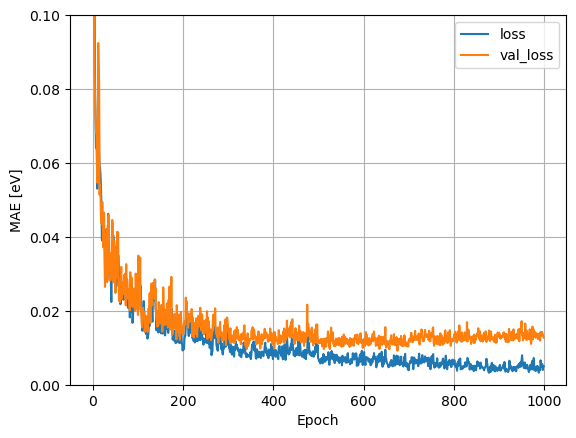

In [95]:
plt.plot(history_435.history['loss'], label='loss')
plt.plot(history_435.history['val_loss'], label='val_loss')
plt.ylim([0, 0.1])
plt.xlabel('Epoch')
plt.ylabel('MAE [eV]')
plt.legend()
plt.grid(True)

In [96]:
model_435.save(f'Results_Eg/model_435_optuna')

with open(f'Results_Eg/model_435_optuna.pkl', 'wb') as f:
    pickle.dump(history_435.history, f)

INFO:tensorflow:Assets written to: Results_Eg/Optuna/model_435_optuna\assets


INFO:tensorflow:Assets written to: Results_Eg/Optuna/model_435_optuna\assets


In [93]:
y_pred_435_train = model_435.predict(X_eg_train)
y_pred_435_val = model_435.predict(X_eg_val)
y_pred_435_test = model_435.predict(X_eg_test)

pd.DataFrame(y_pred_435_train).to_csv('Results_Eg/y_pred_435_train.csv',index=False)
pd.DataFrame(y_pred_435_val).to_csv('Results_Eg/y_pred_435_val.csv',index=False)
pd.DataFrame(y_pred_435_test).to_csv('Results_Eg/y_pred_435_test.csv',index=False)

3/3 [==============================] - 0s 3ms/step


3/3 [==============================] - 0s 0s/step
R2 scores:

Training set:  0.9415713627590602
Validation set:  0.9499549398677716
Test set:  0.8759018493813748

MAE (eV):

Training set:  0.005472852812721746
Validation set:  0.011020050050126637
Test set:  0.007402932923372333
3/3 [==============================] - 0s 1ms/step


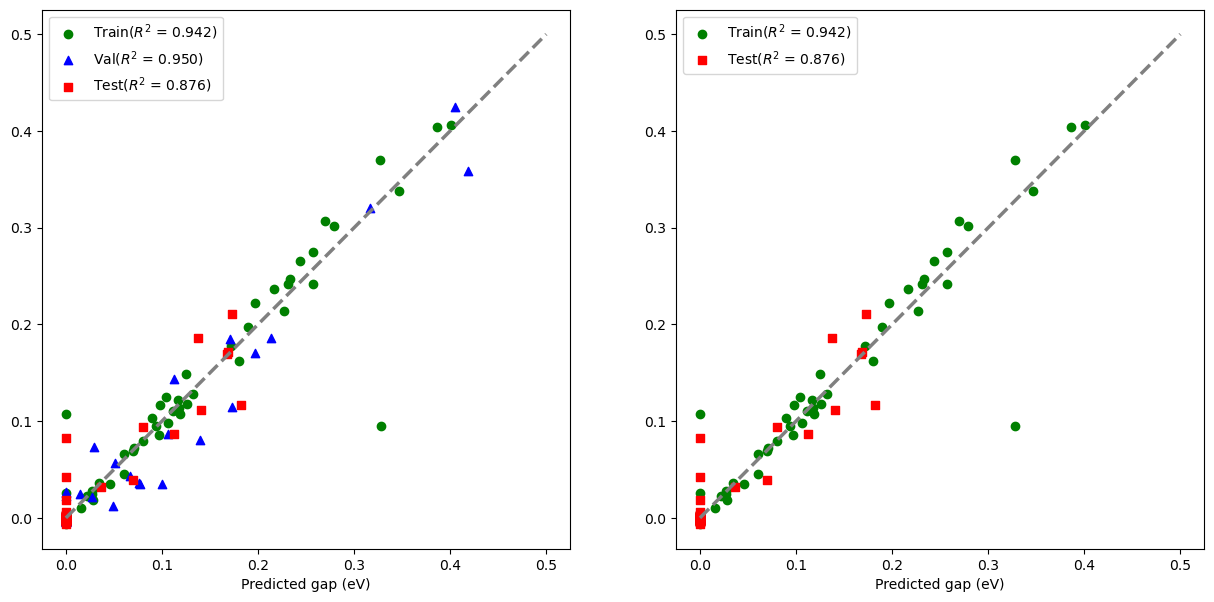

In [70]:
# Trial number: 447

import os
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Normalization layer
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_eg_train))

# Model definition
model_447 = tf.keras.Sequential([normalizer])
model_447.add(layers.Dense(64, activation='elu', kernel_regularizer=regularizers.l1(0.00001)))
model_447.add(layers.Dropout(0.0, seed=SEED))
model_447.add(layers.Dense(128, activation='elu', kernel_regularizer=regularizers.l1(0.00001)))
model_447.add(layers.Dropout(0.0, seed=SEED))
model_447.add(layers.Dense(20, activation= 'elu', kernel_regularizer=regularizers.l1(0.00001)))
model_447.add(layers.Dropout(0.0, seed=SEED))
model_447.add(layers.Dense(1))

# Compile the model
model_447.compile(optimizer=tf.keras.optimizers.Adam(0.005), loss='mean_absolute_error')

# Train the model
history_447 = model_447.fit(X_eg_train, y_eg_train['57'], validation_data=(X_eg_val, y_eg_val['57']), epochs=500, verbose=0, shuffle=False)

# Evaluate the model
r2_train_447 = metrics.r2_score(y_eg_train['57'], model_447.predict(X_eg_train).flatten())
r2_val_447 = metrics.r2_score(y_eg_val['57'], model_447.predict(X_eg_val).flatten())
r2_test_447 = metrics.r2_score(y_eg_test['57'], model_447.predict(X_eg_test).flatten())

mae_train_447 = metrics.mean_absolute_error(y_eg_train['57'], model_447.predict(X_eg_train).flatten())
mae_val_447 = metrics.mean_absolute_error(y_eg_val['57'], model_447.predict(X_eg_val).flatten())
mae_test_447 = metrics.mean_absolute_error(y_eg_test['57'], model_447.predict(X_eg_test).flatten())

print('R2 scores:\n')
print('Training set: ',r2_train_447)
print('Validation set: ',r2_val_447)
print('Test set: ',r2_test_447)

print('\nMAE (eV):\n')
print('Training set: ',mae_train_447)
print('Validation set: ',mae_val_447)
print('Test set: ',mae_test_447)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,7))
ax1.scatter(y_eg_train['57'], model_447.predict(X_eg_train).flatten(),label='Train($R^2$ = '+str(f'{r2_train_447:.3f}')+')',marker='o',color='green')
ax1.scatter(y_eg_val['57'], model_447.predict(X_eg_val).flatten(),label='Val($R^2$ = '+str(f'{r2_val_447:.3f}')+')',marker='^',color='blue')
ax1.scatter(y_eg_test['57'], model_447.predict(X_eg_test).flatten(),label='Test($R^2$ = '+str(f'{r2_test_447:.3f}')+')',marker='s',color='red')
ax1.set_xlabel('Calculated gap (eV)')
ax1.set_xlabel('Predicted gap (eV)')
ax1.plot([0,0.5], [0,0.5],linewidth=2.5, color='gray', linestyle='dashed')
ax1.legend()

ax2.scatter(y_eg_train['57'], model_447.predict(X_eg_train).flatten(),label='Train($R^2$ = '+str(f'{r2_train_447:.3f}')+')',marker='o',color='green')
ax2.scatter(y_eg_test['57'], model_447.predict(X_eg_test).flatten(),label='Test($R^2$ = '+str(f'{r2_test_447:.3f}')+')',marker='s',color='red')
ax2.set_xlabel('Calculated gap (eV)')
ax2.set_xlabel('Predicted gap (eV)')
ax2.plot([0,0.5], [0,0.5],linewidth=2.5, color='gray', linestyle='dashed')
ax2.legend()
plt.show()

3/3 [==============================] - 0s 6ms/step
R2 scores:

Training set:  0.9961424319335503
Validation set:  0.9030127931794614
Test set:  0.8024008777188751

MAE (eV):

Training set:  0.0021441398786596257
Validation set:  0.012638233117482443
Test set:  0.008165842795265546
3/3 [==============================] - 0s 3ms/step


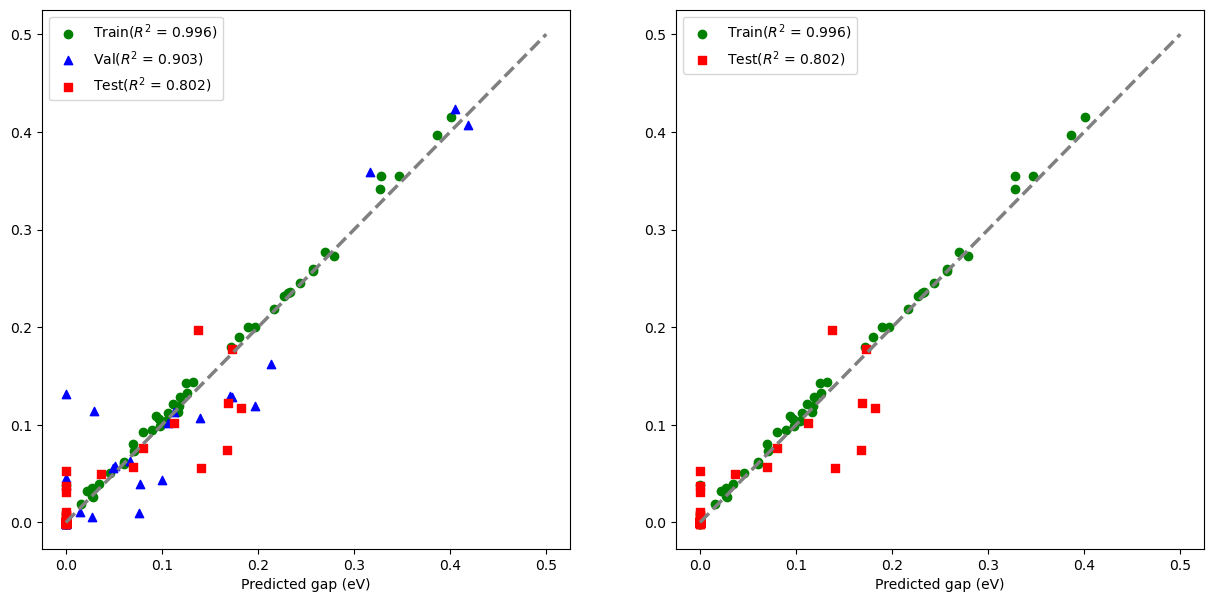

In [71]:
# Trial number: 447 for 1000 epochs

import os
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Normalization layer
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_eg_train))

# Model definition
model_447 = tf.keras.Sequential([normalizer])
model_447.add(layers.Dense(64, activation='elu', kernel_regularizer=regularizers.l1(0.00001)))
model_447.add(layers.Dropout(0.0, seed=SEED))
model_447.add(layers.Dense(128, activation='elu', kernel_regularizer=regularizers.l1(0.00001)))
model_447.add(layers.Dropout(0.0, seed=SEED))
model_447.add(layers.Dense(20, activation= 'elu', kernel_regularizer=regularizers.l1(0.00001)))
model_447.add(layers.Dropout(0.0, seed=SEED))
model_447.add(layers.Dense(1))

# Compile the model
model_447.compile(optimizer=tf.keras.optimizers.Adam(0.005), loss='mean_absolute_error')

# Train the model
history_447 = model_447.fit(X_eg_train, y_eg_train['57'], validation_data=(X_eg_val, y_eg_val['57']), epochs=1000, verbose=0, shuffle=False)

# Evaluate the model
r2_train_447 = metrics.r2_score(y_eg_train['57'], model_447.predict(X_eg_train).flatten())
r2_val_447 = metrics.r2_score(y_eg_val['57'], model_447.predict(X_eg_val).flatten())
r2_test_447 = metrics.r2_score(y_eg_test['57'], model_447.predict(X_eg_test).flatten())

mae_train_447 = metrics.mean_absolute_error(y_eg_train['57'], model_447.predict(X_eg_train).flatten())
mae_val_447 = metrics.mean_absolute_error(y_eg_val['57'], model_447.predict(X_eg_val).flatten())
mae_test_447 = metrics.mean_absolute_error(y_eg_test['57'], model_447.predict(X_eg_test).flatten())

print('R2 scores:\n')
print('Training set: ',r2_train_447)
print('Validation set: ',r2_val_447)
print('Test set: ',r2_test_447)

print('\nMAE (eV):\n')
print('Training set: ',mae_train_447)
print('Validation set: ',mae_val_447)
print('Test set: ',mae_test_447)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,7))
ax1.scatter(y_eg_train['57'], model_447.predict(X_eg_train).flatten(),label='Train($R^2$ = '+str(f'{r2_train_447:.3f}')+')',marker='o',color='green')
ax1.scatter(y_eg_val['57'], model_447.predict(X_eg_val).flatten(),label='Val($R^2$ = '+str(f'{r2_val_447:.3f}')+')',marker='^',color='blue')
ax1.scatter(y_eg_test['57'], model_447.predict(X_eg_test).flatten(),label='Test($R^2$ = '+str(f'{r2_test_447:.3f}')+')',marker='s',color='red')
ax1.set_xlabel('Calculated gap (eV)')
ax1.set_xlabel('Predicted gap (eV)')
ax1.plot([0,0.5], [0,0.5],linewidth=2.5, color='gray', linestyle='dashed')
ax1.legend()

ax2.scatter(y_eg_train['57'], model_447.predict(X_eg_train).flatten(),label='Train($R^2$ = '+str(f'{r2_train_447:.3f}')+')',marker='o',color='green')
ax2.scatter(y_eg_test['57'], model_447.predict(X_eg_test).flatten(),label='Test($R^2$ = '+str(f'{r2_test_447:.3f}')+')',marker='s',color='red')
ax2.set_xlabel('Calculated gap (eV)')
ax2.set_xlabel('Predicted gap (eV)')
ax2.plot([0,0.5], [0,0.5],linewidth=2.5, color='gray', linestyle='dashed')
ax2.legend()
plt.show()

3/3 [==============================] - 0s 7ms/step
R2 scores:

Training set:  0.9115817566637331
Validation set:  0.9221932088959833
Test set:  0.880196028616196

MAE (eV):

Training set:  0.012599046735465524
Validation set:  0.016419095752239213
Test set:  0.012019162050400488
3/3 [==============================] - 0s 7ms/step


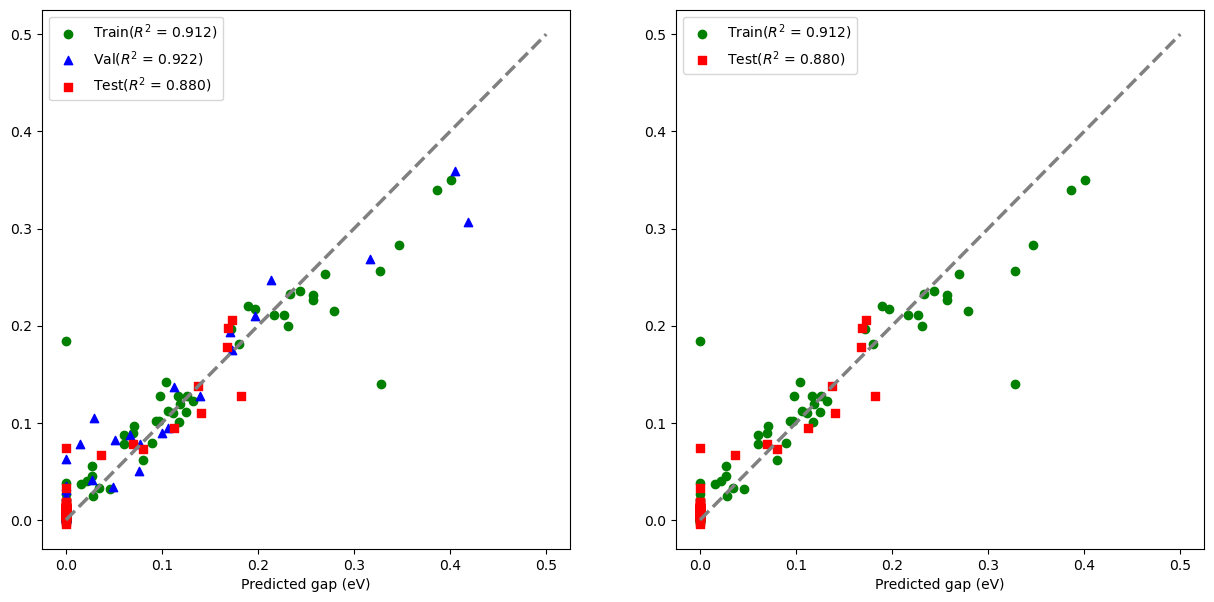

In [72]:
# Trial number: 448 

import os
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Normalization layer
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_eg_train))

# Model definition
model_448 = tf.keras.Sequential([normalizer])
model_448.add(layers.Dense(64, activation='elu', kernel_regularizer=None))#regularizers.l1(0.00001)))
model_448.add(layers.Dropout(0.1, seed=SEED))
model_448.add(layers.Dense(32, activation='elu', kernel_regularizer=None))#regularizers.l1(0.00001)))
model_448.add(layers.Dropout(0.1, seed=SEED))
model_448.add(layers.Dense(20, activation= 'elu', kernel_regularizer=None))#regularizers.l1(0.00001)))
model_448.add(layers.Dropout(0.1, seed=SEED))
model_448.add(layers.Dense(1))

# Compile the model
model_448.compile(optimizer=tf.keras.optimizers.Adam(0.005), loss='mean_absolute_error')

# Train the model
history_448 = model_448.fit(X_eg_train, y_eg_train['57'], validation_data=(X_eg_val, y_eg_val['57']), epochs=500, verbose=0, shuffle=False)

# Evaluate the model
r2_train_448 = metrics.r2_score(y_eg_train['57'], model_448.predict(X_eg_train).flatten())
r2_val_448 = metrics.r2_score(y_eg_val['57'], model_448.predict(X_eg_val).flatten())
r2_test_448 = metrics.r2_score(y_eg_test['57'], model_448.predict(X_eg_test).flatten())

mae_train_448 = metrics.mean_absolute_error(y_eg_train['57'], model_448.predict(X_eg_train).flatten())
mae_val_448 = metrics.mean_absolute_error(y_eg_val['57'], model_448.predict(X_eg_val).flatten())
mae_test_448 = metrics.mean_absolute_error(y_eg_test['57'], model_448.predict(X_eg_test).flatten())

print('R2 scores:\n')
print('Training set: ',r2_train_448)
print('Validation set: ',r2_val_448)
print('Test set: ',r2_test_448)

print('\nMAE (eV):\n')
print('Training set: ',mae_train_448)
print('Validation set: ',mae_val_448)
print('Test set: ',mae_test_448)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,7))
ax1.scatter(y_eg_train['57'], model_448.predict(X_eg_train).flatten(),label='Train($R^2$ = '+str(f'{r2_train_448:.3f}')+')',marker='o',color='green')
ax1.scatter(y_eg_val['57'], model_448.predict(X_eg_val).flatten(),label='Val($R^2$ = '+str(f'{r2_val_448:.3f}')+')',marker='^',color='blue')
ax1.scatter(y_eg_test['57'], model_448.predict(X_eg_test).flatten(),label='Test($R^2$ = '+str(f'{r2_test_448:.3f}')+')',marker='s',color='red')
ax1.set_xlabel('Calculated gap (eV)')
ax1.set_xlabel('Predicted gap (eV)')
ax1.plot([0,0.5], [0,0.5],linewidth=2.5, color='gray', linestyle='dashed')
ax1.legend()

ax2.scatter(y_eg_train['57'], model_448.predict(X_eg_train).flatten(),label='Train($R^2$ = '+str(f'{r2_train_448:.3f}')+')',marker='o',color='green')
ax2.scatter(y_eg_test['57'], model_448.predict(X_eg_test).flatten(),label='Test($R^2$ = '+str(f'{r2_test_448:.3f}')+')',marker='s',color='red')
ax2.set_xlabel('Calculated gap (eV)')
ax2.set_xlabel('Predicted gap (eV)')
ax2.plot([0,0.5], [0,0.5],linewidth=2.5, color='gray', linestyle='dashed')
ax2.legend()
plt.show()

3/3 [==============================] - 0s 4ms/step
R2 scores:

Training set:  0.9322090709750561
Validation set:  0.930769923704132
Test set:  0.7863510301439693

MAE (eV):

Training set:  0.011790508550892639
Validation set:  0.01563081374344009
Test set:  0.013810330787907728
3/3 [==============================] - 0s 8ms/step


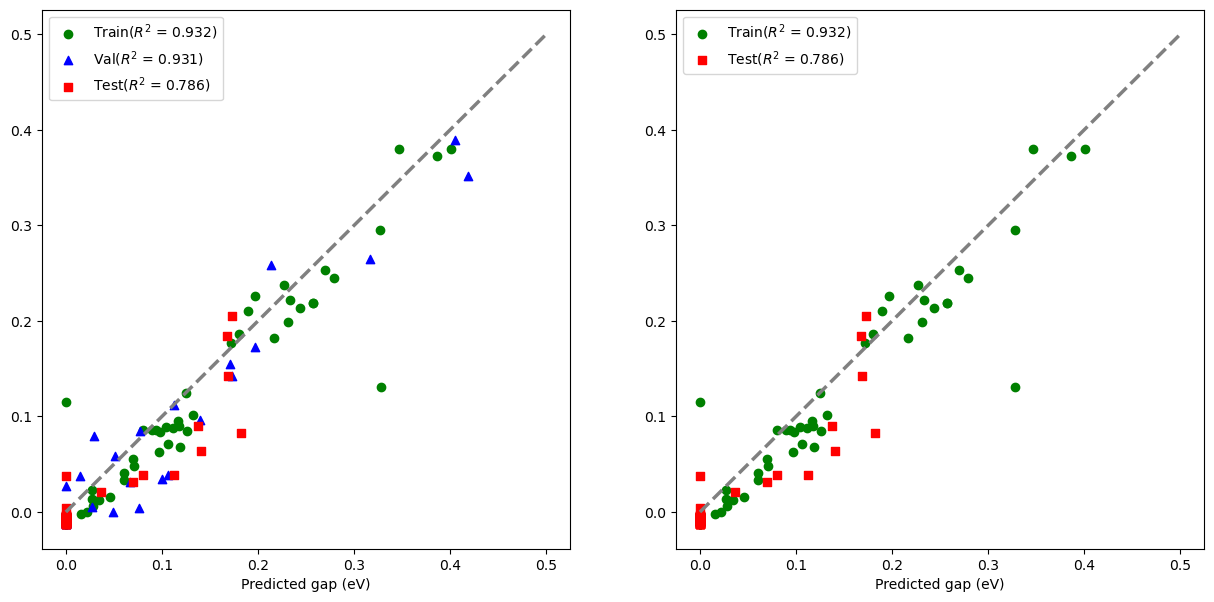

In [73]:
# Trial number: 448 for 1000 epochs

import os
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Normalization layer
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_eg_train))

# Model definition
model_448 = tf.keras.Sequential([normalizer])
model_448.add(layers.Dense(64, activation='elu', kernel_regularizer=None))#regularizers.l1(0.00001)))
model_448.add(layers.Dropout(0.1, seed=SEED))
model_448.add(layers.Dense(32, activation='elu', kernel_regularizer=None))#regularizers.l1(0.00001)))
model_448.add(layers.Dropout(0.1, seed=SEED))
model_448.add(layers.Dense(20, activation= 'elu', kernel_regularizer=None))#regularizers.l1(0.00001)))
model_448.add(layers.Dropout(0.1, seed=SEED))
model_448.add(layers.Dense(1))

# Compile the model
model_448.compile(optimizer=tf.keras.optimizers.Adam(0.005), loss='mean_absolute_error')

# Train the model
history_448 = model_448.fit(X_eg_train, y_eg_train['57'], validation_data=(X_eg_val, y_eg_val['57']), epochs=1000, verbose=0, shuffle=False)

# Evaluate the model
r2_train_448 = metrics.r2_score(y_eg_train['57'], model_448.predict(X_eg_train).flatten())
r2_val_448 = metrics.r2_score(y_eg_val['57'], model_448.predict(X_eg_val).flatten())
r2_test_448 = metrics.r2_score(y_eg_test['57'], model_448.predict(X_eg_test).flatten())

mae_train_448 = metrics.mean_absolute_error(y_eg_train['57'], model_448.predict(X_eg_train).flatten())
mae_val_448 = metrics.mean_absolute_error(y_eg_val['57'], model_448.predict(X_eg_val).flatten())
mae_test_448 = metrics.mean_absolute_error(y_eg_test['57'], model_448.predict(X_eg_test).flatten())

print('R2 scores:\n')
print('Training set: ',r2_train_448)
print('Validation set: ',r2_val_448)
print('Test set: ',r2_test_448)

print('\nMAE (eV):\n')
print('Training set: ',mae_train_448)
print('Validation set: ',mae_val_448)
print('Test set: ',mae_test_448)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,7))
ax1.scatter(y_eg_train['57'], model_448.predict(X_eg_train).flatten(),label='Train($R^2$ = '+str(f'{r2_train_448:.3f}')+')',marker='o',color='green')
ax1.scatter(y_eg_val['57'], model_448.predict(X_eg_val).flatten(),label='Val($R^2$ = '+str(f'{r2_val_448:.3f}')+')',marker='^',color='blue')
ax1.scatter(y_eg_test['57'], model_448.predict(X_eg_test).flatten(),label='Test($R^2$ = '+str(f'{r2_test_448:.3f}')+')',marker='s',color='red')
ax1.set_xlabel('Calculated gap (eV)')
ax1.set_xlabel('Predicted gap (eV)')
ax1.plot([0,0.5], [0,0.5],linewidth=2.5, color='gray', linestyle='dashed')
ax1.legend()

ax2.scatter(y_eg_train['57'], model_448.predict(X_eg_train).flatten(),label='Train($R^2$ = '+str(f'{r2_train_448:.3f}')+')',marker='o',color='green')
ax2.scatter(y_eg_test['57'], model_448.predict(X_eg_test).flatten(),label='Test($R^2$ = '+str(f'{r2_test_448:.3f}')+')',marker='s',color='red')
ax2.set_xlabel('Calculated gap (eV)')
ax2.set_xlabel('Predicted gap (eV)')
ax2.plot([0,0.5], [0,0.5],linewidth=2.5, color='gray', linestyle='dashed')
ax2.legend()
plt.show()

3/3 [==============================] - 0s 6ms/step
R2 scores:

Training set:  0.9591984478332681
Validation set:  0.9492049210659957
Test set:  0.8247024005394814

MAE (eV):

Training set:  0.0037754072302881884
Validation set:  0.01048874483628647
Test set:  0.007653122660015279
3/3 [==============================] - 0s 5ms/step


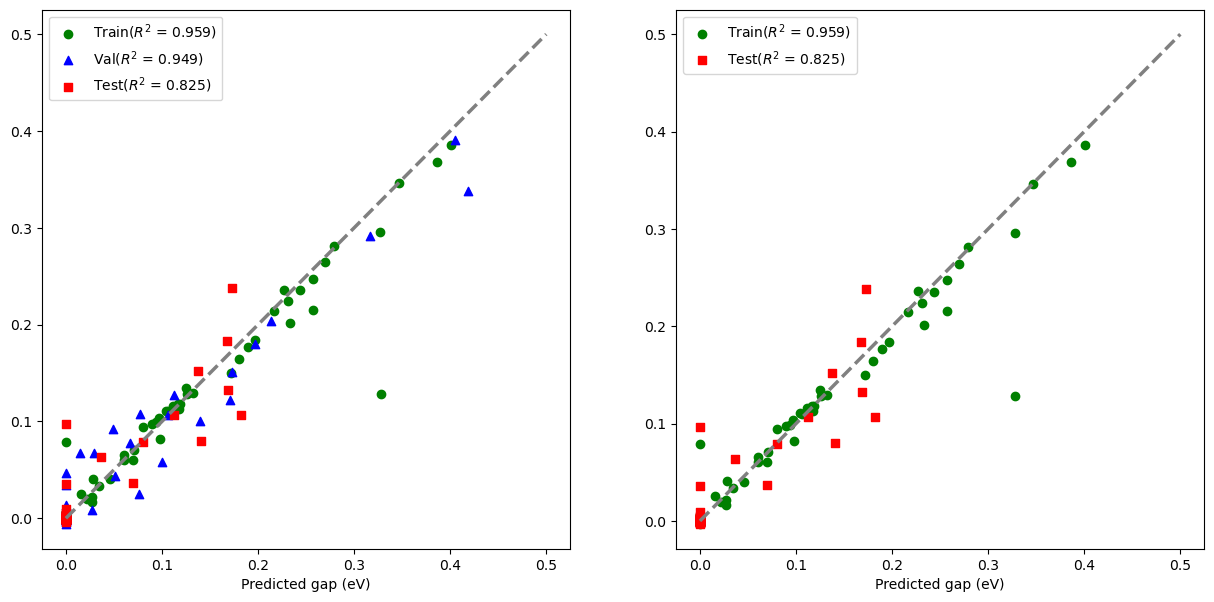

In [74]:
# Trial number: 466

import os
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Normalization layer
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_eg_train))

# Model definition
model_466 = tf.keras.Sequential([normalizer])
model_466.add(layers.Dense(55, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_466.add(layers.Dropout(0.0, seed=SEED))
model_466.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_466.add(layers.Dropout(0.0, seed=SEED))
model_466.add(layers.Dense(64, activation= 'relu', kernel_regularizer=regularizers.l2(0.001)))
model_466.add(layers.Dropout(0.0, seed=SEED))
model_466.add(layers.Dense(1))

# Compile the model
model_466.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='mean_absolute_error')

# Train the model
history_466 = model_466.fit(X_eg_train, y_eg_train['57'], validation_data=(X_eg_val, y_eg_val['57']), epochs=500, verbose=0, shuffle=False)

# Evaluate the model
r2_train_466 = metrics.r2_score(y_eg_train['57'], model_466.predict(X_eg_train).flatten())
r2_val_466 = metrics.r2_score(y_eg_val['57'], model_466.predict(X_eg_val).flatten())
r2_test_466 = metrics.r2_score(y_eg_test['57'], model_466.predict(X_eg_test).flatten())

mae_train_466 = metrics.mean_absolute_error(y_eg_train['57'], model_466.predict(X_eg_train).flatten())
mae_val_466 = metrics.mean_absolute_error(y_eg_val['57'], model_466.predict(X_eg_val).flatten())
mae_test_466 = metrics.mean_absolute_error(y_eg_test['57'], model_466.predict(X_eg_test).flatten())

print('R2 scores:\n')
print('Training set: ',r2_train_466)
print('Validation set: ',r2_val_466)
print('Test set: ',r2_test_466)

print('\nMAE (eV):\n')
print('Training set: ',mae_train_466)
print('Validation set: ',mae_val_466)
print('Test set: ',mae_test_466)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,7))
ax1.scatter(y_eg_train['57'], model_466.predict(X_eg_train).flatten(),label='Train($R^2$ = '+str(f'{r2_train_466:.3f}')+')',marker='o',color='green')
ax1.scatter(y_eg_val['57'], model_466.predict(X_eg_val).flatten(),label='Val($R^2$ = '+str(f'{r2_val_466:.3f}')+')',marker='^',color='blue')
ax1.scatter(y_eg_test['57'], model_466.predict(X_eg_test).flatten(),label='Test($R^2$ = '+str(f'{r2_test_466:.3f}')+')',marker='s',color='red')
ax1.set_xlabel('Calculated gap (eV)')
ax1.set_xlabel('Predicted gap (eV)')
ax1.plot([0,0.5], [0,0.5],linewidth=2.5, color='gray', linestyle='dashed')
ax1.legend()

ax2.scatter(y_eg_train['57'], model_466.predict(X_eg_train).flatten(),label='Train($R^2$ = '+str(f'{r2_train_466:.3f}')+')',marker='o',color='green')
ax2.scatter(y_eg_test['57'], model_466.predict(X_eg_test).flatten(),label='Test($R^2$ = '+str(f'{r2_test_466:.3f}')+')',marker='s',color='red')
ax2.set_xlabel('Calculated gap (eV)')
ax2.set_xlabel('Predicted gap (eV)')
ax2.plot([0,0.5], [0,0.5],linewidth=2.5, color='gray', linestyle='dashed')
ax2.legend()
plt.show()

3/3 [==============================] - 0s 2ms/step
R2 scores:

Training set:  0.9898264922419575
Validation set:  0.9090807794493782
Test set:  0.7868247504384052

MAE (eV):

Training set:  0.0024472332578162745
Validation set:  0.011736077605279704
Test set:  0.008004377950737586
3/3 [==============================] - 0s 4ms/step


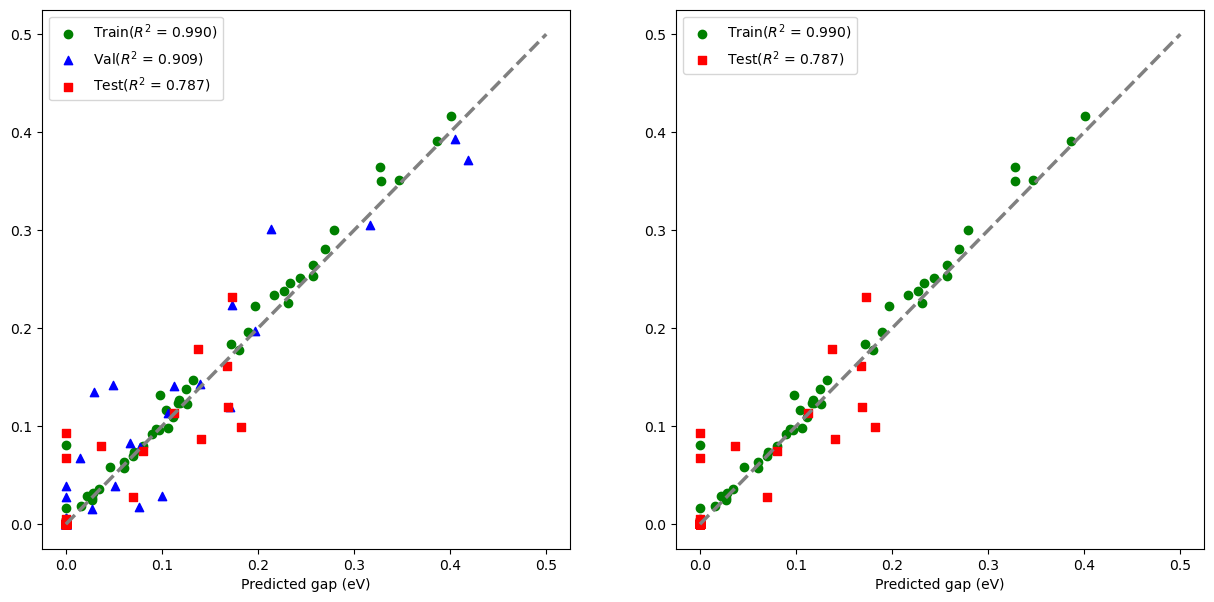

In [87]:
# Trial number: 466 for 1000 epochs

import os
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Normalization layer
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_eg_train))

# Model definition
model_466 = tf.keras.Sequential([normalizer])
model_466.add(layers.Dense(55, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_466.add(layers.Dropout(0.0, seed=SEED))
model_466.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_466.add(layers.Dropout(0.0, seed=SEED))
model_466.add(layers.Dense(64, activation= 'relu', kernel_regularizer=regularizers.l2(0.001)))
model_466.add(layers.Dropout(0.0, seed=SEED))
model_466.add(layers.Dense(1))

# Compile the model
model_466.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='mean_absolute_error')

# Train the model
history_466 = model_466.fit(X_eg_train, y_eg_train['57'], validation_data=(X_eg_val, y_eg_val['57']), epochs=1000, verbose=0, shuffle=False)

# Evaluate the model
r2_train_466 = metrics.r2_score(y_eg_train['57'], model_466.predict(X_eg_train).flatten())
r2_val_466 = metrics.r2_score(y_eg_val['57'], model_466.predict(X_eg_val).flatten())
r2_test_466 = metrics.r2_score(y_eg_test['57'], model_466.predict(X_eg_test).flatten())

mae_train_466 = metrics.mean_absolute_error(y_eg_train['57'], model_466.predict(X_eg_train).flatten())
mae_val_466 = metrics.mean_absolute_error(y_eg_val['57'], model_466.predict(X_eg_val).flatten())
mae_test_466 = metrics.mean_absolute_error(y_eg_test['57'], model_466.predict(X_eg_test).flatten())

print('R2 scores:\n')
print('Training set: ',r2_train_466)
print('Validation set: ',r2_val_466)
print('Test set: ',r2_test_466)

print('\nMAE (eV):\n')
print('Training set: ',mae_train_466)
print('Validation set: ',mae_val_466)
print('Test set: ',mae_test_466)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,7))
ax1.scatter(y_eg_train['57'], model_466.predict(X_eg_train).flatten(),label='Train($R^2$ = '+str(f'{r2_train_466:.3f}')+')',marker='o',color='green')
ax1.scatter(y_eg_val['57'], model_466.predict(X_eg_val).flatten(),label='Val($R^2$ = '+str(f'{r2_val_466:.3f}')+')',marker='^',color='blue')
ax1.scatter(y_eg_test['57'], model_466.predict(X_eg_test).flatten(),label='Test($R^2$ = '+str(f'{r2_test_466:.3f}')+')',marker='s',color='red')
ax1.set_xlabel('Calculated gap (eV)')
ax1.set_xlabel('Predicted gap (eV)')
ax1.plot([0,0.5], [0,0.5],linewidth=2.5, color='gray', linestyle='dashed')
ax1.legend()

ax2.scatter(y_eg_train['57'], model_466.predict(X_eg_train).flatten(),label='Train($R^2$ = '+str(f'{r2_train_466:.3f}')+')',marker='o',color='green')
ax2.scatter(y_eg_test['57'], model_466.predict(X_eg_test).flatten(),label='Test($R^2$ = '+str(f'{r2_test_466:.3f}')+')',marker='s',color='red')
ax2.set_xlabel('Calculated gap (eV)')
ax2.set_xlabel('Predicted gap (eV)')
ax2.plot([0,0.5], [0,0.5],linewidth=2.5, color='gray', linestyle='dashed')
ax2.legend()
plt.show()

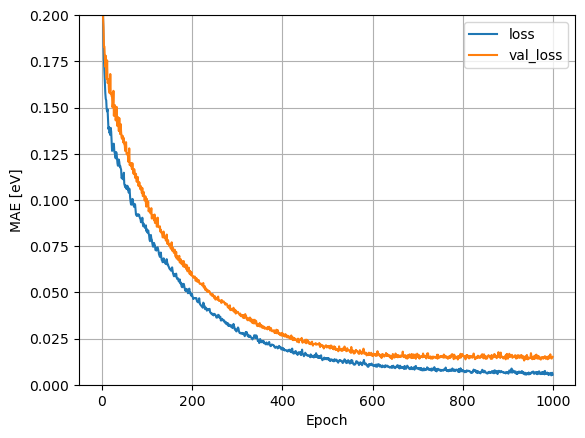

In [91]:
plt.plot(history_466.history['loss'], label='loss')
plt.plot(history_466.history['val_loss'], label='val_loss')
plt.ylim([0, 0.2])
plt.xlabel('Epoch')
plt.ylabel('MAE [eV]')
plt.legend()
plt.grid(True)

In [88]:
model_466.save(f'Results_Eg/model_466_optuna')

with open(f'Results_Eg/model_466_optuna.pkl', 'wb') as f:
    pickle.dump(history_466.history, f)

INFO:tensorflow:Assets written to: Results_Eg/Optuna/model_466_optuna\assets


INFO:tensorflow:Assets written to: Results_Eg/Optuna/model_466_optuna\assets


In [92]:
y_pred_466_train = model_466.predict(X_eg_train)
y_pred_466_val = model_466.predict(X_eg_val)
y_pred_466_test = model_466.predict(X_eg_test)

pd.DataFrame(y_pred_466_train).to_csv('Results_Eg/y_pred_466_train.csv',index=False)
pd.DataFrame(y_pred_466_val).to_csv('Results_Eg/y_pred_466_val.csv',index=False)
pd.DataFrame(y_pred_466_test).to_csv('Results_Eg/y_pred_466_test.csv',index=False)

3/3 [==============================] - 0s 5ms/step


## BEST MODEL TO USE 569 

3/3 [==============================] - 0s 392us/step
R2 scores:

Training set:  0.9869950256903924
Validation set:  0.879996980764777
Test set:  0.9150680127675326

MAE (eV):

Training set:  0.0035857947434402133
Validation set:  0.01387810844934815
Test set:  0.0050202151911625924
3/3 [==============================] - 0s 5ms/step


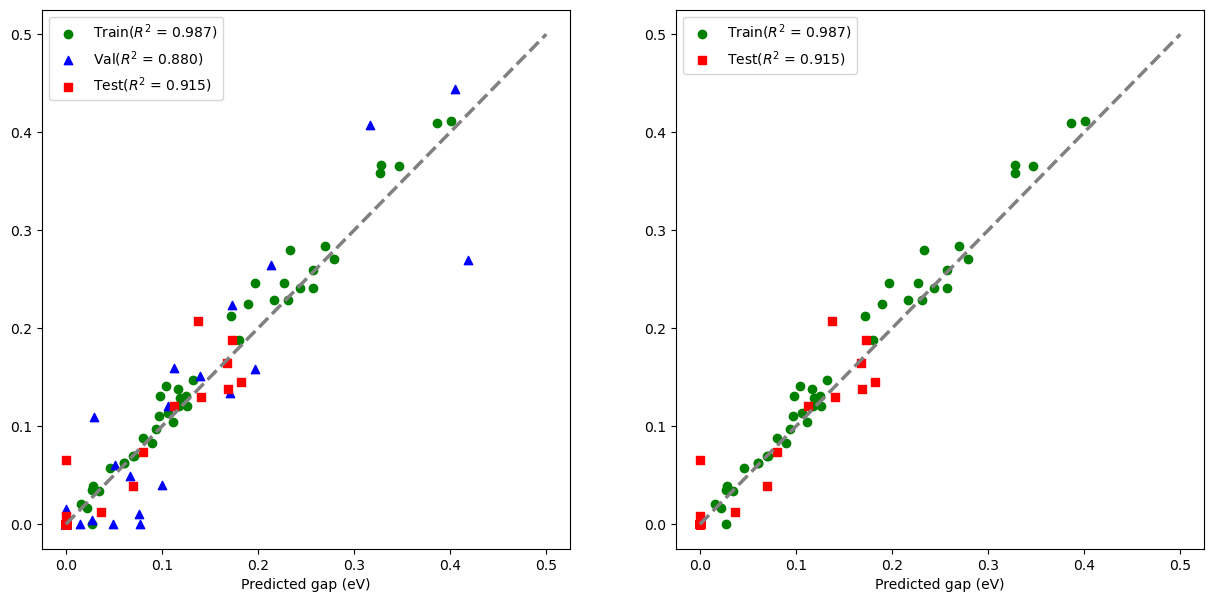

In [77]:
# Trial number: 569

import os
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Normalization layer
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_eg_train))

# Model definition
model_569 = tf.keras.Sequential([normalizer])
model_569.add(layers.Dense(64, activation='relu', kernel_regularizer=None))#regularizers.l2(0.001)))
model_569.add(layers.Dropout(0.1, seed=SEED))
model_569.add(layers.Dense(32, activation='relu', kernel_regularizer=None))#regularizers.l2(0.001)))
model_569.add(layers.Dropout(0.1, seed=SEED))
model_569.add(layers.Dense(64, activation= 'relu', kernel_regularizer=None))#regularizers.l2(0.001)))
model_569.add(layers.Dropout(0.1, seed=SEED))
model_569.add(layers.Dense(1))

# Compile the model
model_569.compile(optimizer=tf.keras.optimizers.Adam(0.005), loss='mean_absolute_error')

# Train the model
history_569 = model_569.fit(X_eg_train, y_eg_train['57'], validation_data=(X_eg_val, y_eg_val['57']), epochs=500, verbose=0, shuffle=False)

# Evaluate the model
r2_train_569 = metrics.r2_score(y_eg_train['57'], model_569.predict(X_eg_train).flatten())
r2_val_569 = metrics.r2_score(y_eg_val['57'], model_569.predict(X_eg_val).flatten())
r2_test_569 = metrics.r2_score(y_eg_test['57'], model_569.predict(X_eg_test).flatten())

mae_train_569 = metrics.mean_absolute_error(y_eg_train['57'], model_569.predict(X_eg_train).flatten())
mae_val_569 = metrics.mean_absolute_error(y_eg_val['57'], model_569.predict(X_eg_val).flatten())
mae_test_569 = metrics.mean_absolute_error(y_eg_test['57'], model_569.predict(X_eg_test).flatten())

print('R2 scores:\n')
print('Training set: ',r2_train_569)
print('Validation set: ',r2_val_569)
print('Test set: ',r2_test_569)

print('\nMAE (eV):\n')
print('Training set: ',mae_train_569)
print('Validation set: ',mae_val_569)
print('Test set: ',mae_test_569)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,7))
ax1.scatter(y_eg_train['57'], model_569.predict(X_eg_train).flatten(),label='Train($R^2$ = '+str(f'{r2_train_569:.3f}')+')',marker='o',color='green')
ax1.scatter(y_eg_val['57'], model_569.predict(X_eg_val).flatten(),label='Val($R^2$ = '+str(f'{r2_val_569:.3f}')+')',marker='^',color='blue')
ax1.scatter(y_eg_test['57'], model_569.predict(X_eg_test).flatten(),label='Test($R^2$ = '+str(f'{r2_test_569:.3f}')+')',marker='s',color='red')
ax1.set_xlabel('Calculated gap (eV)')
ax1.set_xlabel('Predicted gap (eV)')
ax1.plot([0,0.5], [0,0.5],linewidth=2.5, color='gray', linestyle='dashed')
ax1.legend()

ax2.scatter(y_eg_train['57'], model_569.predict(X_eg_train).flatten(),label='Train($R^2$ = '+str(f'{r2_train_569:.3f}')+')',marker='o',color='green')
ax2.scatter(y_eg_test['57'], model_569.predict(X_eg_test).flatten(),label='Test($R^2$ = '+str(f'{r2_test_569:.3f}')+')',marker='s',color='red')
ax2.set_xlabel('Calculated gap (eV)')
ax2.set_xlabel('Predicted gap (eV)')
ax2.plot([0,0.5], [0,0.5],linewidth=2.5, color='gray', linestyle='dashed')
ax2.legend()
plt.show()

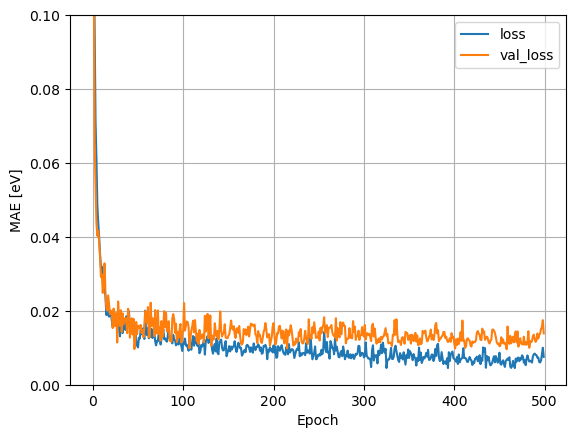

In [83]:
plt.plot(history_569.history['loss'], label='loss')
plt.plot(history_569.history['val_loss'], label='val_loss')
plt.ylim([0, 0.1])
plt.xlabel('Epoch')
plt.ylabel('MAE [eV]')
plt.legend()
plt.grid(True)

In [89]:
model_569.save(f'Results_Eg/model_569_optuna')

with open(f'Results_Eg/model_569_optuna.pkl', 'wb') as f:
    pickle.dump(history_569.history, f)

INFO:tensorflow:Assets written to: Results_Eg/Optuna/model_569_optuna\assets


INFO:tensorflow:Assets written to: Results_Eg/Optuna/model_569_optuna\assets


In [86]:
y_pred_569_train = model_569.predict(X_eg_train)
y_pred_569_val = model_569.predict(X_eg_val)
y_pred_569_test = model_569.predict(X_eg_test)

pd.DataFrame(y_pred_569_train).to_csv('Results_Eg/y_pred_569_train.csv',index=False)
pd.DataFrame(y_pred_569_val).to_csv('Results_Eg/y_pred_569_val.csv',index=False)
pd.DataFrame(y_pred_569_test).to_csv('Results_Eg/y_pred_569_test.csv',index=False)

3/3 [==============================] - 0s 5ms/step


3/3 [==============================] - 0s 0s/step
R2 scores:

Training set:  0.9866524638348725
Validation set:  0.892827102324057
Test set:  0.783045623717284

MAE (eV):

Training set:  0.00340496383636805
Validation set:  0.012662217584119315
Test set:  0.007614627286790473
3/3 [==============================] - 0s 3ms/step


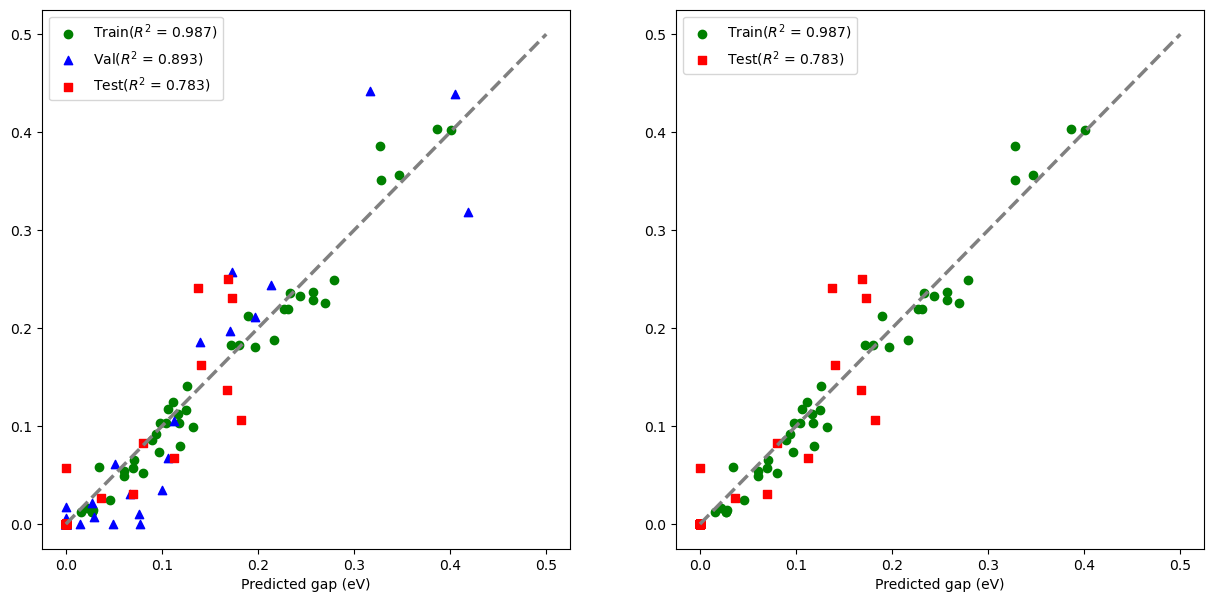

In [76]:
# Trial number: 569 for 1000 epochs

import os
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Normalization layer
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_eg_train))

# Model definition
model_569 = tf.keras.Sequential([normalizer])
model_569.add(layers.Dense(64, activation='relu', kernel_regularizer=None))#regularizers.l2(0.001)))
model_569.add(layers.Dropout(0.1, seed=SEED))
model_569.add(layers.Dense(32, activation='relu', kernel_regularizer=None))#regularizers.l2(0.001)))
model_569.add(layers.Dropout(0.1, seed=SEED))
model_569.add(layers.Dense(64, activation= 'relu', kernel_regularizer=None))#regularizers.l2(0.001)))
model_569.add(layers.Dropout(0.1, seed=SEED))
model_569.add(layers.Dense(1))

# Compile the model
model_569.compile(optimizer=tf.keras.optimizers.Adam(0.005), loss='mean_absolute_error')

# Train the model
history_569 = model_569.fit(X_eg_train, y_eg_train['57'], validation_data=(X_eg_val, y_eg_val['57']), epochs=1000, verbose=0, shuffle=False)

# Evaluate the model
r2_train_569 = metrics.r2_score(y_eg_train['57'], model_569.predict(X_eg_train).flatten())
r2_val_569 = metrics.r2_score(y_eg_val['57'], model_569.predict(X_eg_val).flatten())
r2_test_569 = metrics.r2_score(y_eg_test['57'], model_569.predict(X_eg_test).flatten())

mae_train_569 = metrics.mean_absolute_error(y_eg_train['57'], model_569.predict(X_eg_train).flatten())
mae_val_569 = metrics.mean_absolute_error(y_eg_val['57'], model_569.predict(X_eg_val).flatten())
mae_test_569 = metrics.mean_absolute_error(y_eg_test['57'], model_569.predict(X_eg_test).flatten())

print('R2 scores:\n')
print('Training set: ',r2_train_569)
print('Validation set: ',r2_val_569)
print('Test set: ',r2_test_569)

print('\nMAE (eV):\n')
print('Training set: ',mae_train_569)
print('Validation set: ',mae_val_569)
print('Test set: ',mae_test_569)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,7))
ax1.scatter(y_eg_train['57'], model_569.predict(X_eg_train).flatten(),label='Train($R^2$ = '+str(f'{r2_train_569:.3f}')+')',marker='o',color='green')
ax1.scatter(y_eg_val['57'], model_569.predict(X_eg_val).flatten(),label='Val($R^2$ = '+str(f'{r2_val_569:.3f}')+')',marker='^',color='blue')
ax1.scatter(y_eg_test['57'], model_569.predict(X_eg_test).flatten(),label='Test($R^2$ = '+str(f'{r2_test_569:.3f}')+')',marker='s',color='red')
ax1.set_xlabel('Calculated gap (eV)')
ax1.set_xlabel('Predicted gap (eV)')
ax1.plot([0,0.5], [0,0.5],linewidth=2.5, color='gray', linestyle='dashed')
ax1.legend()

ax2.scatter(y_eg_train['57'], model_569.predict(X_eg_train).flatten(),label='Train($R^2$ = '+str(f'{r2_train_569:.3f}')+')',marker='o',color='green')
ax2.scatter(y_eg_test['57'], model_569.predict(X_eg_test).flatten(),label='Test($R^2$ = '+str(f'{r2_test_569:.3f}')+')',marker='s',color='red')
ax2.set_xlabel('Calculated gap (eV)')
ax2.set_xlabel('Predicted gap (eV)')
ax2.plot([0,0.5], [0,0.5],linewidth=2.5, color='gray', linestyle='dashed')
ax2.legend()
plt.show()

In [1]:
## Prediction of 785 candidates using the best model

In [65]:
X_eg_train = pd.read_csv('Results_Eg/X_train_ffnn.csv')
X_eg_val = pd.read_csv('Results_Eg/X_val_ffnn.csv')
X_eg_test = pd.read_csv('Results_Eg/X_test_ffnn.csv')

y_eg_train = pd.read_csv('Results_Eg/y_train_ffnn.csv')
y_eg_val = pd.read_csv('Results_Eg/y_val_ffnn.csv')
y_eg_test = pd.read_csv('Results_Eg/y_test_ffnn.csv')

In [16]:
from keras.layers import TFSMLayer

In [17]:
# loaded_model_569 = load_model('Results_Eg/Optuna/model_569_optuna')
loaded_model_569 = TFSMLayer("Results_Eg/model_569_optuna", call_endpoint='serving_default')  

In [100]:
pred_y_train = np.concatenate([i.numpy().flatten() for i in loaded_model_569(X_eg_train).values()])
pred_y_val = np.concatenate([i.numpy().flatten() for i in loaded_model_569(X_eg_val).values()])
pred_y_test = np.concatenate([i.numpy().flatten() for i in loaded_model_569(X_eg_test).values()])

In [101]:
r2_train_569 = metrics.r2_score(y_eg_train['57'],pd.DataFrame(pred_y_train))
r2_val_569 = metrics.r2_score(y_eg_val['57'],pd.DataFrame(pred_y_val))
r2_test_569 = metrics.r2_score(y_eg_test['57'],pd.DataFrame(pred_y_test))

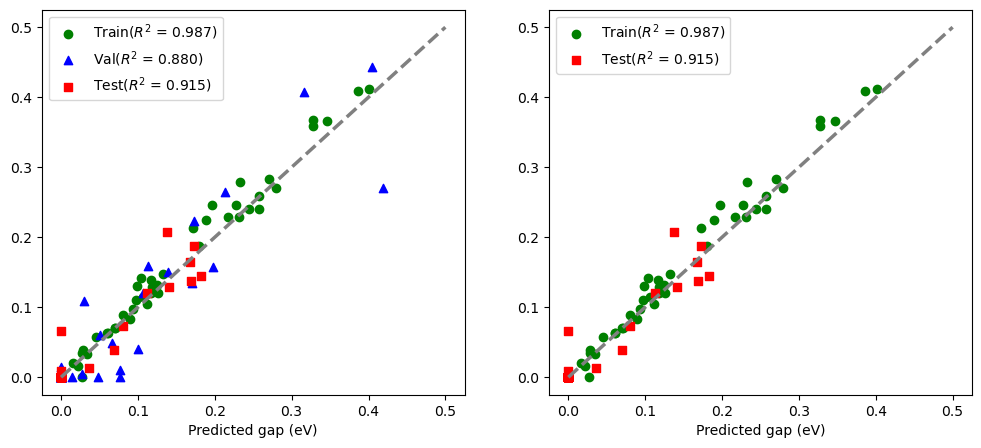

In [102]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,5))
ax1.scatter(y_eg_train['57'], pred_y_train,label='Train($R^2$ = '+str(f'{r2_train_569:.3f}')+')',marker='o',color='green')
ax1.scatter(y_eg_val['57'], pred_y_val,label='Val($R^2$ = '+str(f'{r2_val_569:.3f}')+')',marker='^',color='blue')
ax1.scatter(y_eg_test['57'], pred_y_test,label='Test($R^2$ = '+str(f'{r2_test_569:.3f}')+')',marker='s',color='red')
ax1.set_xlabel('Calculated gap (eV)')
ax1.set_xlabel('Predicted gap (eV)')
ax1.plot([0,0.5], [0,0.5],linewidth=2.5, color='gray', linestyle='dashed')
ax1.legend()

ax2.scatter(y_eg_train['57'], pred_y_train,label='Train($R^2$ = '+str(f'{r2_train_569:.3f}')+')',marker='o',color='green')
ax2.scatter(y_eg_test['57'], pred_y_test,label='Test($R^2$ = '+str(f'{r2_test_569:.3f}')+')',marker='s',color='red')
ax2.set_xlabel('Calculated gap (eV)')
ax2.set_xlabel('Predicted gap (eV)')
ax2.plot([0,0.5], [0,0.5],linewidth=2.5, color='gray', linestyle='dashed')
ax2.legend()
plt.show()

In [108]:
candidates_785 = pd.read_excel('descriptors_for_891_candidates.xlsx','without_Si')
df= pd.read_excel("withDescriptors_DFT_D3_ACS_AMI_348_hetero_Ef_Eg.xlsx")

In [116]:
features_55 = ['avg_vdw_radius', 'delta_a1a2_vdw_radius', 'delta_bx1418bx58914_avg_vdw_radius', 'max_diff_vdw_radius', 'std_vdw_radius', 
           'avg_covalent_radius', 'delta_a1a2_covalent_radius', 'delta_bx1418bx58914_avg_covalent_radius', 'max_diff_covalent_radius', 
           'std_covalent_radius', 'avg_atomic_radius', 'delta_a1a2_atomic_radius', 'delta_bx1418bx58914_avg_atomic_radius', 'max_diff_atomic_radius', 
           'std_atomic_radius', 'avg_atomic_volume', 'delta_a1a2_atomic_volume', 'delta_bx1418bx58914_avg_atomic_volume', 'max_diff_atomic_volume', 
           'std_atomic_volume', 'avg_dipole_polarizability', 'delta_a1a2_dipole_polarizability', 'delta_bx1418bx58914_avg_dipole_polarizability', 
           'max_diff_dipole_polarizability', 'std_dipole_polarizability', 'avg_val_electrons', 'delta_a1a2_val_electrons', 
           'delta_bx1418bx58914_avg_val_electrons', 'max_diff_val_electrons', 'std_val_electrons', 'avg_unp_electrons', 'delta_a1a2_unp_electrons',
           'delta_bx1418bx58914_avg_unp_electrons', 'max_diff_unp_electrons', 'std_unp_electrons', 'avg_ion_energies', 'delta_a1a2_ion_energies', 
           'delta_bx1418bx58914_avg_ion_energies', 'max_diff_ion_energies', 'std_ion_energies', 'avg_no_electrons', 'delta_a1a2_no_electrons', 
           'delta_bx1418bx58914_avg_no_electrons', 'max_diff_no_electrons', 'std_no_electrons', 'avg_electronegativity', 'delta_a1a2_electronegativity',
           'delta_bx1418bx58914_avg_electronegativity', 'max_diff_electronegativity', 'std_electronegativity', 'avg_electron_affinity', 
           'delta_a1a2_electron_affinity', 'delta_bx1418bx58914_avg_electron_affinity', 'max_diff_electron_affinity', 'std_electron_affinity']

In [117]:
X_785 = candidates_785[features_55]

In [124]:
X_785.columns = range(55)

In [126]:
pred_y_785 = np.concatenate([i.numpy().flatten() for i in loaded_model_569(X_785).values()])

In [128]:
pd.DataFrame(pred_y_785).to_csv('Results_Eg/569_FFNN_Eg_pred_785.csv',index=False)